In [357]:
import pandas as pd
import numpy as np                     # For mathematical calculations
import seaborn as sns                  # For data visualization
import matplotlib.pyplot as plt        # For plotting graphs
%matplotlib inline
import sqlite3
from tqdm import tqdm
import mglearn as mg
from IPython.display import display, HTML, Image
from datetime import datetime
import matplotlib.dates as mdates
from time import time
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
import warnings# To ignore any warnings
warnings.filterwarnings("ignore")

In [215]:
from scipy.stats.stats import pearsonr  

In [217]:
# Machine learning models
import sklearn

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve

from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import fbeta_score, accuracy_score, mean_squared_log_error, median_absolute_error, make_scorer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

# Unsupervised learning 
from sklearn.cluster import KMeans

# Regression algorithms
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.isotonic import IsotonicRegression # This regressor doesn't have a default parameter setting.
# from sklearn.linear_model import ARDRegression # This regressor takes too much time to model.
from sklearn.linear_model import HuberRegressor, Lasso, LassoCV, LinearRegression, PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor, Ridge, SGDRegressor, TheilSenRegressor 
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from xgboost import XGBRegressor

# Classification algorithms
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB # BernoulliNB and MultinomialNB are suitable only for discrete features
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
# from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier

import xgboost as xgb

In [18]:
# Set a global seed for randomization
random_state = 16
np.random.seed(random_state)

In [3]:
# First, import all the datasets.
# The status data cannot be directly imported due to its size. Below I will read the data through the database.
# The 'station.csv' needs to be read before one can process the sqlite in the below functions.
# Zip codes should be loaded as strings.
station=pd.read_csv("/home/venkatraman/Downloads/sf-bay-area-bike-share/station.csv")
trip=pd.read_csv("/home/venkatraman/Downloads/sf-bay-area-bike-share/trip.csv",dtype={'zip_code':'str'})
weather=pd.read_csv("/home/venkatraman/Downloads/sf-bay-area-bike-share/weather.csv")

In [4]:
# If sql_status is true, the status data will be obtained from the sqlite file (which takes about 10 min) and saved to a new csv file named "status_change.csv".
# If false, the status data will be obtained from the preprocessed "status_change.csv" file.
sql_status = True

In [5]:
# Define a convenient funtion to use SQL query.
def sql(cursor, command):    
    cursor.execute(command)
    result = cursor.fetchall()
    return result

In [6]:
def bike_status(station_id, sql_conn):
    '''The bike_status function iterates over stations and records only the changes of "bikes_available" and "docks_available" status.
    A Python 3.6 feature is used in this function. The f-string.'''
    
    status = pd.read_sql_query(f"SELECT * FROM status WHERE station_id = {station_id} ORDER BY time", con=sql_conn)
    
    # Register the change of status once the change is detected.
    # The exploration of status data later suggests that the datetime in status data is generally 1 minute later than that in the trip data. Both are recorded roughly every minute.
    status_compact = status[(status.bikes_available.diff(-1) * status.docks_available.diff(-1)) != 0]
    return status_compact

In [9]:
if sql_status == True:
    # Connect to the database in sqlite format.
    conn = sqlite3.connect('/home/venkatraman/Downloads/sf-bay-area-bike-share/database.sqlite')
    cursor = conn.cursor()  
    
    # Explore the tables in the database.
    find_tables = "SELECT name FROM sqlite_master;"
    tables = sql(cursor, find_tables)
    print(tables)

[('station',), ('status',), ('trip',), ('weather',)]


In [10]:
if sql_status == True:
    # Investigate the "status" columns in the database.
    # Python 3.6 f-string used.
    print(f"Table {tables[1][0]} contains the following columns:")
    display(sql(cursor, f"PRAGMA table_info({tables[1][0]});")) # tables[1][0] is 'status'.

Table status contains the following columns:


[(0, 'station_id', 'INTEGER', 0, None, 0),
 (1, 'bikes_available', 'INTEGER', 0, None, 0),
 (2, 'docks_available', 'INTEGER', 0, None, 0),
 (3, 'time', 'TEXT', 0, None, 0)]

In [14]:
if sql_status == True:
    # It is nearly impossible to directly import the status.csv to a pandas dataframe. It takes too much time and space.
    # In fact, it is not necessary to take all the data as plenty of them contain little information. 
    # The bike_status function will "compress" the original big data.
    # It takes about 11 minutes to process the data.
    # The 'station.csv' needs to be read before running the following code.
    
    status_list = [bike_status(station_id, conn) for station_id in tqdm(station.id)]
    
    # Concatenate all the station status to form a dataframe "status".
    status = pd.concat(status_list, ignore_index=True)
            
    # Double check that the concatenation doesn't remove rows.
    sum_status = 0
    for bike_station in status_list:
        sum_status += len(bike_station)
    
    print(sum_status)
    print(status.shape)
       
    # Write a .csv data for future import to save time. 
    # The size of data shrinks from the original 2.0GB to less than 60MB without losing important information.
    status.to_csv("status_change.csv", index=False)
    conn.close()
else:
    status = pd.read_csv("status_change.csv")

100%|██████████| 70/70 [07:36<00:00,  6.24s/it]


2093372
(2093372, 4)


# Data Exploration

## TRIP - Exploration on 'trip' data.

### Find independent station groups with least inter-group trips.

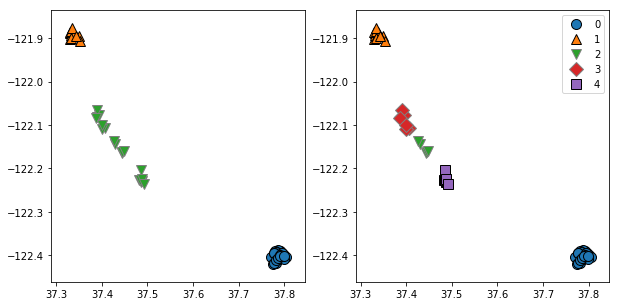

In [21]:
# Use clustering techniques to plot locations.
b_loc = station[['lat', 'long']] # b_loc: bike locations

# Use KMeans to find the clusters with the number of 3 and 5.
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# using three cluster centers:
kmeans_3 = KMeans(n_clusters=3, random_state=random_state).fit(b_loc)
mg.discrete_scatter(b_loc['lat'], b_loc['long'], kmeans_3.labels_, ax=axes[0])

# using five cluster centers:
kmeans_5 = KMeans(n_clusters=5, random_state=random_state).fit(b_loc)
mg.discrete_scatter(b_loc['lat'], b_loc['long'], kmeans_5.labels_, ax=axes[1])

plt.legend()
plt.show()

In [22]:
# Calculate the percentage of trips between stations. Most of the trips are between stations.
same_station = (trip.start_station_id != trip.end_station_id).nonzero()[0]
print("The percentage of trips between stations is {:.3%}.".format(len(same_station)/len(trip)))

The percentage of trips between stations is 96.421%.


In [23]:
# Define a function to quantify the reasonability of the KMeans clustering.
# Trips between clusters should be minimal.
def cluster2cluster(kmeans_labels, n_cluster, color='g'):
    # Group stations with the same cluster label.
    id_groups = [station.loc[kmeans_labels == i, 'id'].values for i in range(0, n_cluster)]
    
    s2s = trip.loc[:, ['start_station_id', 'end_station_id']]    
    # Create two columns to store the group ids for start and end stations.
    s2s['start_group'] = None
    s2s['end_group'] = None
    
    # Create new columns of group ids for the start station and the end station.
    group_id = 0
    for group in id_groups:
        s2s.loc[s2s.start_station_id.isin(group), 'start_group'] = group_id
        s2s.loc[s2s.end_station_id.isin(group), 'end_group'] = group_id
        group_id += 1
    
    # g2g = s2s[s2s.start_group != s2s.end_group][['start_group', 'end_group']] # One cluster to another cluster.
    g2g = s2s.loc[s2s.start_group != s2s.end_group, ['start_group', 'end_group']] # One cluster to another cluster.
    g2g_size = g2g.groupby(['start_group', 'end_group']).size() # The number of trips between groups.
    print("The percentage of trips between station clusters is {:.3%}.".format(len(g2g)/len(trip)))
    
    # Draw a group of bar charts.
    fig, axes = plt.subplots(1, n_cluster, figsize=(20, 5))    
    for i in range(n_cluster):
        x_ind = np.arange(g2g_size[i].size)
        axes[i].bar(x_ind, g2g_size[i], color=color)
        axes[i].set_xticks(x_ind)
        axes[i].set_xticklabels(g2g_size[i].index)
        axes[i].set_xlabel('Start station group %s' % i)
    
    plt.show()
    # The index of the group-to-group is returned. Those data will be deleted.
    return g2g.index

The percentage of trips between station clusters is 0.011%.


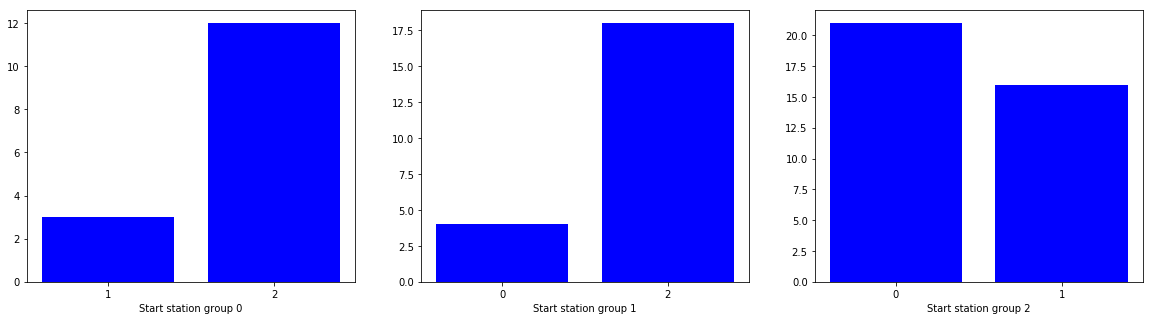

In [24]:
# Investigate group-to-group trips with 3 groups.
cluster3_index = cluster2cluster(kmeans_3.labels_, n_cluster=3, color='b')

The number of trips between the three bigger clusters are negligible compared to the total number of trips. The trips between San Jose to San Francisco are even fewer. This makes a lot of sense as few people can ride bikes for such a long trip. 

The percentage of trips between station clusters is 0.156%.


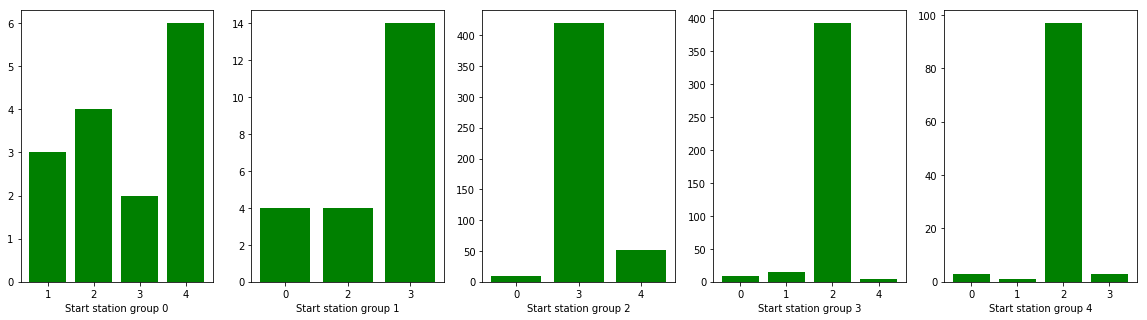

In [25]:
# Investigate group-to-group trips with 5 groups.
cluster5_index = cluster2cluster(kmeans_5.labels_, n_cluster=5, color='g')

In [26]:
# Verify the group is assigned correctly. 
station.loc[:, 'group'] = kmeans_5.labels_
station[['group','name']].head(3)

,group,name
0,1,San Jose Diridon Caltrain Station
1,1,San Jose Civic Center
2,1,Santa Clara at Almaden


In [27]:
# There are five unique zip codes from the weather data.
weather.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [28]:
# Arrange region zip codes from north to south
regions = [94107, 94063, 94301, 94041, 95113]
print(regions)

[94107, 94063, 94301, 94041, 95113]


The five zip codes correspond to: 94107: San Francisco; 94063: Redwood City; 94301: Palo Alto; 94041: Mountain View; 95113: San Jose. The weather condition has influence on people's decision whether to ride a bike or not, so it is very important. The five areas defined in the weather data match the station groups when the stations are clustered into five. It makes great sense to cluster the stations by five groups instead of three to better use the weather data and facilitate the machine learning technique.

In [29]:
# Group the station data by the group id and then sort the averaged longitude values in ascending order, which suggest from north to south.
north_to_south_groups = station.groupby('group')['long'].mean().sort_values()
north_to_south_idx = north_to_south_groups.index
print(north_to_south_groups)

group
0   -122.401517
4   -122.225626
2   -122.153588
3   -122.089002
1   -121.891606
Name: long, dtype: float64


In [30]:
# Create a mapping from the group ids to zip codes.
region_dict = dict(zip(north_to_south_idx, regions))
print(region_dict)

{0: 94107, 4: 94063, 2: 94301, 3: 94041, 1: 95113}


In [31]:
# Associate the zip codes with the cities.
region_names = dict(zip(regions, ['San Francisco', 'Redwood City', 'Palo Alto', 'Mountain View', 'San Jose']))
print(region_names)

{94107: 'San Francisco', 94063: 'Redwood City', 94301: 'Palo Alto', 94041: 'Mountain View', 95113: 'San Jose'}


In [32]:
# Create a new column of regions for trip data.
id_groups = [station['id'][kmeans_5.labels_ == i].values for i in range(5)]

trip['station_region'] = None
region_stations_dict = {} # Initiate a dictionary from the region code to stations.
group_id = 0
for group in id_groups:
    region_code = region_dict[group_id]
    region_idx = trip.start_station_id.isin(group)
    
    region_stations_dict[region_code] = group
    trip.loc[region_idx, 'station_region'] = region_code
    group_id += 1

In [33]:
# Investigate the percentage of inter-group trips among the groups. The group is assigned to the start station.
inter_group_trips = trip.station_region.loc[cluster5_index].value_counts()
region_trips = trip.station_region.value_counts()
inter_group_ratio = inter_group_trips / region_trips * 100

In [34]:
for region in region_trips.index:
    print('The percentage of trips from {} to a different region is {:.2f}% out of total {} trips.'.format(region_names[region], inter_group_ratio[region], region_trips[region]))

The percentage of trips from San Francisco to a different region is 0.00% out of total 603708 trips.
The percentage of trips from San Jose to a different region is 0.06% out of total 37878 trips.
The percentage of trips from Mountain View to a different region is 2.32% out of total 18167 trips.
The percentage of trips from Palo Alto to a different region is 7.09% out of total 6773 trips.
The percentage of trips from Redwood City to a different region is 3.03% out of total 3433 trips.


In [35]:
# Investigate how many inter-group trips are made by a subscriber or a non-subscriber
trip.subscription_type.loc[cluster5_index].value_counts()

Customer      532
Subscriber    510
Name: subscription_type, dtype: int64

The inter-group trips are not negligible for some regions, especially for the three stations that are geographically close to each other. So the inter-group trips will be deleted. A new column will not be created to indicate whether a trip is inter-group or not. Although there are about the same number of subscribers and non-subscribers for inter-group trips, labeling an inter-group trip can still be useful to find out different patterns for different subscription types when other features are taken into account.


In [37]:
# Create a new column to label a trip as an inter-group trip.
trip['inter_group'] = 0
trip.loc[cluster5_index, 'inter_group'] = 1

In [38]:
# Create a new column in station to cluster the stations into groups
station['region'] = None
for region, group in region_stations_dict.items():
    station.loc[station.id.isin(group), 'region'] = region

# Hourly trip counts for different subscription types.

In [41]:
# trip_date = trip['start_date'].str.split(' |/|:')
# Separate the date and time. Only the start date is important. Anyway, the number of trips over 24 hours is rare.

trip_datetime = trip['start_date'].apply(lambda x: x.split())
trip_date = trip_datetime.apply(lambda x: datetime.strptime(x[0], "%m/%d/%Y").date())
trip_time = trip_datetime.apply(lambda x: x[1])
trip_hour = trip_time.apply(lambda x: int(x.split(':')[0]))
trip['hour'] = trip_hour
trip['date'] = trip_date

Convert a string into datetime https://stackoverflow.com/questions/466345/converting-string-into-datetime

In [42]:
# Alternative way to judge whether a day is a business day.
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=trip.date.min(), end=trip.date.max())

#Find all of the business days in our time span
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=trip.date.min(), end=trip.date.max(), freq=us_bd)
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date

In [43]:
def isbday(x, bday=business_days):
    if x in bday:
        return True
    else:
        return False

In [44]:
# To expedite the process, the judgement of whether a day is a business day will be applied on unique days and then mapped to all rows in trip data.
trip_date_unique = pd.Series(trip_date.unique())
trip_BDay_unique = trip_date_unique.apply(lambda x: isbday(x))

trip_date_dict = dict(zip(trip_date_unique, trip_BDay_unique))
trip_BDay = trip_date.apply(lambda x: trip_date_dict[x])

In [45]:
# Create a new column in trip data for business day judgement.
trip['BDay'] = trip_BDay
print('There are {} business days in the record.'.format(len(trip_date[trip_BDay==True].unique())))
print('There are totally {} days in the record.'.format(len(trip_date.unique())))

There are 503 business days in the record.
There are totally 733 days in the record.


In [46]:
# Define a function to visualize the number of trips per hour in order to find a reasonable way to divide the day.
def trip_hour_freq(trip_hour, trip_date, trip_day_idx, data_idx, ax, xlabel):
    # Slice the trip_hour, count each value, sort the count series by index and then plot it.
    trip_counts = trip_hour[trip_day_idx & data_idx].value_counts().sort_index() # Calculate the number of trips for each hour
    freq_day = trip_counts/len(trip_date[trip_day_idx].unique()) # Calculate the frequency per day
    ax.bar(freq_day.index, freq_day) # Plot the trip hours.
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Trip Frequency Per Day')
    ax.set_xticks(freq_day.index) # Display all the xticks, which are 24 hours.

In [47]:
# Counts for subscribers and non-subscribers
trip['subscription_type'].value_counts()

Subscriber    566746
Customer      103213
Name: subscription_type, dtype: int64

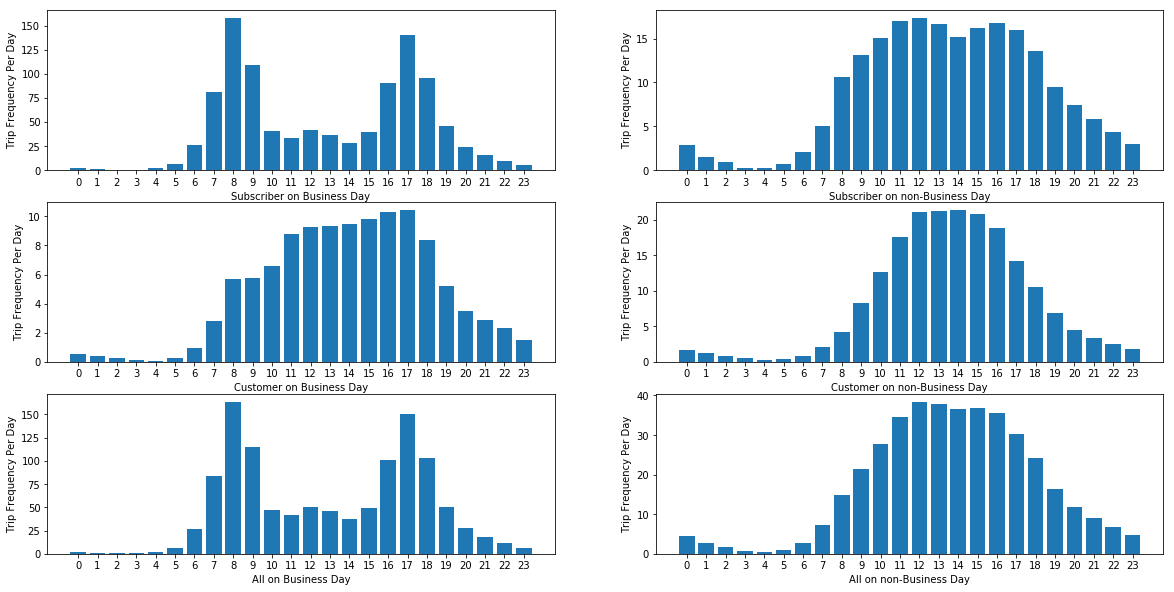

In [48]:
# Show bar charts for user behaviors on during business days and rest days.
fig, axes = plt.subplots(3, 2, figsize=(20,10))

trip_hour_freq(trip_hour, trip_date, trip_BDay==True, trip.subscription_type=='Subscriber', axes[0][0], 'Subscriber on Business Day')
trip_hour_freq(trip_hour, trip_date, trip_BDay==False, trip.subscription_type=='Subscriber', axes[0][1], 'Subscriber on non-Business Day')

trip_hour_freq(trip_hour, trip_date, trip_BDay==True, trip.subscription_type=='Customer', axes[1][0], 'Customer on Business Day')
trip_hour_freq(trip_hour, trip_date, trip_BDay==False, trip.subscription_type=='Customer', axes[1][1], 'Customer on non-Business Day')

trip_hour_freq(trip_hour, trip_date, trip_BDay==True, True, axes[2][0], 'All on Business Day')
trip_hour_freq(trip_hour, trip_date, trip_BDay==False, True, axes[2][1], 'All on non-Business Day')

plt.show()

In fact, there are not too many trips per day. The dominant usage is from subscribers for business days, i.e. for work. For work, there are two main peaks, one at 8 am and the other at 5 pm. The division point will be set to (8 + 17)/2 = 12.5. Subscribers tend to use the sharebike for commuting to work place, while non-subscribers tend to use that for lunches, etc. Interestingly, the behavior of non-subscribers during weekends and holidays is almost a perfect Gaussian shape peaking between 1-2 pm.

# Trip counts for different weekdays.

In [49]:
# Create a new column to record weekdays
trip['weekday'] = pd.to_datetime(trip['date']).dt.weekday

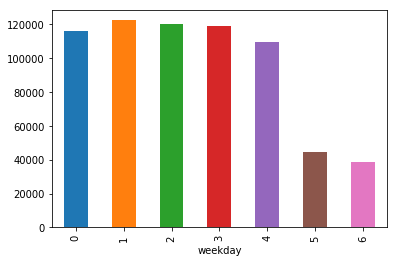

In [50]:
# Plot the trip counts for each weekday. 0 is Monday and 6 is Sunday.
trip.groupby('weekday')['id'].count().plot('bar')
plt.show()

# Monthly trip counts for different description types to reveal the seasonal patterns.

In [51]:
# Create a new column for month.
trip['month'] = trip_datetime.apply(lambda x: int(x[0].split('/')[0]))

In [52]:
# Group the trip first by subscription type and then by month.
trip_monthly = trip.groupby(['subscription_type', 'month'])['id'].count()

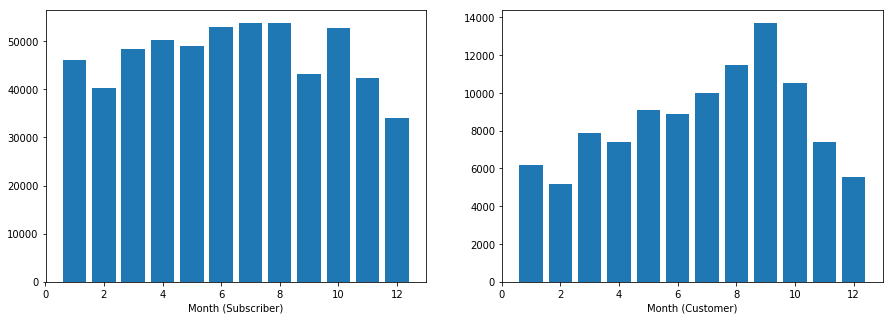

In [53]:
# View the number of trips on each month.
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].bar(trip_monthly['Subscriber'].index, trip_monthly['Subscriber'])
axes[0].set_xlabel('Month (Subscriber)')
axes[1].bar(trip_monthly['Customer'].index, trip_monthly['Customer'])
axes[1].set_xlabel('Month (Customer)')
plt.show()

Interestingly, there is no significant variation on the number of monthly trips for subscribers except the holiday season (December); for non-subscribers we observe a clear trend of increase from the beginning of the year peaking at September and then decrease: this suggests that summer is generally a good time to bike in Bay Area for fun and September is the best season for tourists to visit Bay Area?

# Hourly trip counts for each station group.

In [55]:
# Group the trips first by region and then by hour.
trip_groupby_station = trip.groupby(['station_region', 'hour'])['id'].count()

In [56]:
# Set the hour out as a feature column. Keep the station region as the index.
trip_station_region = trip_groupby_station.reset_index(level=1)

In [57]:
# The station groups in the trip data match those in the weather data.
print(trip_groupby_station.index.levels[0])
print(regions)

Int64Index([94041, 94063, 94107, 94301, 95113], dtype='int64', name='station_region')
[94107, 94063, 94301, 94041, 95113]


In [58]:
trip.groupby(['station_region'])['id'].count()

station_region
94041     18167
94063      3433
94107    603708
94301      6773
95113     37878
Name: id, dtype: int64

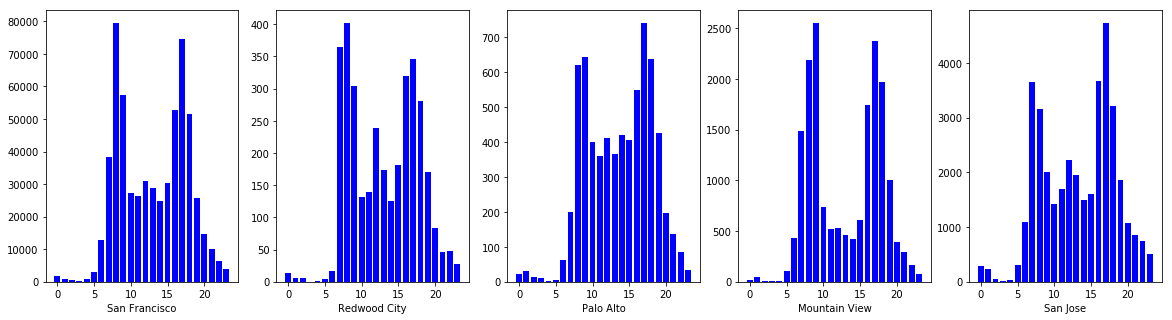

In [59]:
# Plot the trips per hour for each city.
fig, axes = plt.subplots(1, 5, figsize=(20,5))
i = 0
for region in regions:
    region_counts = trip_station_region.loc[region]
    axes[i].bar(region_counts.hour, region_counts.id, color='b')
    axes[i].set_xlabel(region_names[region])
    i += 1
plt.show()

As we can see from the above figure, the number of trips in San Francisco is way larger than the other regions. Even the city ranking the second only has a fraction number of trips of it. This is going to skew the data analysis for trips in cities other than San Francisco, so it is necessary to divide the trips into different groups and treat them separately.

# Bike durations exploration.

In [60]:
# Get the mean trip duration for each region in minute.
bike_durations = trip.groupby('station_region')['duration'].mean()/60
bike_durations_median = trip.groupby('station_region')['duration'].median()/60
trip_region_counts = trip.groupby('station_region')['id'].count()

In [61]:
for region, duration in bike_durations.iteritems():
    print('There are {0} trips in {1}, lasting {2:.1f} minutes in average.'.format(trip_region_counts[region], region_names[region], duration))

There are 18167 trips in Mountain View, lasting 29.9 minutes in average.
There are 3433 trips in Redwood City, lasting 40.7 minutes in average.
There are 603708 trips in San Francisco, lasting 17.1 minutes in average.
There are 6773 trips in Palo Alto, lasting 71.3 minutes in average.
There are 37878 trips in San Jose, lasting 23.0 minutes in average.


In [62]:
for region, duration in bike_durations_median.iteritems():
    print('There are {0} trips in {1}, lasting {2:.1f} minutes in average.'.format(trip_region_counts[region], region_names[region], duration))

There are 18167 trips in Mountain View, lasting 5.0 minutes in average.
There are 3433 trips in Redwood City, lasting 6.3 minutes in average.
There are 603708 trips in San Francisco, lasting 8.8 minutes in average.
There are 6773 trips in Palo Alto, lasting 15.1 minutes in average.
There are 37878 trips in San Jose, lasting 7.7 minutes in average.


In [63]:
bike_durations.index = bike_durations.index.to_series().map(region_names)
bike_durations_median.index = bike_durations.index

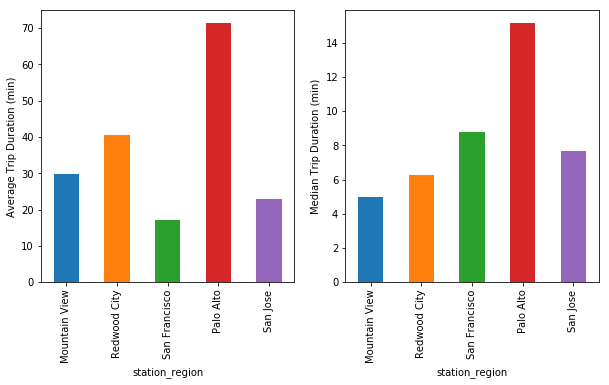

In [64]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
bike_durations.plot.bar()
plt.ylabel('Average Trip Duration (min)')

plt.subplot(122)
bike_durations_median.plot.bar()
plt.ylabel('Median Trip Duration (min)')
plt.show()

In [65]:
trip_duration = trip.duration.sort_values()

In [66]:
div = 10 # Set the number of pieces to divide the trip_duration
trip_duration_idx = np.linspace(0, len(trip_duration), num=div, endpoint=False, dtype='int')
division_points = trip_duration.iloc[trip_duration_idx[1:]]/60
print("All trips can be divided into {} pieces with minute division points at:".format(div))
print(['%.1f' % elem for elem in division_points])

All trips can be divided into 10 pieces with minute division points at:
['4.0', '5.2', '6.3', '7.4', '8.6', '9.9', '11.6', '13.9', '19.2']


As we can see above, most of the trips are pretty short. More than 90% of the trips are shorter than 20 minutes.

In [67]:
trip_duration_subscriber = trip_duration[trip.subscription_type=='Subscriber'].mean()/60
trip_duration_customer = trip_duration[trip.subscription_type=='Customer'].mean()/60

print('The average trip duration for a subscriber is %.1f minutes.' % trip_duration_subscriber)
print('The average trip duration for a non-subscriber is %.1f minutes.' % trip_duration_customer)

The average trip duration for a subscriber is 9.8 minutes.
The average trip duration for a non-subscriber is 65.9 minutes.


A non-subscriber tends to have a much longer trip than a subscriber. This is reasonable as most subscribers probably use sharebikes for work commuting while non-subscribers use it for leisure purposes.

# Bike usage exploration.

In [68]:
# Calculate the bike usage based on the bike id.
bike_usage = trip.bike_id.value_counts()

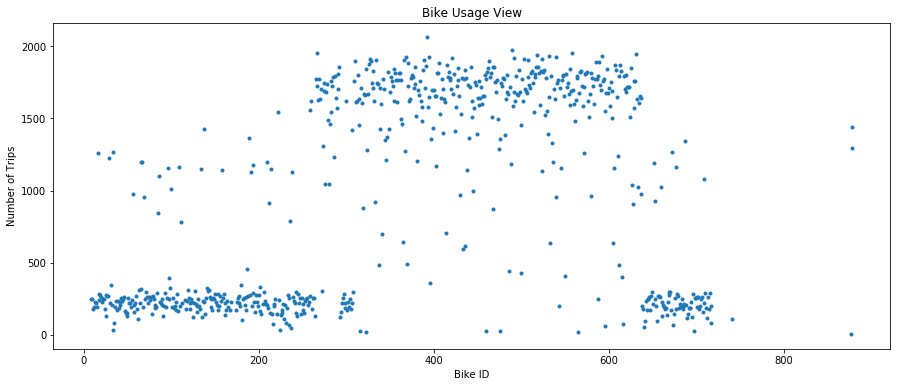

In [69]:
# It would be interesting to figure out where the most used bikes come from and the potential lifetime of the bike
plt.figure(figsize=(15,6))
plt.plot(bike_usage.index, bike_usage, '.')
plt.ylabel("Number of Trips")
plt.xlabel("Bike ID")
plt.title("Bike Usage View")
plt.show()

In [70]:
# Get the bike ids 
most_used_bikes = bike_usage[bike_usage > 1500].index
least_used_bikes = bike_usage[bike_usage < 500].index

In [71]:
# Get the bike trips
most_used_bikes_trips = trip[trip.bike_id.isin(most_used_bikes)]
least_used_bikes_trips = trip[trip.bike_id.isin(least_used_bikes)]

In [72]:
# Group by the station regions
most_used_bikes_group = most_used_bikes_trips.groupby('station_region')['bike_id'].count()
least_used_bikes_group = least_used_bikes_trips.groupby('station_region')['bike_id'].count()

In [73]:
# Change the index from zip code to city name
most_used_bikes_group.index = most_used_bikes_group.index.to_series().map(region_names)
least_used_bikes_group.index = least_used_bikes_group.index.to_series().map(region_names)

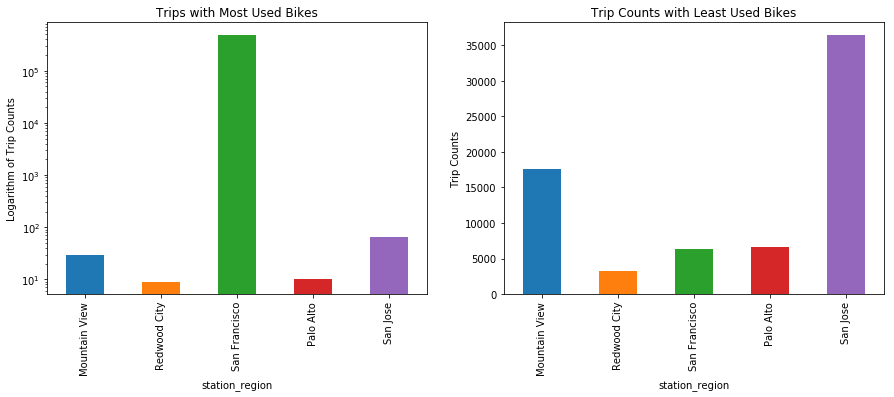

In [74]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
most_used_bikes_group.plot.bar(logy=True)
plt.ylabel('Logarithm of Trip Counts')
plt.title('Trips with Most Used Bikes')

plt.subplot(122)
least_used_bikes_group.plot.bar()
plt.ylabel('Trip Counts')
plt.title('Trip Counts with Least Used Bikes')
plt.show()

In [75]:
station.head()

,id,name,lat,long,dock_count,city,installation_date,group,region
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,1,95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,1,95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,1,95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,1,95113
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,1,95113


In [76]:
# Calculate the number of docks in each region
region_dock_counts = station.groupby('region')['dock_count'].sum()
print(region_dock_counts)

region
94041    117
94063    115
94107    665
94301     75
95113    264
Name: dock_count, dtype: int64


In [77]:
region_dock_counts.index = region_dock_counts.index.to_series().map(region_names)

In [78]:
least_used_bikes_group / region_dock_counts

station_region
Mountain View    150.025641
Redwood City      28.817391
San Francisco      9.442105
Palo Alto         87.600000
San Jose         137.818182
dtype: float64

# Local zip code investigation.

In [79]:
# Fill NaN with an empty string.
trip.zip_code.fillna('', inplace=True)

In [83]:
# Sectional Center Facility: 
# Obtain zip codes (first three digits) for bay area from online source: http://maps.huge.info/zip3.htm
zip3 = ['948', '945', '947', '946', '941', '944', '940', '943', '950']

In [84]:
# Create a new column with True and False values indicating whether the rider is from Bay Area or not (roughly).
trip['local_zip'] = trip.zip_code.apply(lambda x: x[0:3] in zip3 and len(x)>=5)

In [85]:
# Calculate the ratio of the local zip number and the total zip number
local_percentage = trip.groupby('subscription_type')['local_zip'].sum() / trip.subscription_type.value_counts() * 100
print('{:.2f}% of the subscribers are local people.'.format(local_percentage[1]))
print('{:.2f}% of the non-subscribers are local people.'.format(local_percentage[0]))

89.10% of the subscribers are local people.
29.28% of the non-subscribers are local people.


This is as expected. Most subscribers are local residents, while most of the non-subscribers are tourists.

# Trip trend over time

In [86]:
# Obtain the daily trips groupby the business day column
daily_trips = trip.groupby('date').agg({'BDay': ['median', 'count']})

In [87]:
# Separate the business and non-business day trips
BDay_trips = daily_trips[daily_trips['BDay']['median'] == True].reset_index()
nonBDay_trips = daily_trips[daily_trips['BDay']['median'] == False].reset_index()

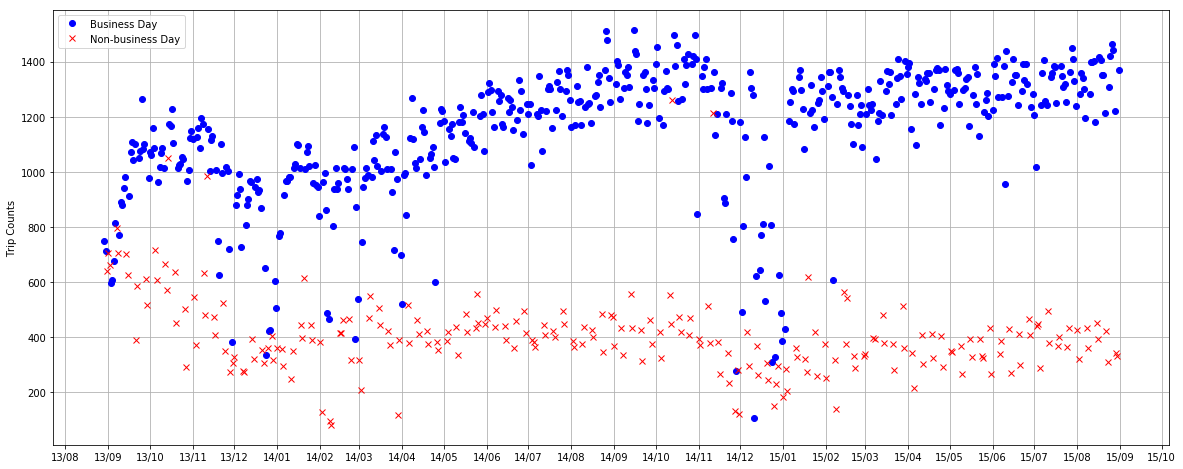

In [90]:
# Plot the trip counts per day 
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(BDay_trips.date, BDay_trips['BDay']['count'], 'bo', label='Business Day')
plt.plot(nonBDay_trips.date, nonBDay_trips['BDay']['count'], 'rx', label='Non-business Day')

# Set the x axis so that every month will be displayed
months = mdates.MonthLocator()
year_month_Fmt = mdates.DateFormatter('%y/%m')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(year_month_Fmt)

plt.legend()
plt.ylabel('Trip Counts')
ax.grid(True)


plt.show()

In [91]:
# Find out the outliers of the non-business day trips. Four are found on the above graph.
nonBDay_outliers = nonBDay_trips.loc[nonBDay_trips['BDay'].sort_values('count').iloc[-4:].index]
print(nonBDay_outliers)

           date   BDay      
                median count
24   2013-11-11  False   986
15   2013-10-14  False  1050
138  2014-11-11  False  1213
129  2014-10-13  False  1261


In [92]:
nonBDay_outliers.date

24     2013-11-11
15     2013-10-14
138    2014-11-11
129    2014-10-13
Name: date, dtype: object

In [95]:
# Apparently some companies don't have Veterans Day and Columbus Day off, and this seems to be a common situation.
# Exclude these two holidays from the non-business days.
trip.loc[trip.date.isin(nonBDay_outliers.date), 'BDay'] = True

In [96]:
# Data before 2013/10 should be treated differently
before_Oct2013 = np.count_nonzero(trip.date < datetime(2013, 10, 1).date())
print("Percentage of trips happening before 2013/10 is {:.2%}".format(before_Oct2013/len(trip)))

Percentage of trips happening before 2013/10 is 4.08%


In [97]:
# Clearly the patterns before and after october are different. In fact, I can just delete the data, but it is also fine to just label it.
trip['before_Oct2013'] = trip.date < datetime(2013, 10, 1).date()

It is also noticeable that the business day trips are much less during December. December is considered the holiday season in the US. This means that the month can be an important feature.

# Check if there is nan value in trip data

In [98]:
# There are no nan values in the trip data.
trip.isnull().sum()

id                    0
duration              0
start_date            0
start_station_name    0
start_station_id      0
end_date              0
end_station_name      0
end_station_id        0
bike_id               0
subscription_type     0
zip_code              0
station_region        0
inter_group           0
hour                  0
date                  0
BDay                  0
weekday               0
month                 0
local_zip             0
before_Oct2013        0
dtype: int64

# STATUS - Exploration on 'status' data.

# Total docks

In [99]:
# Create a dictionary of station to its originally designed dock counts.
# Create two more columns for the status data: the originally designed dock counts and the real number of docks.
station_docks = dict(zip(station.id, station.dock_count))
status['dock_count'] = status.station_id.apply(lambda x: station_docks[x])
status['total'] = status['bikes_available'] + status['docks_available']

# More docks.

In [100]:
# Check situations when the sum of bikes and docks is larger than the originally designed number of docks.
more_docks = status.loc[status.total - status.dock_count > 0, :]
more_docks.groupby(['station_id', 'total']).count()

bikes_available  docks_available  time  dock_count
station_id total                                                    
22         26                 237              237   237         237
           27                9547             9547  9547        9547
39         20                   2                2     2           2
           21                 186              186   186         186

As the above tables shows, only two stations have the total number of docks larger than the originally designed dock counts. Close to 10000 entries in the status data has dock count to be 27, which is pretty suspicious. Below we will explore further whether the total number of docks indeed changes or just system malfunction.

In [102]:
# Show both the head and the tail of station 22. 
# It shows that the number of docks for station 22 is actually 27 in the beginning and the end. The number of dock count for station 22 needs to be updated.
status[status.station_id == 22].iloc[np.r_[0:5, -5:0]]

,station_id,bikes_available,docks_available,time,dock_count,total
322607,22,13,14,2013/08/29 12:21:01,25,27
322608,22,14,13,2013/08/29 12:39:01,25,27
322609,22,13,14,2013/08/29 12:45:02,25,27
322610,22,12,15,2013/08/29 12:48:01,25,27
322611,22,13,14,2013/08/29 17:49:01,25,27
332809,22,13,14,2015-08-31 17:42:01,25,27
332810,22,17,10,2015-08-31 18:17:02,25,27
332811,22,18,9,2015-08-31 18:55:03,25,27
332812,22,17,10,2015-08-31 19:08:02,25,27
332813,22,16,11,2015-08-31 23:59:02,25,27


In [103]:
# Show both the head and the tail of station 39.
# It shows that the number of docks for station 39 is 19 in the beginning and the end. No change. The larger count could be just a system error.
status[status.station_id == 39].iloc[np.r_[0:5, -5:0]]

,station_id,bikes_available,docks_available,time,dock_count,total
917017,39,7,12,2013/08/29 12:41:03,19,19
917018,39,6,13,2013/08/29 13:17:01,19,19
917019,39,7,12,2013/08/29 13:23:01,19,19
917020,39,8,11,2013/08/29 13:44:02,19,19
917021,39,7,12,2013/08/29 13:45:01,19,19
957027,39,5,14,2015-08-31 19:39:02,19,19
957028,39,6,13,2015-08-31 19:45:02,19,19
957029,39,7,12,2015-08-31 20:06:02,19,19
957030,39,8,11,2015-08-31 20:14:02,19,19
957031,39,9,10,2015-08-31 23:59:02,19,19


In [104]:
# Update the station 22 dock count to 27
station_22_index = (station.id == 22).nonzero()[0][0]
station.loc[station_22_index, 'dock_count'] = 27
station_docks = dict(zip(station.id, station.dock_count))
status['dock_count'] = status.station_id.apply(lambda x: station_docks[x])

In [105]:
# Check situations when the sum of bikes and docks is larger than the originally designed number of docks.
more_docks = status[status.total - status.dock_count > 0]
more_docks.groupby(['station_id', 'total']).count()

bikes_available  docks_available  time  dock_count
station_id total                                                    
39         20                   2                2     2           2
           21                 186              186   186         186

# Less Docks

In [106]:
# Count the number of status changes when the sum of available bikes and docks is smaller than the actual dock count, which shouldn't change in the two years' operation.
less_docks = status.loc[status.total - status.dock_count < 0, :]
less_docks_counts = less_docks.groupby(['station_id'])['total'].count()
less_docks_station_id = less_docks_counts.index

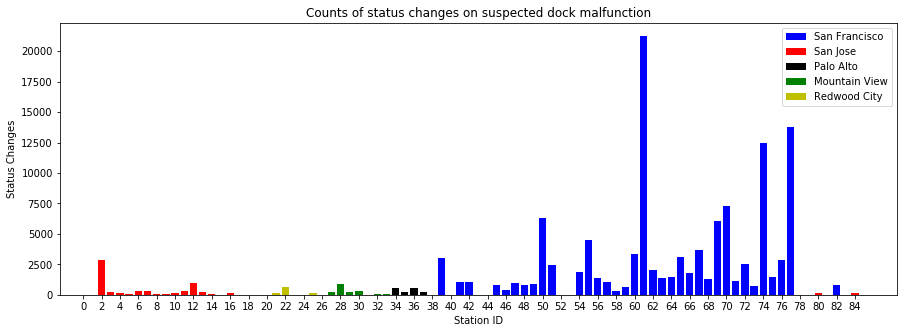

In [107]:
fig, ax = plt.subplots(figsize=(15, 5))
for region, color in zip(region_stations_dict, ['b', 'r', 'k', 'g', 'y']):
    station_docks_count = less_docks_counts.loc[region_stations_dict[region]]
    ax.bar(station_docks_count.index, station_docks_count, color=color, label=region_names[region])

plt.xlabel('Station ID')
plt.ylabel('Status Changes')
plt.title('Counts of status changes on suspected dock malfunction')
plt.xticks(range(0, max(less_docks_station_id)+1, 2))
plt.legend()
plt.show()

In [108]:
# Demonstrate how to obtain the hour of the status data.
print(less_docks.time.iloc[1])
print(int(less_docks.time.iloc[1].split()[1].split(':')[0]))

2013/10/18 08:14:01
8


In [109]:
less_docks['hour'] = less_docks.time.apply(lambda x: int(x.split()[1].split(':')[0]))

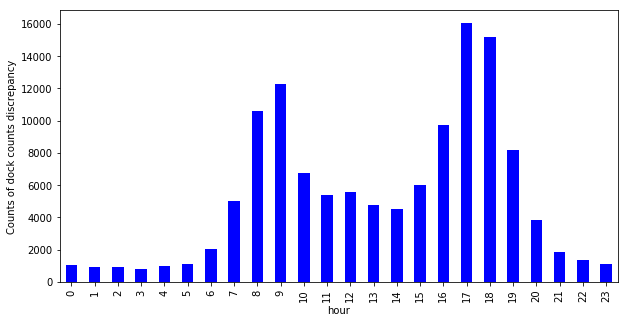

In [110]:
less_docks_counts_hour = less_docks.groupby('hour')['time'].count()

plt.figure(figsize=(10, 5))
less_docks_counts_hour.plot.bar(color='blue')
plt.ylabel('Counts of dock counts discrepancy')
plt.show()

Although the dock malfunction may indeed happen possible due to vandalism, it is also possible that the dock status may not be well reflected when frequent change of status happends in less than one minute.

# Total dock changes

In [111]:
status['hour'] = status.time.apply(lambda x: int(x.split()[1].split(':')[0]))

In [112]:
%%time
status['datetime'] = pd.to_datetime(status.time)
status['date'] = status.datetime.apply(lambda x: x.date())
status['weekday'] = status.datetime.dt.weekday

CPU times: user 5.37 s, sys: 120 ms, total: 5.49 s
Wall time: 5.48 s


In [113]:
# Get the total dock count change events per station
station_status_list = []
for station_id in status.station_id.unique():
    station_status = status[status.station_id == station_id]
    station_status_list.append(station_status[station_status.total.diff() != 0])

In [114]:
# Concatenate the list to form the full dataframe
dock_changes = pd.concat(station_status_list)
print(dock_changes.shape)
print('The total dock count change events occurs in {:.2f}% of the total status changes.'.format(len(dock_changes) / len(status) * 100))

(11872, 10)
The total dock count change events occurs in 0.57% of the total status changes.


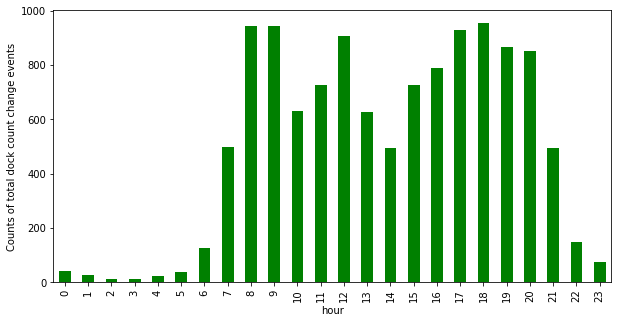

In [115]:
plt.figure(figsize=(10, 5))
dock_changes.groupby('hour')['total'].count().plot.bar(color='green')
plt.ylabel('Counts of total dock count change events')
plt.show()

# Extra trips in status data

In [116]:
# Get the number of station status changes from the trip data. Start suggests the decrease of available bikes. End suggests the increase.
trip_status_start = trip.loc[:, ['start_date', 'weekday']]
trip_status_end = trip.loc[:, ['end_date', 'weekday']]

trip_status_start['start_hour'] = trip_status_start.loc[:, 'start_date'].apply(lambda x: int(x.split()[1].split(':')[0]))
trip_status_end['end_hour'] = trip_status_end.loc[:, 'end_date'].apply(lambda x: int(x.split()[1].split(':')[0]))

In [117]:
# Calculate the event counts per hour for trip data
trip_status_start_count = trip_status_start.groupby(['weekday', 'start_hour'])['start_hour'].count()
trip_status_end_count = trip_status_end.groupby(['weekday', 'end_hour'])['end_hour'].count()

In [118]:
# Calculate the change of number of the available bikes
status['bike_diff'] = status.bikes_available.diff()

In [119]:
# Calculate the bike count increase and decrease in status data
bike_incr = status.loc[status.bike_diff > 0, :]
bike_decr = status.loc[status.bike_diff < 0, :]

In [120]:
# Calculate the event counts per hour for status data
bike_incr_count = bike_incr.groupby(['weekday', 'hour'])['bike_diff'].sum()
bike_decr_count = - bike_decr.groupby(['weekday', 'hour'])['bike_diff'].sum() # All bike_diff values are negative. Need to be negated.

In [121]:
# Calculate the extra trips in status data than in trip data
bike_incr_diff = bike_incr_count - trip_status_end_count
bike_decr_diff = bike_decr_count - trip_status_start_count

In [122]:
bike_incr_diff_reset = bike_incr_diff.reset_index()
bike_decr_diff_reset = bike_decr_diff.reset_index()

bike_incr_diff_reset.columns = ['weekday', 'hour', 'counts']
bike_decr_diff_reset.columns = ['weekday', 'hour', 'counts']

In [123]:
number_of_weeks = len(trip.date.unique()) / 7
bike_incr_diff_reset.counts = bike_incr_diff_reset.counts / number_of_weeks # Calculate the averaged daily extra trips
bike_decr_diff_reset.counts = bike_decr_diff_reset.counts / number_of_weeks # Calculate the averaged daily extra trips

# Convert into a 2D table.
bike_incr_diff_pivot = bike_incr_diff_reset.pivot(index='hour', columns='weekday', values='counts')
bike_decr_diff_pivot = bike_decr_diff_reset.pivot(index='hour', columns='weekday', values='counts')

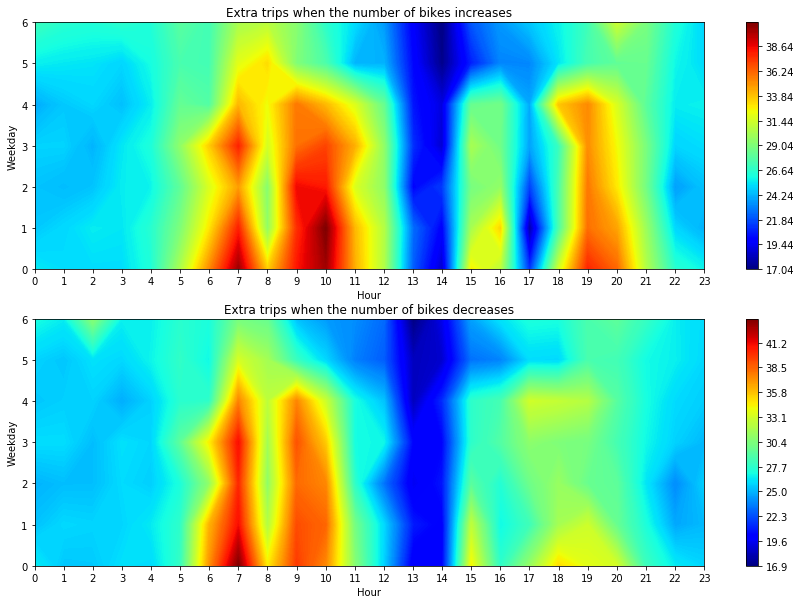

In [124]:
# Generate the contour plot.
X = bike_incr_diff_pivot.columns.values
Y = bike_incr_diff_pivot.index.values
Z_incr = bike_incr_diff_pivot.values
Z_decr = bike_decr_diff_pivot.values

Xi,Yi = np.meshgrid(X, Y)
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.title('Extra trips when the number of bikes increases')
plt.xticks(range(0, 24, 1))
plt.yticks(range(0, 7, 1))
plt.contourf(Yi, Xi, Z_incr, 300, cmap=plt.cm.jet)
plt.colorbar()

plt.subplot(212)
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.title('Extra trips when the number of bikes decreases')
plt.xticks(range(0, 24, 1))
plt.yticks(range(0, 7, 1))
plt.contourf(Yi, Xi, Z_decr, 300, cmap=plt.cm.jet)
plt.colorbar()

plt.show()

In [125]:
print('There are {:.1f}% more trips with bike count increase in status data.'.format((bike_incr.bike_diff.sum() - len(trip_status_end)) / len(trip_status_end) * 100))
print('There are {:.1f}% more trips with bike count decrease in status data.'.format((- bike_decr.bike_diff.sum() - len(trip_status_start)) / len(trip_status_start) * 100))

There are 73.7% more trips with bike count increase in status data.
There are 73.7% more trips with bike count decrease in status data.


In [126]:
# Clean up the status data so that only available bike changes are used. It contributes more than 99% to the data.
bike_avail_changes = status[status.bikes_available.diff() != 0]
len(bike_avail_changes) / len(status)

0.9985898349648319

# View only on the hour axis.

In [127]:
bike_incr_diff_hour = bike_incr_diff_reset.groupby('hour')['counts'].sum()
bike_decr_diff_hour = bike_decr_diff_reset.groupby('hour')['counts'].sum()

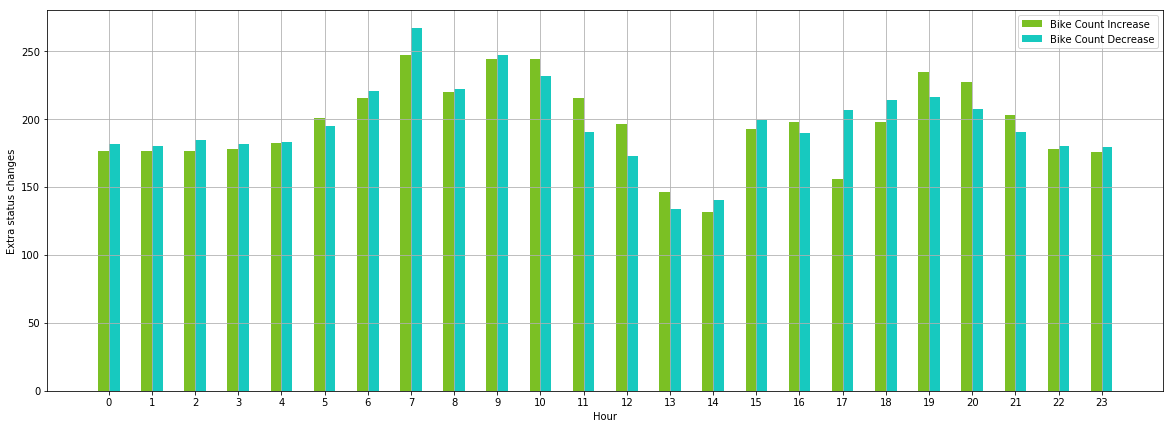

In [128]:
# Plot the feature importances from the daily, am, pm trip models
X_tick_labels = bike_incr_diff_hour.index
pos = np.array(range(len(X_tick_labels)))

plt.figure(figsize=(20, 7))
ax = plt.subplot(111)
width = 0.25
ax.bar(pos-0.5*width, bike_incr_diff_hour, width=width, color='#7BC024', label='Bike Count Increase')
ax.bar(pos+0.5*width, bike_decr_diff_hour, width=width, color='#17C9BF', label='Bike Count Decrease')
ax.legend()

ax.set_xlabel('Hour')
ax.set_ylabel('Extra status changes')
ax.set_xticks(pos)
ax.set_xticklabels(X_tick_labels)

# Adding the legend and showing the plot
plt.legend(loc='upper right')
plt.grid()
plt.show()

# When are stations empty?

In [129]:
%%time
# Read all the status data that have zero bikes available.
conn = sqlite3.connect('/home/venkatraman/Downloads/sf-bay-area-bike-share/database.sqlite')
cursor = conn.cursor()
no_bikes = pd.read_sql_query(f"SELECT * FROM status WHERE bikes_available = 0 ORDER BY time", con=conn)
conn.close()

CPU times: user 4.01 s, sys: 1.96 s, total: 5.97 s
Wall time: 6.18 s


In [130]:
no_bikes.head()

,station_id,bikes_available,docks_available,time
0,4,0,11,2013/08/29 12:06:01
1,7,0,15,2013/08/29 12:06:01
2,13,0,15,2013/08/29 12:06:01
3,70,0,19,2013/08/29 12:06:01
4,4,0,11,2013/08/29 12:07:01


In [131]:
# Get the business day
no_bikes['datetime'] = pd.to_datetime(no_bikes.time)
no_bikes['date'] = no_bikes.datetime.apply(lambda x: x.date())
no_bikes['hour'] = no_bikes.time.apply(lambda x: int(x.split()[1].split(':')[0])) # Get the hours in a day.

no_bikes_date_unique = pd.Series(no_bikes.date.unique())
no_bikes_BDay_unique = no_bikes_date_unique.apply(lambda x: isbday(x))

no_bikes_date_dict = dict(zip(no_bikes_date_unique, no_bikes_BDay_unique))
no_bikes['BDay'] = no_bikes.date.apply(lambda x: no_bikes_date_dict[x])

In [132]:
# Assign the regions to stations.
no_bikes['station_region'] = None
no_bikes_region_dict = {} # Initiate a dictionary from the region code to stations.
station_num_dict = {}
group_id = 0

for group in id_groups:
    region_code = region_dict[group_id]
    region_idx = no_bikes.station_id.isin(group)
    
    no_bikes_region_dict[region_code] = group    
    station_num_dict[region_code] = len(group)
    
    no_bikes.loc[region_idx, 'station_region'] = region_code
    group_id += 1

In [133]:
# Divide the group into BDay and non-BDay
no_bikes_BDay = no_bikes.loc[no_bikes.BDay == True, :]
no_bikes_nonBDay = no_bikes.loc[no_bikes.BDay == False, :]

In [134]:
# Calculate the empty minutes per hour per region in a single day.
number_of_BDays = no_bikes_BDay_unique.sum() # Calculate the number of business days.
number_of_nonBDays = len(no_bikes_date_unique) - number_of_BDays

region_hour_BDay = no_bikes_BDay.groupby(['station_region', 'hour'])['bikes_available'].count() / number_of_BDays
region_hour_nonBDay = no_bikes_nonBDay.groupby(['station_region', 'hour'])['bikes_available'].count() / number_of_nonBDays

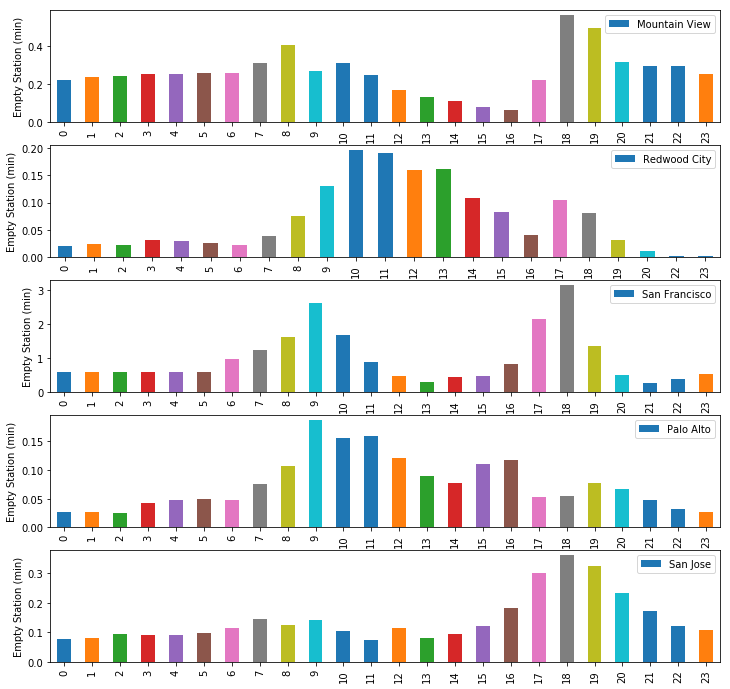

In [135]:
# Plot empty station events per station per hour.
region_count = 1
plt.figure(figsize=(12, 12))
for region in region_hour_BDay.index.levels[0]:
    plt.subplot(5, 1, region_count) 
    
    # Show the minutes count per station   
    (region_hour_BDay[region] / station_num_dict[region]).plot.bar(label=region_names[region]) 
    
    plt.ylabel('Empty Station (min)')
    plt.xlabel('')
    plt.legend()
    region_count += 1

# When are stations full?

In [136]:
%%time
# Read all the status data that have zero docks available.
conn = sqlite3.connect('/home/venkatraman/Downloads/sf-bay-area-bike-share/database.sqlite')
cursor = conn.cursor()
station_full = pd.read_sql_query(f"SELECT * FROM status WHERE docks_available = 0 ORDER BY time", con=conn)
conn.close()

CPU times: user 3.88 s, sys: 2.25 s, total: 6.13 s
Wall time: 6.35 s


In [137]:
# The ratio of station full over empty
len(station_full) / len(no_bikes)

0.6175359732629621

In [138]:
station_full['datetime'] = pd.to_datetime(station_full.time)
station_full['date'] = station_full.datetime.apply(lambda x: x.date())
station_full['hour'] = station_full.time.apply(lambda x: int(x.split()[1].split(':')[0])) # Get the hours in a day.

In [139]:
# Assign the regions to stations.
station_full['station_region'] = None
station_full_region_dict = {} # Initiate a dictionary from the region code to stations.
station_num_dict = {}
group_id = 0

for group in id_groups:
    region_code = region_dict[group_id]
    region_idx = station_full.station_id.isin(group)
    
    station_full_region_dict[region_code] = group    
    station_num_dict[region_code] = len(group)
    
    station_full.loc[region_idx, 'station_region'] = region_code
    group_id += 1

In [140]:
# Calculate the full minutes per hour per region in a single day.
number_of_days = len(station_full.date.unique())

region_hour_full = station_full.groupby(['station_region', 'hour'])['bikes_available'].count() / number_of_days

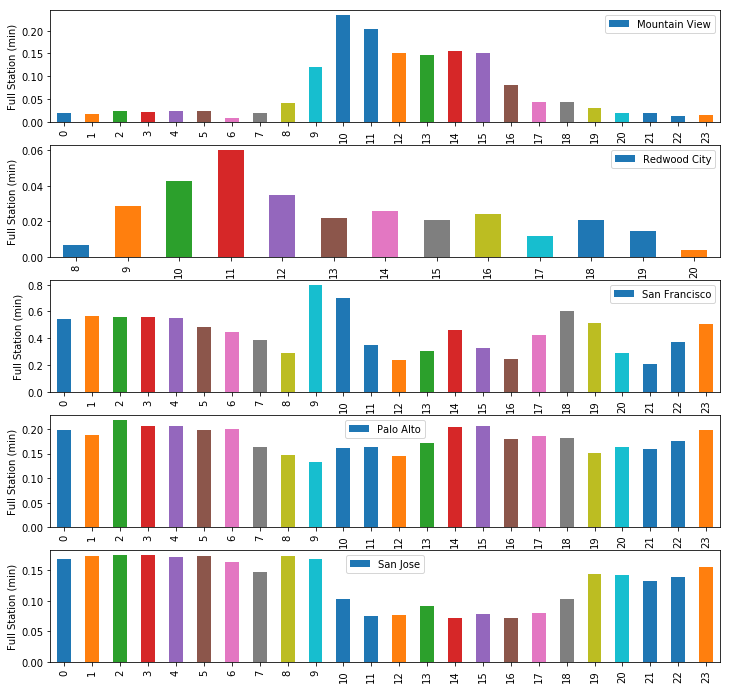

In [141]:
# Plot full station events per station per hour.
region_count = 1
plt.figure(figsize=(12, 12))
for region in region_hour_full.index.levels[0]:
    plt.subplot(5, 1, region_count) 
    
    # Show the minutes count per station   
    (region_hour_full[region] / station_num_dict[region]).plot.bar(label=region_names[region]) 
    
    plt.ylabel('Full Station (min)')
    plt.xlabel('')
    plt.legend()
    region_count += 1

# Check whether status has NaN values

In [142]:
# Status data don't have nan values.
status.isnull().sum()

station_id         0
bikes_available    0
docks_available    0
time               0
dock_count         0
total              0
hour               0
datetime           0
date               0
weekday            0
bike_diff          1
dtype: int64

# Exploration on 'weather' data

In [144]:
weather.head(1)

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107


In [145]:
weather.shape

(3665, 24)

# Explore the precipitation column

In [146]:
# Precipitation column is not numeric!!
precip = weather.precipitation_inches
precip.dtype

dtype('O')

In [147]:
# Show unique values in precipitation data
precip.unique()

array(['0', '0.23', 'T', '0.01', '0.28', '0.63', '0.29', '0.06', '0.85',
       '0.09', '0.64', '0.42', '0.35', '0.43', '0.22', '0.74', '0.03',
       '0.12', '0.16', '0.49', '0.17', '0.08', '0.04', '0.53', '0.07',
       '0.02', '0.83', '1.06', '1.71', '0.37', '0.27', '0.45', '0.78',
       '0.88', '0.66', '0.47', '0.1', '0.61', '0.14', '0.05', '0.68',
       '0.97', '0.26', '0.15', '0.87', '0.57', '0.69', '0.32', '0.21',
       '0.24', '0.52', '0.36', '0.33', '0.25', '0.11', '0.2', '1.18',
       '1.43', '3.12', '0.48', '0.19', '1.09', '0.65', '0.13', '0.91',
       '0.99', '0.18', '0.4', '1.07', nan, '0.41', '0.34', '1.25', '1.85',
       '3.36', '0.71', '1.3', '0.72', '0.6', '0.51', '1.2', '1.28', '3.23',
       '0.55', '1.26', '0.39'], dtype=object)

In [148]:
print('{:.2}% of the weather data are labeled "T" for precipitation.'.format(len(weather[precip=='T'])/len(weather) * 100))
print('{:.2}% of the weather data are labeled "nan" for precipitation.'.format(len(weather[precip.isnull()])/len(weather) * 100))

3.9% of the weather data are labeled "T" for precipitation.
0.027% of the weather data are labeled "nan" for precipitation.


The following is quoted from http://www.nws.noaa.gov/om/csd/info/NOWdata/FAQ.php:

    Looking at daily data, some dates have an "M" or a &"T" in the field. What does this mean?

    "M" stands for "Missing". Data for an element will be missing if the primary sensor for that weather element is inoperable (e.g., has an outage) or malfunctioning (e.g., producing errant data) AND any collocated backup sensor is also inoperable or malfunctioning. "T" stand for "Trace". This is a small amount of precipitation that will wet a raingage but is less than the 0.01 inch measuring limit.

Thus, it is reasonable to assign a small value to 'T', 0.005 inches for example.


In [149]:
weather.loc[precip=='T', 'precipitation_inches'] = 0.005

In [150]:
# Only one entry contains NaN value. This will be kept to analyze later after the merge into the complete datasets.
weather[precip.isnull()]

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
2911,8/8/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94301


In [151]:
weather.precipitation_inches = weather.precipitation_inches.astype('float')
print(weather.precipitation_inches.dtype)

float64


# Deal with NaN values in numeric columns

In [152]:
# Summarize the number of NaNs in each column.
weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

For weather parameters, the best guess can be the average value of the adjacent days. One can argue that the weather may abruptly change during these days, but an assumption of some mild change is still better than just deleting the whole row. However, the max_gust_speed_mph needs to be investigated independently as there are too many nan values.

In [153]:
# Function from more_itertools.consecutive_groups
# https://more-itertools.readthedocs.io/en/latest/api.html#more_itertools.consecutive_groups
from itertools import groupby
from operator import itemgetter

def consecutive_groups(iterable, ordering=lambda x: x):
    """Yield groups of consecutive items using :func:`itertools.groupby`.
    The *ordering* function determines whether two items are adjacent by
    returning their position.
    By default, the ordering function is the identity function. This is
    suitable for finding runs of numbers:
        >>> iterable = [1, 10, 11, 12, 20, 30, 31, 32, 33, 40]
        >>> for group in consecutive_groups(iterable):
        ...     print(list(group))
        [1]
        [10, 11, 12]
        [20]
        [30, 31, 32, 33]
        [40]
    For finding runs of adjacent letters, try using the :meth:`index` method
    of a string of letters:
        >>> from string import ascii_lowercase
        >>> iterable = 'abcdfgilmnop'
        >>> ordering = ascii_lowercase.index
        >>> for group in consecutive_groups(iterable, ordering):
        ...     print(list(group))
        ['a', 'b', 'c', 'd']
        ['f', 'g']
        ['i']
        ['l', 'm', 'n', 'o', 'p']
    """
    for k, g in groupby(
        enumerate(iterable), key=lambda x: x[0] - ordering(x[1])
    ):
        yield map(itemgetter(1), g)

In [154]:
def replace_nan(data, col):
    col_nan = data.loc[data[col].isnull(), col] # Get the nan entries of the specified column
    nan_idx = col_nan.index # Get the index of the col_nan
    
    # Group adjacent indices from col_nan_idx according to the method from the following link:
    # https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list
    for group in consecutive_groups(nan_idx):
        col_idx = list(group)
        
        # Set the mean of the adjacent six values as the value for the NaN
        weather.loc[col_idx, col] = weather.loc[(col_idx[0]-3):(col_idx[-1]+3), col].mean()

In [155]:
# The replace_nan function will be applied to all numeric columns except the gust column
nan_cols = ['max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees']

In [156]:
for col in nan_cols:
    replace_nan(weather, col)

Quoted from the following link: http://www.differencebetween.net/science/nature/difference-between-gust-and-wind/

    A gust is a sudden increase of the wind’s speed that lasts no more than 20 seconds.

The max gust speed should be highly correlated with the max wind speed.


In [157]:
# If the gust data is missing, it should mean that there is no gust.
# This is somewhat confirmed by the fact that there is no gust value of 0 in the data.
weather.loc[weather.max_gust_speed_mph == 0, 'max_gust_speed_mph']

Series([], Name: max_gust_speed_mph, dtype: float64)

In [158]:
weather.max_gust_speed_mph.fillna(0, inplace=True) # Replace all the nan values in gust data with 0.

In [159]:
weather.isnull().sum()

date                                 0
max_temperature_f                    0
mean_temperature_f                   0
min_temperature_f                    0
max_dew_point_f                      0
mean_dew_point_f                     0
min_dew_point_f                      0
max_humidity                         0
mean_humidity                        0
min_humidity                         0
max_sea_level_pressure_inches        0
mean_sea_level_pressure_inches       0
min_sea_level_pressure_inches        0
max_visibility_miles                 0
mean_visibility_miles                0
min_visibility_miles                 0
max_wind_Speed_mph                   0
mean_wind_speed_mph                  0
max_gust_speed_mph                   0
precipitation_inches                 0
cloud_cover                          0
events                            3143
wind_dir_degrees                     0
zip_code                             0
dtype: int64

# Find the correlations between features.

The weather data have too many feature columns, some seeming to be correlated. To fight against the curse of dimensionality, the strongly correlated columns will be filtered out.

In [160]:
# Create a correlation table between all the features.
weather_corr_table = weather.corr(method='pearson', min_periods=1)

display(weather_corr_table)

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code
max_temperature_f,1.000000,0.911044,0.642260,0.595012,0.505098,0.397487,-0.216879,-0.370503,-0.417841,-0.439687,...,0.117971,0.255346,0.340895,0.085911,0.066185,-0.040446,-0.133768,-0.307077,0.218432,0.110797
mean_temperature_f,0.911044,1.000000,0.895594,0.761181,0.725137,0.638972,-0.128456,-0.153018,-0.139305,-0.576732,...,0.146534,0.232811,0.260410,0.176291,0.284251,0.013383,-0.073244,-0.040235,0.168688,0.051660
min_temperature_f,0.642260,0.895594,1.000000,0.798905,0.824766,0.780979,-0.019031,0.118853,0.196733,-0.616909,...,0.154295,0.165006,0.121248,0.240507,0.447016,0.068079,0.005624,0.250999,0.091723,-0.049166
max_dew_point_f,0.595012,0.761181,0.798905,1.000000,0.943105,0.842477,0.382153,0.402734,0.342451,-0.508217,...,0.164558,0.097181,-0.033532,0.152299,0.233341,-0.034887,0.051436,0.201694,0.111538,-0.072593
mean_dew_point_f,0.505098,0.725137,0.824766,0.943105,1.000000,0.952300,0.414804,0.502307,0.491508,-0.535617,...,0.168403,0.076285,-0.049897,0.168825,0.316432,0.002301,0.052520,0.310847,0.085541,-0.053296
min_dew_point_f,0.397487,0.638972,0.780979,0.842477,0.952300,1.000000,0.386314,0.550241,0.585639,-0.503820,...,0.141436,0.056657,-0.049911,0.149080,0.323991,0.005118,0.046376,0.354173,0.047458,-0.061171
max_humidity,-0.216879,-0.128456,-0.019031,0.382153,0.414804,0.386314,1.000000,0.787834,0.535602,-0.005124,...,-0.024105,-0.243392,-0.424447,-0.046738,-0.045741,-0.072192,0.137592,0.320823,-0.054455,0.021128
mean_humidity,-0.370503,-0.153018,0.118853,0.402734,0.502307,0.550241,0.787834,1.000000,0.870298,-0.057553,...,-0.057358,-0.293365,-0.468310,-0.020438,0.014216,-0.038198,0.168503,0.515528,-0.103110,-0.177231
min_humidity,-0.417841,-0.139305,0.196733,0.342451,0.491508,0.585639,0.535602,0.870298,1.000000,-0.095147,...,0.036518,-0.214135,-0.410531,0.075143,0.203540,0.048904,0.180549,0.601872,-0.135133,-0.171353
max_sea_level_pressure_inches,-0.439687,-0.576732,-0.616909,-0.508217,-0.535617,-0.503820,-0.005124,-0.057553,-0.095147,1.000000,...,-0.115323,-0.127162,-0.090063,-0.253412,-0.395362,-0.140740,-0.132514,-0.144374,-0.025768,-0.025516


Quoted from this link http://janda.org/c10/Lectures/topic06/L24-significanceR.htm:

    For large samples, it is easy to achieve significance, and one must pay attention to the strength of the correlation to determine if the relationship explains very much.

So the strength of the correlation is more important for the bikeshare data.

In [161]:
r_squared = 0.5 # Set the coefficient of determination to be 0.5 so that more than half of the variance can be explanable.

# Obtain the correlated features.
weather_corr = []
for col in weather_corr_table.columns:
    feature = weather_corr_table[col]
    corr_cols = feature[(feature.pow(2) > r_squared) & (feature != 1)]
    corr_idx = corr_cols.index.values.tolist()
    corr_dict = {col: corr_idx}
    if corr_idx != []:
        weather_corr.append(corr_dict)

In [162]:
display(weather_corr)

[{'max_temperature_f': ['mean_temperature_f']},
 {'mean_temperature_f': ['max_temperature_f',
   'min_temperature_f',
   'max_dew_point_f',
   'mean_dew_point_f']},
 {'min_temperature_f': ['mean_temperature_f',
   'max_dew_point_f',
   'mean_dew_point_f',
   'min_dew_point_f']},
 {'max_dew_point_f': ['mean_temperature_f',
   'min_temperature_f',
   'mean_dew_point_f',
   'min_dew_point_f']},
 {'mean_dew_point_f': ['mean_temperature_f',
   'min_temperature_f',
   'max_dew_point_f',
   'min_dew_point_f']},
 {'min_dew_point_f': ['min_temperature_f',
   'max_dew_point_f',
   'mean_dew_point_f']},
 {'max_humidity': ['mean_humidity']},
 {'mean_humidity': ['max_humidity', 'min_humidity']},
 {'min_humidity': ['mean_humidity']},
 {'max_sea_level_pressure_inches': ['mean_sea_level_pressure_inches',
   'min_sea_level_pressure_inches']},
 {'mean_sea_level_pressure_inches': ['max_sea_level_pressure_inches',
   'min_sea_level_pressure_inches']},
 {'min_sea_level_pressure_inches': ['max_sea_level_pre

It turns out that:

    'mean_temperature_f' can well represent 'max_temperature_f', 'min_temperature_f', 'max_dew_point_f' and 'mean_dew_point_f', but not 'min_dew_point_f';
    'mean_humidity' can well represent 'max_humidity' and 'min_humidity';
    'mean_sea_level_pressure_inches' can well represent 'max_sea_level_pressure_inches' and 'min_sea_level_pressure_inches'.

All dependent features will be removed to reduce the dimension of the data.


In [163]:
# Explore the categorical column
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [164]:
weather.loc[weather.events == 'rain', 'events'] = 'Rain'
print(weather.events.unique())

[nan 'Fog' 'Rain' 'Fog-Rain' 'Rain-Thunderstorm']


In [165]:
# Create a weather data with independent columns and ONEHOT the events column.
weather_ind = pd.get_dummies(weather.drop(labels=['max_temperature_f', 'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f', 'max_humidity', 'min_humidity', 'max_sea_level_pressure_inches', 'min_sea_level_pressure_inches'], axis=1), columns=['events'])

# It is strange to find low correlation between the max wind speed and the max gust speed. In fact, this depends on the region:

In [168]:
print('The correlation between the max wind speed and the max gust speed is: \n')
for region in regions:
    regionWeather = weather[weather.zip_code == region]
    corrCoef = pearsonr(regionWeather.max_wind_Speed_mph, regionWeather.max_gust_speed_mph)[0]
    print('{} : {:.2f}'.format(region_names[region], corrCoef))

The correlation between the max wind speed and the max gust speed is: 

San Francisco : 0.75
Redwood City : 0.39
Palo Alto : 0.07
Mountain View : 0.51
San Jose : 0.90


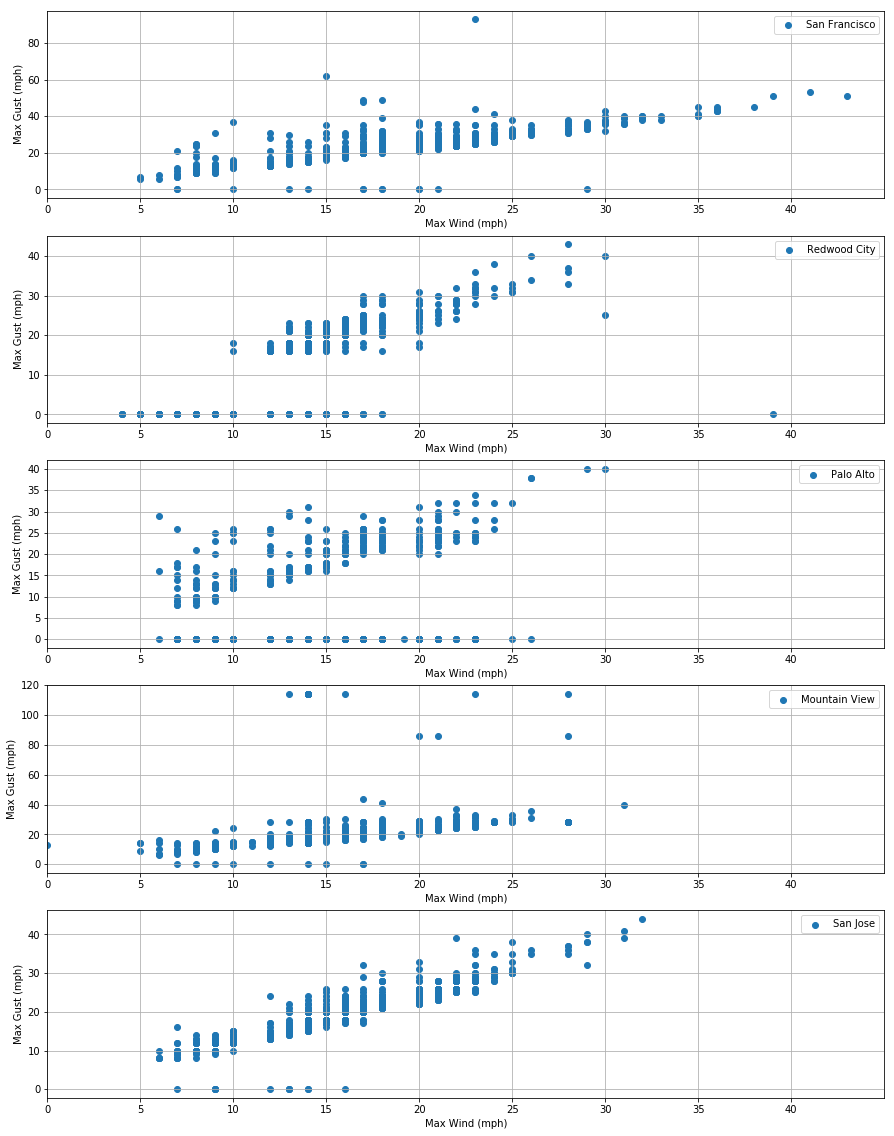

In [169]:
plot_count = 1
plt.figure(figsize=(15, 20))
for region in regions:
    weather_region = weather.loc[weather.zip_code == region, :]
    plt.subplot(5, 1, plot_count)
    plt.scatter(weather_region.max_wind_Speed_mph, 
                weather_region.max_gust_speed_mph, 
                label='{}'.format(region_names[region]))
    plt.xticks(np.arange(0, 45, 5))
    plt.xlim([0, 45])
    plt.xlabel('Max Wind (mph)')
    plt.ylabel('Max Gust (mph)')
    plot_count += 1
    plt.legend()
    plt.grid()

Interestingly, the correlation is actually high for San Francisco and San Jose while very low for the other three cities with the latter sitting in the deep valley close by the mountain and the bay.

# Simplify the column names.

In [170]:
weather_ind.columns

Index(['date', 'mean_temperature_f', 'min_dew_point_f', 'mean_humidity',
       'mean_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees', 'zip_code', 'events_Fog',
       'events_Fog-Rain', 'events_Rain', 'events_Rain-Thunderstorm'],
      dtype='object')

In [171]:
weather_ind.columns= ['date', 'Temp', 'Dew', 'Humid', 'Pressure', 'Max_Vis', 'Mean_Vis', 'Min_Vis', 'Max_Wind', 'Mean_Wind', 'Gust', 'Precip', 'Cloud', 'Wind_Deg',  'zip_code', 'Fog', 'Fog_Rain', 'Rain', 'Thunder']

In [172]:
weather_ind.head(1)

,date,Temp,Dew,Humid,Pressure,Max_Vis,Mean_Vis,Min_Vis,Max_Wind,Mean_Wind,Gust,Precip,Cloud,Wind_Deg,zip_code,Fog,Fog_Rain,Rain,Thunder
0,8/29/2013,68.0,56.0,75.0,30.02,10.0,10.0,10.0,23.0,11.0,28.0,0.0,4.0,286.0,94107,0,0,0,0


# Explore monthly variations for the features.

In [174]:
# Previous exploration suggests that the wind degree column has an outlier point. I will correct this point before making the plots.
weather_ind[weather_ind.Wind_Deg > 360]

,date,Temp,Dew,Humid,Pressure,Max_Vis,Mean_Vis,Min_Vis,Max_Wind,Mean_Wind,Gust,Precip,Cloud,Wind_Deg,zip_code,Fog,Fog_Rain,Rain,Thunder
216,9/30/2013,66.0,41.0,73.0,30.05,10.0,10.0,9.0,14.0,4.0,17.0,0.0,4.0,2772.0,94063,0,0,0,0


In [175]:
# This seems to be a typo with an extra '7' in the middle.
weather_ind.loc[weather_ind.Wind_Deg > 360, 'Wind_Deg'] = 272

In [176]:
weather_month = weather_ind.date.apply(lambda x: int(x.split('/')[0]))

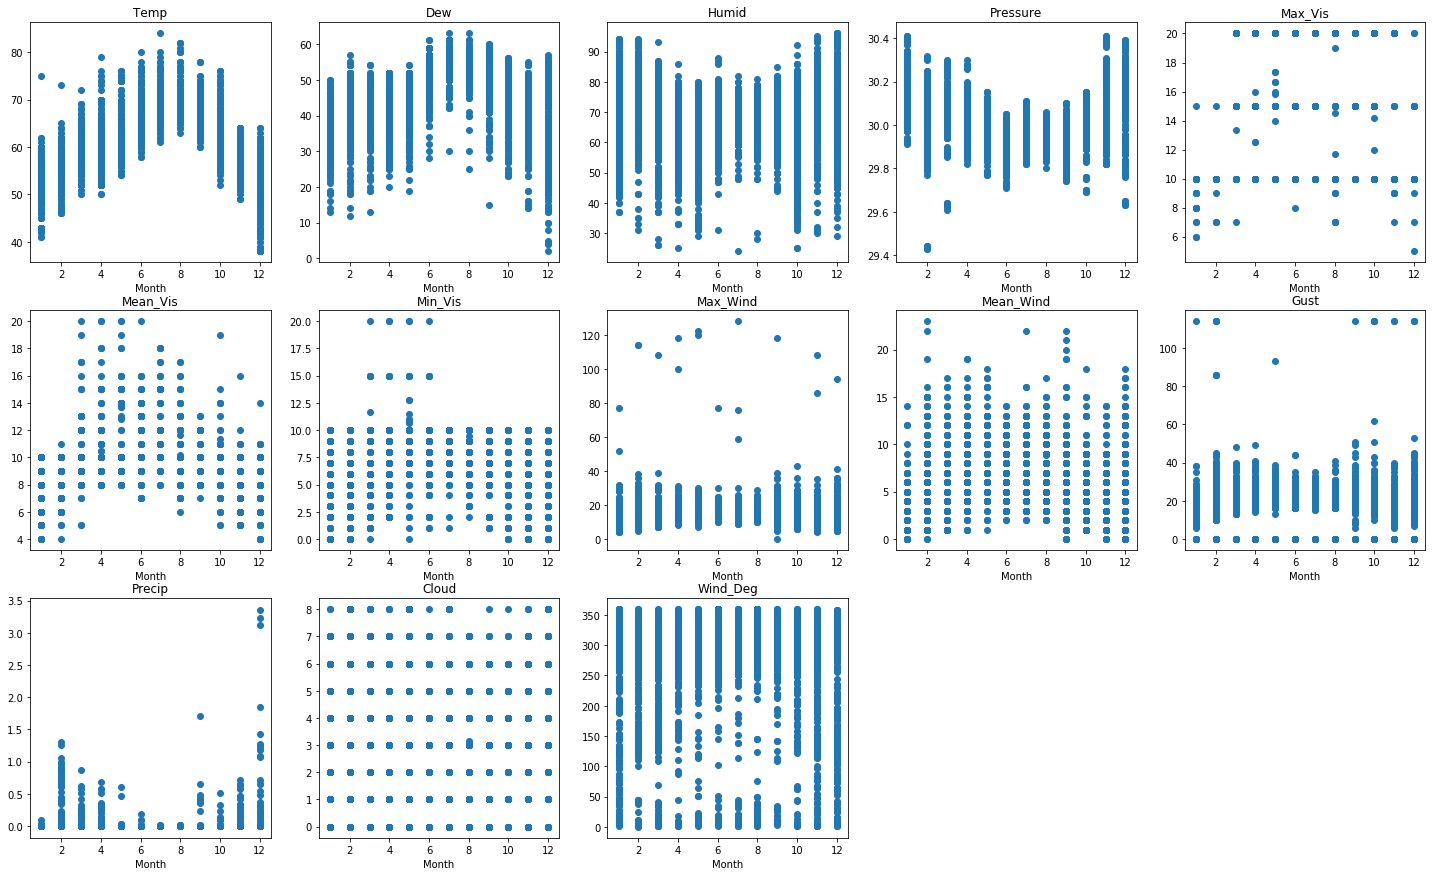

In [177]:
# Plot all the numeric feature columns versus months
plot_cols = weather_ind.columns[1:14]

plt.figure(figsize=(25, 15))
plot_idx = 1
for col in plot_cols:
    plt.subplot(3, 5, plot_idx)
    plt.scatter(weather_month, weather_ind[col])
    plt.xlabel('Month')
    plt.title(col)
    plot_idx += 1

The above features don't show significant dependence on each other. This is obvious by looking at the point patterns. Some features have obvious seasonal changes, like the temperature, the dew point, the sea level pressure, the precipitation; some are less variable in seasons, like the visibility, the wind speed, gust speeds and the wind degrees; the others are not dependent on the season, like the cloud cover. No matter what, I feel all these features will affect people's choice in bike riding, so all will be kept for analysis.

# Convert the date to datetime format.

In [178]:
# The conversion is necessary for the combination with other data
weather_ind.date = weather_ind.date.apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

Drop columns that are not relevant for the datasets:

    'id'. Trip id is unique for a specific trip. It doesn't contain any trip pattern.
    'start_date' and 'end_date'. The previously generated 'date' and 'hour' contain the relevant information already.
    'start_station_id', 'start_station_name', 'end_station_id' and 'end_station_name'. The station groups will be used instead to reduce the complexity of the problem, which reflects the essence of the problem.
    'zip_code'. The useful information has been extracted into the column 'local_zip'.
    'bike_id'. Bike id should not be an important factor as all the sharebikes look and function similarly.



# Pretreatment of the trip data

In [179]:
trip.columns

Index(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'zip_code', 'station_region',
       'inter_group', 'hour', 'date', 'BDay', 'weekday', 'month', 'local_zip',
       'before_Oct2013'],
      dtype='object')

In [180]:
# Drop columns that not relevant for both datasets.
drop_cols = ['id', 'start_date', 'start_station_name', 'start_station_id', 'end_date', 'end_station_name', 'end_station_id', 'bike_id', 'zip_code']
trip_use = trip.drop(drop_cols, axis=1)

In [181]:
print(trip_use.shape)
trip_use.head(1)

(669959, 11)


,duration,subscription_type,station_region,inter_group,hour,date,BDay,weekday,month,local_zip,before_Oct2013
0,63,Subscriber,94107,0,14,2013-08-29,True,3,8,True,True


# Define valid trips.

In [182]:
# Only consider durations less than 12 hours as valid trips.
duration_12hours = 60*60*12
trip_final = trip_use[trip_use.duration <= duration_12hours]

In [183]:
print('{:.1f}% of trips are within 12 hours.'.format(len(trip_final) / len(trip_use) * 100))

99.8% of trips are within 12 hours.


In [184]:
trip_final.isnull().sum()

duration             0
subscription_type    0
station_region       0
inter_group          0
hour                 0
date                 0
BDay                 0
weekday              0
month                0
local_zip            0
before_Oct2013       0
dtype: int64

# Investigate the weather data.

In [185]:
print(weather_ind.shape)
weather_ind.head(1)

(3665, 19)


,date,Temp,Dew,Humid,Pressure,Max_Vis,Mean_Vis,Min_Vis,Max_Wind,Mean_Wind,Gust,Precip,Cloud,Wind_Deg,zip_code,Fog,Fog_Rain,Rain,Thunder
0,2013-08-29,68.0,56.0,75.0,30.02,10.0,10.0,10.0,23.0,11.0,28.0,0.0,4.0,286.0,94107,0,0,0,0


In [186]:
weather_ind.isnull().sum()

date         0
Temp         0
Dew          0
Humid        0
Pressure     0
Max_Vis      0
Mean_Vis     0
Min_Vis      0
Max_Wind     0
Mean_Wind    0
Gust         0
Precip       0
Cloud        0
Wind_Deg     0
zip_code     0
Fog          0
Fog_Rain     0
Rain         0
Thunder      0
dtype: int64

# 1. Dataset for Regression

In [187]:
trip_final.columns

Index(['duration', 'subscription_type', 'station_region', 'inter_group',
       'hour', 'date', 'BDay', 'weekday', 'month', 'local_zip',
       'before_Oct2013'],
      dtype='object')

The goal of tackling the problem for the daily trip counts is to predict the daily trips in the future. Thus, only those features that we know in advance or can be forecast in the future will be used. Anything that is related to the statistics of the trips during the day is not appropriate as the feature, e.g. the average duration of the trips, the ratio of subscribers over non-subscribers, the frequency of inter-group trips, the number of people that comes from a local zip code, etc. On the contrast, a specific date in the future has the following information known beforehand: the year, month, day, whether it is a business day and before October 2013, which weekday it is. However, one needs to be careful when using the year information. Since we are predicting the future, the year may either be irrelevant or can leak information from the test set to the training set. So I decide not to include the year as a feature for the regression.


In [188]:
trip_rgs = trip_final[['date', 'station_region', 'hour', 'month', 'BDay', 'weekday', 'before_Oct2013']]

In [189]:
trip_rgs.head()

,date,station_region,hour,month,BDay,weekday,before_Oct2013
0,2013-08-29,94107,14,8,True,3,True
1,2013-08-29,95113,14,8,True,3,True
2,2013-08-29,94041,10,8,True,3,True
3,2013-08-29,95113,11,8,True,3,True
4,2013-08-29,94107,12,8,True,3,True


# Five datasets for regression will be created for different regions / station groups.

In [190]:
# Define a function to be used in the below cell.
def region_weather_trips(data, weather):
    region_data = data.groupby('date')['BDay', 'weekday', 'month', 'before_Oct2013'].median()
    region_data['trip_counts'] = data.groupby('date')['hour'].count()   
    region_data.columns=['BDay', 'weekday', 'month', 'before_Oct2013', 'trip_counts']
    # region_data.rename(columns={'median': 'BDay', 'count': 'trip_counts'}, inplace=True)
    
    # Merge the region data with weather data. The inner join is used as some dates may not be in the region data and the weather data of the missing dates shouldn't be included in the merged data.
    region_weather_merge = pd.merge(region_data, weather, left_index=True, right_on='date') 
    region_weather_merge.set_index('date', inplace=True) # Set the date as the index after merging
    region_weather_merge.drop('zip_code', axis=1, inplace=True)
    
    return region_weather_merge

In [197]:
# Generate five datasets as a dictionary with the zip code as the key.
trip_count_rgs = {}
for group in regions:
    region = trip_rgs[trip_rgs.station_region == group].drop('station_region', axis=1) # Obtain region by zip code
    region_weather = weather_ind[weather_ind.zip_code == group] # Obtain region weather by zip code
    
    region_daily = region_weather_trips(region, region_weather)
    region_am = region_weather_trips(region[region.hour < 13], region_weather)
    region_pm = region_weather_trips(region[region.hour > 12], region_weather)
    
    trip_count_rgs[group] = [region_daily, region_am, region_pm]
    
    # Use OneHot for both the weekday and the month as both columns are actually categorical features rather than numeric features. This may not affect the decision tree algorithms, but will help with the linear regression algorithms.
    #trip_count_rgs[group] = pd.get_dummies(region_daily, columns=['weekday', 'month'])
    #trip_count_rgs[group] = region_daily

In [198]:
len(trip_count_rgs)

5

In [199]:
# Some regions don't have data for all dates. There are totally 733 days. This also confirms the inner merge.
print(len(trip_count_rgs[94041][0]))
print(len(trip_count_rgs[95113][0]))
print(len(weather)//5) # Five regions.

725
733
733


#  Add the total dock counts for each day. The number of total counts is an important parameter for trip count prediction.

In [200]:
# Convert the installation date to datetime object
station.installation_date = pd.to_datetime(station.installation_date, format = "%m/%d/%Y").dt.date

In [201]:
# Calculate the total dock counts for each region on each day
# The count_docks function is used to map the date (index) to the total docks.
def count_docks(date):
    return sum(s_group[s_group.installation_date <= date].dock_count)

for region, group in trip_count_rgs.items():
    s_group = station[station.region == region]
    group[0]['total_docks'] = group[0].index.map(count_docks) # group[0] is the daily trip
    group[1]['total_docks'] = group[1].index.map(count_docks) # group[1] is the morning trip
    group[2]['total_docks'] = group[2].index.map(count_docks) # group[2] is the afternoon trip

# 2. Dataset for Classification

In [202]:
trip_final.head(1)

,duration,subscription_type,station_region,inter_group,hour,date,BDay,weekday,month,local_zip,before_Oct2013
0,63,Subscriber,94107,0,14,2013-08-29,True,3,8,True,True


In [203]:
weather_ind.head(1)

,date,Temp,Dew,Humid,Pressure,Max_Vis,Mean_Vis,Min_Vis,Max_Wind,Mean_Wind,Gust,Precip,Cloud,Wind_Deg,zip_code,Fog,Fog_Rain,Rain,Thunder
0,2013-08-29,68.0,56.0,75.0,30.02,10.0,10.0,10.0,23.0,11.0,28.0,0.0,4.0,286.0,94107,0,0,0,0


In [204]:
# Merge the trip and weather data based on the date and the region.
trip_weather_merge = pd.merge(trip_final, weather_ind, left_on=['date', 'station_region'], right_on=['date', 'zip_code'])

In [205]:
# Check the sizes of the data before and after merge
print(trip_final.shape)
print(weather_ind.shape)
print(trip_weather_merge.shape)

(668778, 11)
(3665, 19)
(668778, 29)


The merge makes sense: the total number of rows is the same as the trip data. Also, the number of columns equals to the sum of trip and weather data's minus one (same column name for the date, different columns names for the region).

In [206]:
# Remove the date column. All features about a day have been extracted, so the date itself is not relevant.
# Remove the zip_code column as it is a redundant column as the station_region column.
trip_weather_merge.drop(['date', 'zip_code'], axis=1, inplace=True)

In [207]:
# Create the dataset for classfication problem
subscriber_cls = pd.get_dummies(trip_weather_merge, columns=['station_region'])

In [208]:
print('{} rows of the classification data contain the NaN values.'.format(len(subscriber_cls[subscriber_cls.isnull().any(axis=1)])))

0 rows of the classification data contain the NaN values.


# Modeling and Fitting

# 1. Regression Problem for Daily Trip Counts Prediction


In [209]:
trip_rgs.head()

,date,station_region,hour,month,BDay,weekday,before_Oct2013
0,2013-08-29,94107,14,8,True,3,True
1,2013-08-29,95113,14,8,True,3,True
2,2013-08-29,94041,10,8,True,3,True
3,2013-08-29,95113,11,8,True,3,True
4,2013-08-29,94107,12,8,True,3,True


In [210]:
# Show an example of a full dataset in a region with data of daily trip counts.
trip_count_rgs[94107][0].head(1)

,BDay,weekday,month,before_Oct2013,trip_counts,Temp,Dew,Humid,Pressure,Max_Vis,...,Mean_Wind,Gust,Precip,Cloud,Wind_Deg,Fog,Fog_Rain,Rain,Thunder,total_docks
date,,,,,,,,,,,,,,,,,,,,,
2013-08-29,True,3,8,True,639,68.0,56.0,75.0,30.02,10.0,...,11.0,28.0,0.0,4.0,286.0,0,0,0,0,650


In [211]:
# Display the regions in the datasets.
print(trip_count_rgs.keys())

dict_keys([94107, 94063, 94301, 94041, 95113])


In [212]:
region_names[94107]

'San Francisco'

# 1.1 Predict the number of daily trips for each station

In [213]:
# A function to predict the label with a certain regressor
def rgs_pred(trip_data, rgs):
    features = trip_data.drop('trip_counts', axis=1)
    counts = trip_data.trip_counts
    
    trainX = features.loc[X_train.index]
    trainY = counts.loc[y_train.index]
    testX = features.loc[X_test.index]
    
    rgs.fit(trainX, trainY)
    
    return rgs.predict(testX)

In [218]:
# This regressor is the one found to have the best performance.
gbr = GradientBoostingRegressor(learning_rate = 0.3,
                                n_estimators = 50,
                                max_depth = 8,
                                min_samples_leaf = 3,
                                random_state = random_state)

for region in regions:
    region_trips = trip_count_rgs[region][0]
    
    region_features = region_trips.drop('trip_counts', axis=1)
    region_counts = region_trips.trip_counts
    
    X_train, X_test, y_train, y_test = train_test_split(region_features, region_counts, test_size=0.2, random_state=random_state)
    
    y_pred = rgs_pred(region_trips, gbr)
    median_daily_trips = np.median(y_train)
    y_benchmark = np.ones(len(y_test)) * median_daily_trips
    average_total_docks = np.mean(X_train.total_docks)
    
    print('For {} (median {:.0f} trips daily with {:.0f} docks):'.format(region_names[region], median_daily_trips, average_total_docks))
    print('The median absolute error for the regular prediction is {:.1f}.'.format(median_absolute_error(y_test, y_pred)))
    print('The median absolute error for the benchmark prediction is {:.1f}. \n'.format(median_absolute_error(y_test, y_benchmark)))
    # print('The root mean square logarithmic error is {:.1f}%.'.format(np.sqrt(mean_squared_log_error(y_test, y_pred))*100))
    # print('The root mean square logarithmic error is {:.1f}%. \n\n'.format(np.sqrt(mean_squared_log_error(y_test, y_benchmark))*100))

For San Francisco (median 917 trips daily with 662 docks):
The median absolute error for the regular prediction is 56.8.
The median absolute error for the benchmark prediction is 260.0. 

For Redwood City (median 4 trips daily with 113 docks):
The median absolute error for the regular prediction is 2.2.
The median absolute error for the benchmark prediction is 2.0. 

For Palo Alto (median 9 trips daily with 75 docks):
The median absolute error for the regular prediction is 3.1.
The median absolute error for the benchmark prediction is 3.0. 

For Mountain View (median 26 trips daily with 112 docks):
The median absolute error for the regular prediction is 3.9.
The median absolute error for the benchmark prediction is 13.5. 

For San Jose (median 55 trips daily with 257 docks):
The median absolute error for the regular prediction is 9.0.
The median absolute error for the benchmark prediction is 13.0. 



I didn't pay attention to the number of daily trips for each region. This result is astonishing! Except San Francisco, there are so few trips in a day in the other regions. The number of trips in San Francisco is much higher than the docks, while in other cities, not all bikes are used daily! The prediction with the regressor performs even worse than the a random guess (median of the label column in the training set) for those stations with very small median daily trips, i.e. in Redwood City and Palo Alto. The regressor performs much better than the benchmark for the other three cities.

# 1.2 Improve the model for San Francisco trip data

# 1.2.1 Normalize numeric feature columns

In [219]:
# Collect all numeric features in the trip data
trip_num_features = ['weekday', 'month', 'Temp', 'Dew', 'Humid', 'Pressure', 'Max_Vis', 'Mean_Vis', 'Min_Vis', 'Max_Wind', 'Mean_Wind', 'Gust', 'Precip', 'Cloud', 'Wind_Deg', 'total_docks']

In [220]:
# Investigate the trips in San Francisco. The numeric features are normalized to accommodate all the regressors.
trips_SF = trip_count_rgs[94107][0]
features_SF = trips_SF.drop('trip_counts', axis=1)
features_SF[trip_num_features] = MinMaxScaler().fit_transform(features_SF[trip_num_features])
counts_SF = trips_SF.trip_counts

X_train, X_test, y_train, y_test = train_test_split(features_SF, counts_SF, test_size=0.2, random_state=random_state)

# 1.2.2 Select proper models by investigating all regressors

In [221]:
mae_scorer = make_scorer(median_absolute_error, greater_is_better=False) # mae: median absolute error
# Define a clear cross validation set
# Shuffle Split is used instead of KFold. A better method for a small dataset.
cv_sets = ShuffleSplit(n_splits=15, test_size = 0.20, random_state=random_state) 
# cv_sets = KFold(n_splits=15, shuffle=True, random_state=random_state)

In [222]:
def scoring(rgs):
    scores = cross_val_score(rgs, X_train, y_train, cv=cv_sets, n_jobs=1, scoring = mae_scorer)
    return np.mean(scores)

In [225]:
# Check the performance of all regressors with default setting
regressors = [DummyRegressor,
              AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor,
              GaussianProcessRegressor,
              HuberRegressor, Lasso, LinearRegression, PassiveAggressiveRegressor, RANSACRegressor, Ridge, SGDRegressor, TheilSenRegressor,
              KernelRidge,
              KNeighborsRegressor,
              MLPRegressor,
              LinearSVR, NuSVR, SVR,
              DecisionTreeRegressor, ExtraTreeRegressor,
              XGBRegressor]

rgs_dict = {} # Create a regressor dictionary to record the regressor with its score
for rgs in regressors:
    begTime = time() # Get the beginning time
    
    # All parameters are set by default.
    # Unfortunately, not all regressors have a random_state parameter, so each run will give a slightly different ranking.
    try:
        rgs_function = rgs(random_state=random_state) 
    except:
        rgs_function = rgs()
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rgs_error = scoring(rgs_function) * (-1) # Error is opposite of score
        
    rgs_dict[rgs.__name__] = rgs_error
    
    useTime = time() - begTime
    print('The regressor {} takes {:.2f} seconds and has a median absolute error of {:.1f}.'.format(rgs.__name__, useTime, rgs_error))    

The regressor DummyRegressor takes 0.03 seconds and has a median absolute error of 363.9.
The regressor AdaBoostRegressor takes 0.99 seconds and has a median absolute error of 95.2.
The regressor BaggingRegressor takes 0.40 seconds and has a median absolute error of 65.6.
The regressor ExtraTreesRegressor takes 0.29 seconds and has a median absolute error of 65.9.
The regressor GradientBoostingRegressor takes 0.62 seconds and has a median absolute error of 69.2.
The regressor RandomForestRegressor takes 0.39 seconds and has a median absolute error of 65.5.
The regressor GaussianProcessRegressor takes 0.21 seconds and has a median absolute error of 120.0.
The regressor HuberRegressor takes 0.35 seconds and has a median absolute error of 83.0.
The regressor Lasso takes 0.03 seconds and has a median absolute error of 92.0.
The regressor LinearRegression takes 0.03 seconds and has a median absolute error of 92.7.
The regressor PassiveAggressiveRegressor takes 0.03 seconds and has a median 

TheilSenRegressor and MLPRegressor take the longest time to process but not with the best scores.

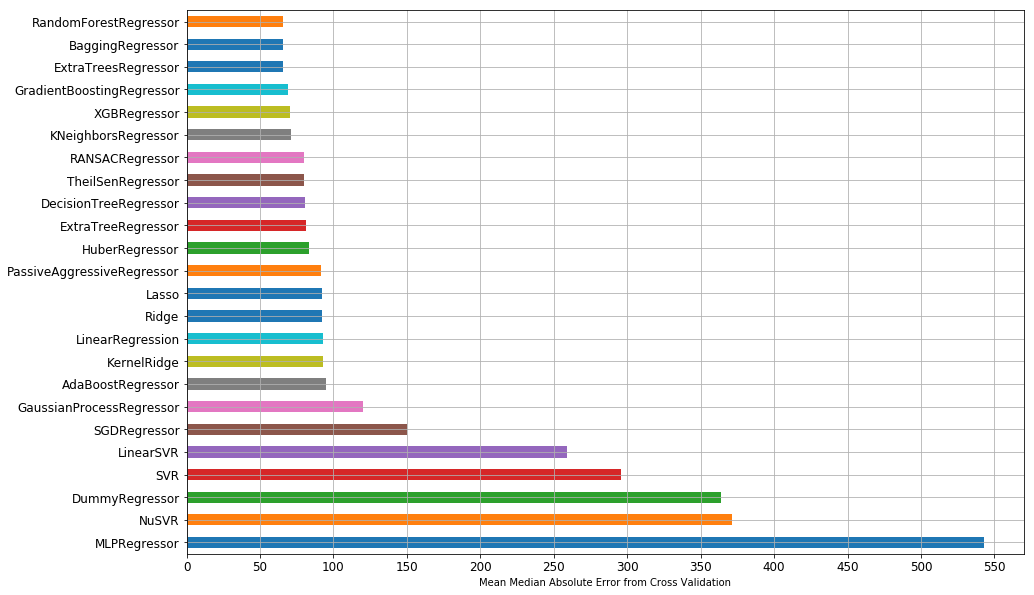

In [226]:
# Plot the scores for all the regressor
pd.Series(rgs_dict).sort_values(ascending=False).plot.barh(figsize=(15, 10), grid=True, fontsize=12)
plt.xticks(np.arange(0, 600, 50))
plt.xlabel('Mean Median Absolute Error from Cross Validation')
plt.show()

For regressors, we can use two benchmark models: the dummy regressor which always predicts the median value of the training set and the plain linear regression mode. Interestingly, some regressors perform worse than the dummy regressor (random guess): NuSVR and MLPRegressor. This doesn't necessarily mean that these two algorithms are not good. It only suggests that the default parameter setting doesn't give the model good performance on this dataset. Similarly, those regressors that have larger error than the linear regression method don't necessarily mean they are bad regressors. It is possible that some regressors have a great potential to improve by adjusting its parameters. However, one cannot explore all the regressors with all possible values of parameters. I will choose investigate further only for three regressors on the top list: Bagging Regressor, Gradient boosting Regressor and Random Forest Regressor. Note that the result may be slightly different for each run, but these three are always on the top list. 

In [227]:
rfr_params = {'n_estimators':[20, 30, 40], 'min_samples_leaf':[1, 2, 3]}
br_params = {'n_estimators':[20, 30, 40], 'max_samples':[0.2, 0.5, 1.0], 'max_features':[0.2, 0.5, 1.0]}
gbr_params = {'learning_rate':[0.02, 0.05, 0.08], 'n_estimators':[150, 200, 250], 'min_samples_leaf':[3, 4, 5], 'max_depth':[8, 9, 10]}

In [228]:
regressors = [RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor] # Note that the regressor needs to be a function rather than the name itself.
rgs_params = [rfr_params, br_params, gbr_params]

best_rgs = {}
for rgs, rgs_params in zip(regressors, rgs_params):
    
    grid = GridSearchCV(estimator = rgs(random_state=random_state), param_grid = rgs_params, scoring = mae_scorer, cv = cv_sets, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    print('It takes {:.1f} seconds to grid search the regressor {}. The median absolute error is {:.1f}.'.format(useTime, rgs.__name__, (-1) * grid.best_score_))
    best_rgs[rgs.__name__] = grid.best_estimator_

Fitting 15 folds for each of 9 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done 120 out of 135 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    2.2s finished


It takes 0.5 seconds to grid search the regressor RandomForestRegressor. The median absolute error is 62.8.
Fitting 15 folds for each of 27 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:    4.2s finished


It takes 0.5 seconds to grid search the regressor BaggingRegressor. The median absolute error is 62.4.
Fitting 15 folds for each of 81 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  1.3min finished


It takes 0.5 seconds to grid search the regressor GradientBoostingRegressor. The median absolute error is 61.3.


In [229]:
best_rgs

{'BaggingRegressor': BaggingRegressor(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=1.0,
          n_estimators=30, n_jobs=1, oob_score=False, random_state=16,
          verbose=0, warm_start=False),
 'GradientBoostingRegressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='ls', max_depth=9, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=5,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=16,
              subsample=1.0, verbose=0, warm_start=False),
 'RandomForestRegressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_s

In [230]:
bestRegressor = best_rgs['GradientBoostingRegressor']

In [231]:
# Predict the daily trips using daily data
bestRegressor.fit(X_train, y_train)
SF_daily_y_pred = bestRegressor.predict(X_test)

print('The median absolute error is {:.1f} with the best estimator using the daily trip data.'.format(median_absolute_error(y_test, SF_daily_y_pred)))

The median absolute error is 54.5 with the best estimator using the daily trip data.


# 1.3 Check if dividing a day into several sections help with the prediction power

Divide by different hours. To predict the number of trips on a particular day, the trip data need to be averaged to certain time sections. From the exploration, I decided to divide the data by the noon point, i.e. one division from 0 am to 12 pm and the other from 1 pm to 11 pm. Aggregating data into certain time slots will make certain feature columns not relevant unless the each element in the feature will be investigated individually (e.g. investigate only the subscriber's behavior or only the non-subscriber's behavior). 

In [232]:
def pred_trip_count(trip_data, bestRegressor, train_index, test_index):
    features = trip_data.drop('trip_counts', axis=1)
    features[trip_num_features] = MinMaxScaler().fit_transform(features[trip_num_features])
    counts = trip_data.trip_counts
    
    trip_X_train = features.loc[train_index]
    trip_y_train = counts.loc[train_index]
    trip_X_test =features.loc[test_index]
    
    bestRegressor.fit(trip_X_train, trip_y_train)
    
    # feature_importance = pd.Series(dict(zip(trip_X_train.columns, bestRegressor.feature_importances_)))
    
    return bestRegressor.predict(trip_X_test), bestRegressor.feature_importances_

In [233]:
SF_am = trip_count_rgs[94107][1]
SF_pm = trip_count_rgs[94107][2]

train_index = X_train.index
test_index = X_test.index

In [234]:
# Predict the daily trips using morning and afternoon data
SF_am_y_pred, SF_am_importance = pred_trip_count(SF_am, bestRegressor, train_index, test_index)
SF_pm_y_pred, SF_pm_importance = pred_trip_count(SF_pm, bestRegressor, train_index, test_index)
SF_ampm_y_pred = SF_am_y_pred + SF_pm_y_pred

In [235]:
# Calculate the median value of the y train as the benchmark prediction
y_pred_benchmark = np.ones(len(y_test)) * y_train.median()

In [236]:
# Check the median absolute error metric.
print('The median absolute error is {:.1f} with the best estimator using the daily trip data.'.format(median_absolute_error(y_test, SF_daily_y_pred)))
print('The median absolute error is {:.1f} with the best estimator using the am+pm trip data.'.format(median_absolute_error(y_test, SF_ampm_y_pred)))
print('The median absolute error is {:.1f} with the benchmark model using the daily trip data.'.format(median_absolute_error(y_test, y_pred_benchmark)))

The median absolute error is 54.5 with the best estimator using the daily trip data.
The median absolute error is 54.2 with the best estimator using the am+pm trip data.
The median absolute error is 260.0 with the benchmark model using the daily trip data.


In [237]:
# Check the root mean square logarithmic error metric.
print('The root mean square logarithmic error is {:.4f} with the best estimator using the daily trip data.'.format(np.sqrt(mean_squared_log_error(y_test, SF_daily_y_pred))))
print('The root mean square logarithmic error is {:.4f} with the best estimator using the am+pm trip data.'.format(np.sqrt(mean_squared_log_error(y_test, SF_ampm_y_pred))))
print('The root mean square logarithmic error is {:.4f} with the benchmark using the daily trip data.'.format(np.sqrt(mean_squared_log_error(y_test, y_pred_benchmark))))

The root mean square logarithmic error is 0.1814 with the best estimator using the daily trip data.
The root mean square logarithmic error is 0.1802 with the best estimator using the am+pm trip data.
The root mean square logarithmic error is 0.6481 with the benchmark using the daily trip data.


# 1.4 Explore the feature importance of the best model for daily, am and pm trips

In [238]:
# daily_importance = pd.Series(dict(zip(X_train.columns, bestRegressor.feature_importances_)))
daily_importance = bestRegressor.feature_importances_

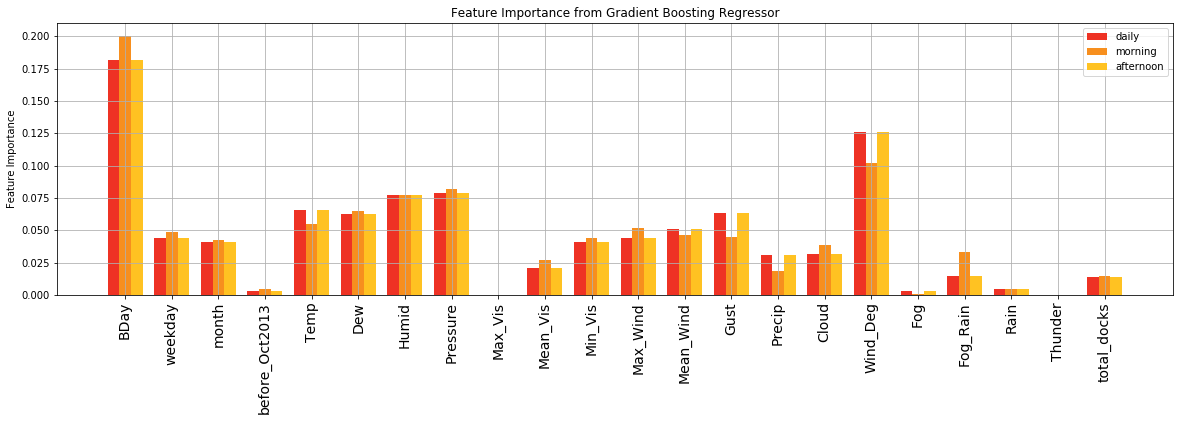

In [239]:
# Plot the feature importances from the daily, am, pm trip models
# Matplotlib code borrowed from: https://chrisalbon.com/python/matplotlib_grouped_bar_plot.html
X_tick_labels = X_train.columns
pos = np.array(range(len(X_tick_labels)))

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
width = 0.25
ax.bar(pos-width, daily_importance, width=width, color='#EE3224', label='daily')
ax.bar(pos, SF_am_importance, width=width, color='#F78F1E', label='morning')
ax.bar(pos+width, SF_pm_importance,width=width,color='#FFC222', label='afternoon')
ax.legend()

# Set the y axis label
ax.set_ylabel('Feature Importance')

# Set the chart's title
ax.set_title('Feature Importance from Gradient Boosting Regressor')

# Set the position of the x ticks
ax.set_xticks(pos)

# Set the labels for the x ticks
ax.set_xticklabels(X_tick_labels, {'rotation': 'vertical', 'fontsize': 14})

# Adding the legend and showing the plot
plt.legend(loc='upper right')
plt.grid()
plt.show()

The importances have almost the same distribution among features for the three time periods (daily, am, pm).

Amazingly the wind degree and pressure are the two most important features for the Gradient Boosting Regressor. This is strange. I will explore the two features below.


In [240]:
daily_trip_count = daily_trips['BDay']['count']
daily_wind_degree = trips_SF['Wind_Deg']
daily_pressure = trips_SF['Pressure']

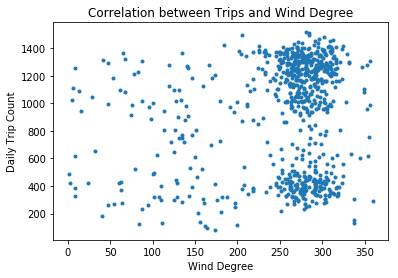

In [241]:
# Plot the daily trip count vs. the wind degree
plt.plot(daily_wind_degree, daily_trip_count, '.')
plt.xlabel('Wind Degree')
plt.ylabel('Daily Trip Count')
plt.title('Correlation between Trips and Wind Degree')
plt.show()

Picture from this link: http://snowfence.umn.edu/Components/winddirectionanddegreeswithouttable3.htm
240-320 degrees corespond to WSW, W, WNW, NW. So most of the time the wind comes from the north west.

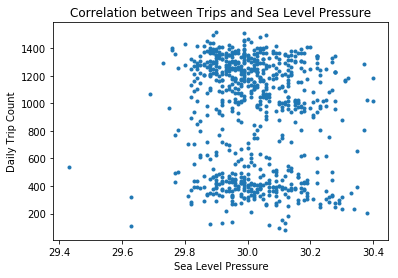

In [244]:
plt.plot(daily_pressure, daily_trip_count, '.')
plt.xlabel('Sea Level Pressure')
plt.ylabel('Daily Trip Count')
plt.title('Correlation between Trips and Sea Level Pressure')
plt.show()

Similarly with the wind degree, the sea level pressure also concentrates in a short range.

Feature importance explanation.

The Gradient Boosting Regressor is essentially a decision tree method. So its importance can be explained by that for decision tree. http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

    The feature importances. The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance R255.



In [245]:
importance_series = pd.Series(dict(zip(X_train.columns, daily_importance))).sort_values(ascending=False).reset_index()
importance_series.columns = ['feature_regular', 'importance_regular']
display(importance_series)

,feature_regular,importance_regular
0,BDay,0.181869
1,Wind_Deg,0.125949
2,Pressure,0.078783
3,Humid,0.077042
4,Temp,0.065730
5,Gust,0.063379
6,Dew,0.062518
7,Mean_Wind,0.050992
8,weekday,0.044346
9,Max_Wind,0.043712


The wind degree and the sea level pressure have been explained above. These two features have very concentrated distribution in a short range.

The business day ranks the third and is the first feature that is not weather-related. The second non-weather feature is the weekday, ranking 9. The humidity, temperature and wind speed are undoubtfully important. Surprisingly, the cloud, precipitation, rain, fog features are not so important, which is contradicting to common sense. I can only explain it that these weather information may not apply to and have very limited influence on the whole day. For instance, it may fog or rain in the early morning or during night when the bike trips are rare.

In fact, the above interpretation may not be right. According to this link:

    Just because a node is lower on the tree does not necessarily mean that it is less important. The feature importance in sci-kitlearn is calculated by how purely a node separates the classes (Gini index).



# 1.5 Test the performance treating the data as time series

In [246]:
# before_time_split = trips_SF.index < time_split
# after_time_split = trips_SF.index >= time_split

split_index = int(features_SF.shape[0] * 0.8) + 1
print('The splitting date is {}.'.format(features_SF.index[split_index]))

X_train_time = features_SF.iloc[:split_index]
y_train_time = counts_SF[:split_index]

X_test_time = features_SF[split_index:]
y_test_time = counts_SF[split_index:]

The splitting date is 2015-04-08.


In [247]:
print('The percentage of the training set is {:.1f}% of the entire dataset.'.format(len(X_train_time) / len(trips_SF) * 100))

The percentage of the training set is 80.1% of the entire dataset.


In [248]:
gbr_params

{'learning_rate': [0.02, 0.05, 0.08],
 'max_depth': [8, 9, 10],
 'min_samples_leaf': [3, 4, 5],
 'n_estimators': [150, 200, 250]}

In [249]:
gbr_params_time = {'learning_rate': [0.05, 0.06, 0.07],
                   'max_depth': [5, 6, 7],
                   'min_samples_leaf': [1, 2, 3],
                   'n_estimators': [50, 100, 150]}

In [250]:
# Grid search
rgs_time = GradientBoostingRegressor(random_state=random_state)
cv_sets_time = TimeSeriesSplit(n_splits=15)
grid_time = GridSearchCV(estimator = rgs_time, param_grid = gbr_params_time, scoring = mae_scorer, cv = cv_sets_time, n_jobs=-1, verbose=1)
grid_time.fit(X_train_time, y_train_time)
    
print('The grid search of the Gradient Boosting Regressor gives the median absolute error {:.1f} for the best estimator.'.format((-1) * grid_time.best_score_))

Fitting 15 folds for each of 81 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1031 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:   17.4s finished


The grid search of the Gradient Boosting Regressor gives the median absolute error 92.5 for the best estimator.


In [251]:
# Best model for time series training vs. regular training sets.
bestRegressor_time = grid_time.best_estimator_

print('The best regressor for time-series splitted training set is:')
print(bestRegressor_time)
print('\n')
print('The best regressor for regularly splitted training set is:')
print(bestRegressor)

The best regressor for time-series splitted training set is:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.06, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=16,
             subsample=1.0, verbose=0, warm_start=False)


The best regressor for regularly splitted training set is:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=9, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=16,
             subsample=1.0,

As we can see above, the best regressor for a normal training is different than the time series training.

In [252]:
y_pred_time = bestRegressor_time.predict(X_test_time)
# Calculate the median value of the y train as the benchmark prediction
y_pred_benchmark_time =  np.ones(len(y_test_time)) * y_train_time.median()

print('The median absolute error is {:.1f} with the best estimator for the time-series splitted test set.'.format(median_absolute_error(y_test_time, y_pred_time)))
print('The median absolute error is {:.1f} with the benchmark for the time-series splitted test set.\n'.format(median_absolute_error(y_test_time, y_pred_benchmark_time)))
print('The root mean square logarithmic error is {:.4f} with the best estimator for the time-series splitted test set.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_time))))
print('The root mean square logarithmic error is {:.4f} with the benchmark for the time-series splitted test set.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_benchmark_time))))

The median absolute error is 82.9 with the best estimator for the time-series splitted test set.
The median absolute error is 332.0 with the benchmark for the time-series splitted test set.

The root mean square logarithmic error is 0.1484 with the best estimator for the time-series splitted test set.
The root mean square logarithmic error is 0.6226 with the benchmark for the time-series splitted test set.


In [253]:
print('The median absolute error is {:.1f} with the best estimator using the daily trip data.'.format(median_absolute_error(y_test, SF_daily_y_pred)))
print('The median absolute error is {:.1f} with the benchmark model using the daily trip data.'.format(median_absolute_error(y_test, y_pred_benchmark)))
print('The root mean square logarithmic error is {:.4f} with the best estimator using the daily trip data.'.format(np.sqrt(mean_squared_log_error(y_test, SF_daily_y_pred))))
print('The root mean square logarithmic error is {:.4f} with the benchmark using the daily trip data.'.format(np.sqrt(mean_squared_log_error(y_test, y_pred_benchmark))))

The median absolute error is 54.5 with the best estimator using the daily trip data.
The median absolute error is 260.0 with the benchmark model using the daily trip data.
The root mean square logarithmic error is 0.1814 with the best estimator using the daily trip data.
The root mean square logarithmic error is 0.6481 with the benchmark using the daily trip data.


In [254]:
# Show the robustness of the model
scores = cross_val_score(rgs_time, X_train_time, y_train_time, cv=cv_sets, n_jobs=-1, scoring = mae_scorer)

In [256]:
-scores

array([ 56.91419936,  62.82644608,  81.42689126,  62.66884854,
        70.48147576,  81.19349047,  56.29945758,  69.14984492,
        62.77203726,  63.43828315,  75.44166919,  55.78103516,
        73.99309373,  66.02656371,  63.09695277])

# 1.6 Decision tree display

In [257]:
importance_time = pd.Series(dict(zip(X_train_time.columns, bestRegressor_time.feature_importances_))).sort_values(ascending=False).reset_index()
importance_time.columns = ['feature_time', 'importance_time']
display(pd.concat([importance_time, importance_series], axis=1))

,feature_time,importance_time,feature_regular,importance_regular
0,BDay,0.294956,BDay,0.181869
1,Wind_Deg,0.105962,Wind_Deg,0.125949
2,month,0.068793,Pressure,0.078783
3,Pressure,0.061170,Humid,0.077042
4,Humid,0.059834,Temp,0.065730
5,Temp,0.057173,Gust,0.063379
6,Dew,0.053723,Dew,0.062518
7,Gust,0.050886,Mean_Wind,0.050992
8,weekday,0.049667,weekday,0.044346
9,Max_Wind,0.046343,Max_Wind,0.043712


The feature importances for the time-series splitted dataset are nearly the same as those of the regularly splitted dataset.

In [258]:
# Pick a decision tree number from the 50 estimators of the bestRegressor_time.
sub_tree_16 = bestRegressor_time.estimators_[16, 0]

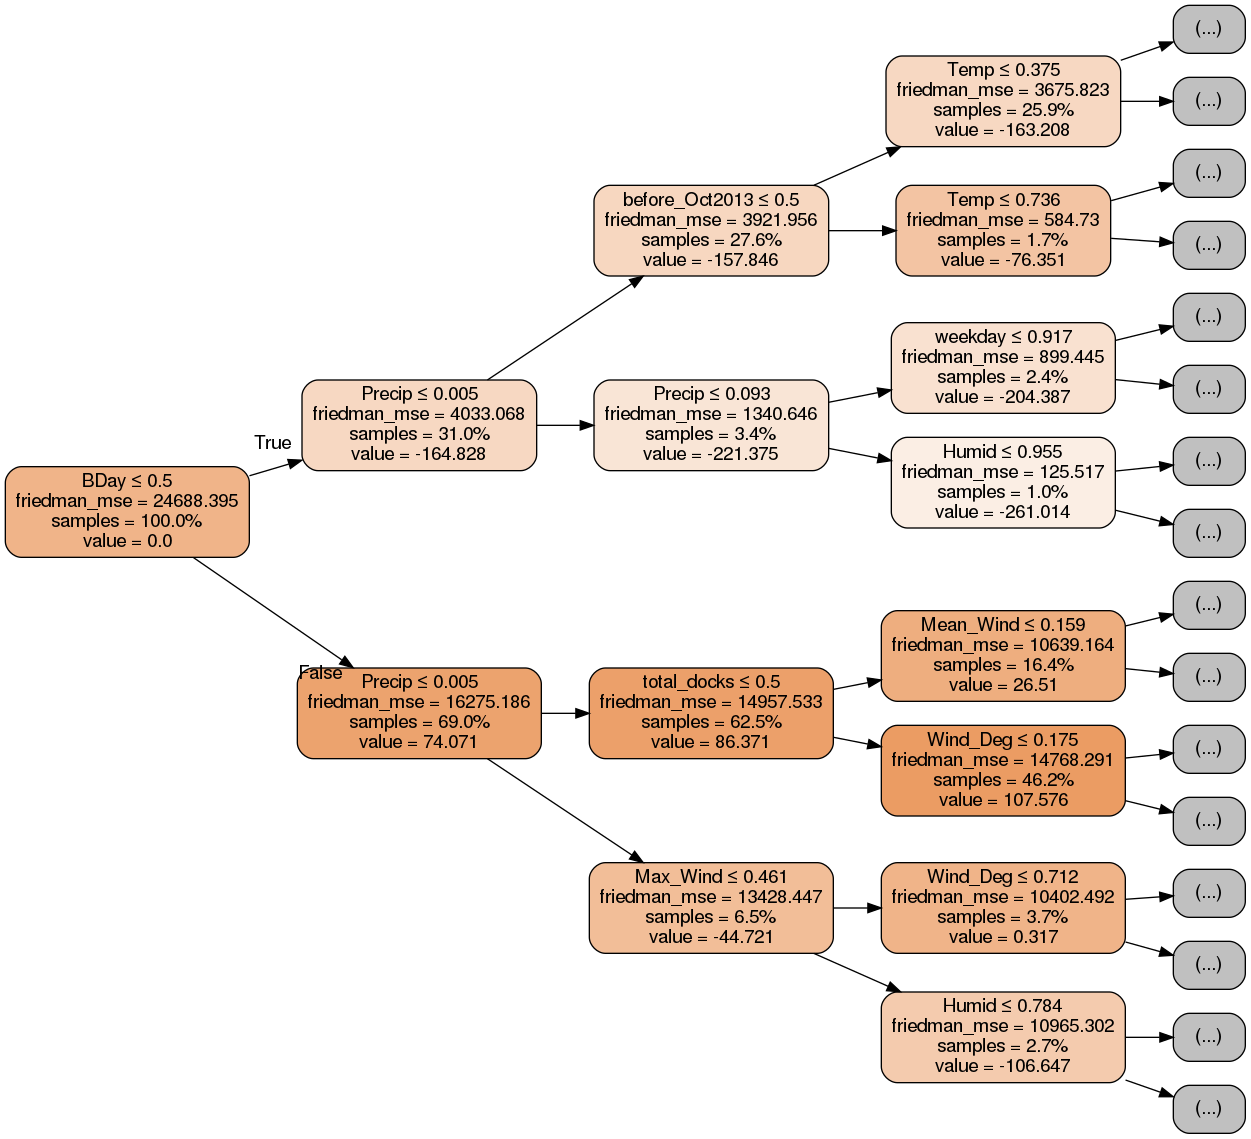

In [265]:
# Display the decision tree map. Follow the instruction from the following link:
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# Change the node color following the instruction from this link:
# https://stackoverflow.com/questions/43214350/color-of-the-node-of-tree-with-graphviz-using-class-names/43218264#43218264

dot_data = StringIO()
export_graphviz(sub_tree_16, out_file=dot_data, max_depth=3,
                feature_names=X_train_time.columns,
                filled=True, rounded=True, rotate=True,
                proportion=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('sub_tree_16.png')
Image(graph.create_png(), width=800)

One decision tree of the 50 estimators in the bestRegressor_time (Gradient Boosting Regressor) is displayed above with three depth layers to show the most important features. The higher the value of information, the darker the color.

Note that the feature importance of the regressor is ranked upon the votes from all 50 decision trees. Not every tree necessarily obeys the order of importance.

# 1.7 Feature importance ranking

http://scikit-learn.org/stable/modules/feature_selection.html http://blog.datadive.net/interpreting-random-forests/ The Gradient Boosting Regressor is a tree-based algorithm. It outputs the feature importance that can be used for feature selection by taking out the least important features. However, the ranking of the importance doesn't necessarily be the right order.

https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176


In [266]:
# LassoCV implementation
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
lassocv_time = LassoCV(cv = cv_sets_time, random_state=random_state).fit(X_train_time, y_train_time)
print('The optimal Lasso model has the alpha {:.2f}.'.format(lassocv_time.alpha_))

The optimal Lasso model has the alpha 0.90.


In [267]:
# bestLasso = Lasso_grid_time.best_estimator_
y_pred_Lasso = lassocv_time.predict(X_test_time)

print('The median absolute error is {:.1f} with the best Lasso for the time-series splitted test set.'.format(median_absolute_error(y_test_time, y_pred_Lasso)))
print('The median absolute error is {:.1f} with the benchmark for the time-series splitted test set.\n'.format(median_absolute_error(y_test_time, y_pred_benchmark_time)))
print('The root mean square logarithmic error is {:.4f} with the best Lasso for the time-series splitted test set.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_Lasso))))
print('The root mean square logarithmic error is {:.4f} with the benchmark for the time-series splitted test set.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_benchmark_time))))

The median absolute error is 125.0 with the best Lasso for the time-series splitted test set.
The median absolute error is 332.0 with the benchmark for the time-series splitted test set.

The root mean square logarithmic error is 0.2196 with the best Lasso for the time-series splitted test set.
The root mean square logarithmic error is 0.6226 with the benchmark for the time-series splitted test set.


The results with Lasso regressor is worse than the Gradient Boosting Regressor, but still much better than the naive predictor. So it still makes sense to use the coefficients of the Lasso regressor for feature ranking and interpretation.

In [268]:
# Show the robustness of the model
scores = cross_val_score(lassocv_time, X_train_time, y_train_time, cv=cv_sets, n_jobs=-1, scoring = mae_scorer)

In [269]:
-scores

array([ 86.29313305,  94.0246247 ,  95.11989394,  78.22327123,
        85.73315507,  96.94586284,  77.22026939,  79.683902  ,
        85.52358063,  78.78471477,  89.55374939,  77.82806515,
        88.56895503,  75.24744846,  81.60389828])

In [270]:
# Obtain the coefficients from the Lasso fitting.
importance_Lasso = pd.Series(dict(zip(X_train_time.columns, lassocv_time.coef_))).reset_index()
importance_Lasso['abs_coef'] = np.abs(importance_Lasso[0])
importance_Lasso.columns = ['features', 'coefficient', 'abs_coef']
importance_Lasso_sorted = importance_Lasso.sort_values('abs_coef', ascending=False).set_index('features')

In [271]:
importance_Lasso_sorted.coefficient

features
BDay              589.905380
Precip           -553.159846
Temp              322.246582
Mean_Wind        -106.616824
Wind_Deg          103.313499
weekday           -99.839786
Rain              -81.428010
total_docks        77.619093
Fog_Rain          -76.690316
Dew                69.855156
Gust              -48.740686
before_Oct2013    -31.385932
Min_Vis            26.259021
Cloud             -19.759931
month              -9.211703
Humid               0.000000
Max_Vis            -0.000000
Max_Wind           -0.000000
Mean_Vis            0.000000
Pressure            0.000000
Fog                 0.000000
Thunder            -0.000000
Name: coefficient, dtype: float64

Lasso is a linear regression method. If all feature columns are normalized to (0, 1), then the fitted coefficients become comparable. A feature coefficient can be further adjusted by the center of the most frequently appearing values, i.e. the mean. Considering that only when a feature having nonzero value does it contribute to the final result, the mean of a feature column will be calculated after all zero values are removed from the column.

In [272]:
# Calculate the median of nonzero values in the feature column.
feature_mean = []
for col in X_train_time[importance_Lasso_sorted.index]:
    feature_col = X_train_time[col]
    feature_mean.append(feature_col.iloc[feature_col.nonzero()[0]].mean())

importance_Lasso_sorted['mean_adjusted'] = importance_Lasso_sorted['coefficient'] * feature_mean
importance_Lasso_sorted['abs_mean_adjusted'] = importance_Lasso_sorted['abs_coef'] * feature_mean

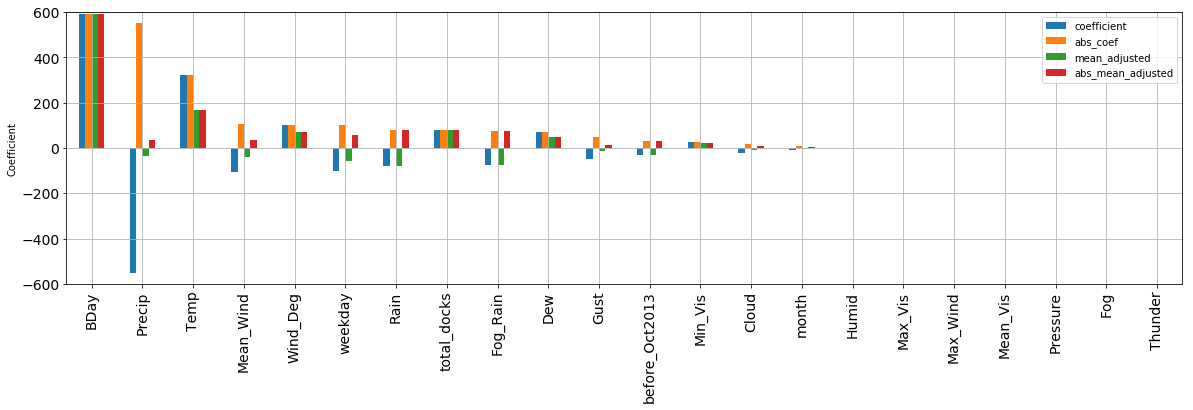

In [273]:
importance_Lasso_sorted.plot.bar(figsize=(20, 5), ylim=(-600,600), grid=True, fontsize=14)
plt.xlabel('')
plt.ylabel('Coefficient')
plt.show()

# 1.8 How does non-relevant feature removal impact the prediction?

In [274]:
# Collect all the features that have the coefficient equal to zero. These features are considered not very relevant and will be dropped.
features_to_drop = importance_Lasso_sorted.index[importance_Lasso_sorted.coefficient == 0].tolist()
print(features_to_drop)

['Humid', 'Max_Vis', 'Max_Wind', 'Mean_Vis', 'Pressure', 'Fog', 'Thunder']


In [275]:
X_train_time_drop = X_train_time.drop(features_to_drop, axis=1)
X_test_time_drop = X_test_time.drop(features_to_drop, axis=1)

In [276]:
X_train_time_drop.head(1)

,BDay,weekday,month,before_Oct2013,Temp,Dew,Min_Vis,Mean_Wind,Gust,Precip,Cloud,Wind_Deg,Fog_Rain,Rain,total_docks
date,,,,,,,,,,,,,,,
2013-08-29,True,0.5,0.636364,True,0.75,0.927273,1.0,0.5,0.301075,0.0,0.5,0.793872,0,0,0.0


In [277]:
gbr_params_time

{'learning_rate': [0.05, 0.06, 0.07],
 'max_depth': [5, 6, 7],
 'min_samples_leaf': [1, 2, 3],
 'n_estimators': [50, 100, 150]}

In [278]:
gbr_params_drop = {'learning_rate': [0.06, 0.07, 0.08],
                   'max_depth': [5, 6, 7],
                   'min_samples_leaf': [1, 2, 3],
                   'n_estimators': [150, 200, 250]}

In [280]:
# Do grid search for Gradient Boosting Regressor again to find the optimal hyperparameters.
# With less features, it allows to allocate more computation resources to do the grid search.
rgs_time_drop = GradientBoostingRegressor(random_state=random_state)
grid_time_drop = GridSearchCV(estimator = rgs_time_drop, param_grid = gbr_params_drop, scoring = mae_scorer, cv = cv_sets_time, n_jobs=-1, verbose=1)
grid_time_drop.fit(X_train_time_drop, y_train_time)

print('The grid search of the Gradient Boosting Regressor with irrelevant features dropped gives the median absolute error {:.1f} for the best estimator.'.format((-1) * grid_time_drop.best_score_))

Fitting 15 folds for each of 81 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:   30.2s finished


The grid search of the Gradient Boosting Regressor with irrelevant features dropped gives the median absolute error 87.4 for the best estimator.


In [281]:
# Compare with the full training set.
bestRegressor_time_drop = grid_time_drop.best_estimator_
y_pred_time_drop = bestRegressor_time_drop.predict(X_test_time_drop)

print('The median absolute error is {:.1f} with features dropped.'.format(median_absolute_error(y_test_time, y_pred_time_drop)))
print('The median absolute error is {:.1f} for the full time-series splitted test set.'.format(median_absolute_error(y_test_time, y_pred_time)))
print('The median absolute error is {:.1f} with the benchmark for the time-series splitted test set.\n'.format(median_absolute_error(y_test_time, y_pred_benchmark_time)))

print('The root mean square logarithmic error is {:.4f} with features dropped.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_time_drop))))
print('The root mean square logarithmic error is {:.4f} for the full time-series splitted test set.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_time))))
print('The root mean square logarithmic error is {:.4f} with the benchmark for the time-series splitted test set.'.format(np.sqrt(mean_squared_log_error(y_test_time, y_pred_benchmark_time))))

The median absolute error is 80.9 with features dropped.
The median absolute error is 82.9 for the full time-series splitted test set.
The median absolute error is 332.0 with the benchmark for the time-series splitted test set.

The root mean square logarithmic error is 0.1410 with features dropped.
The root mean square logarithmic error is 0.1484 for the full time-series splitted test set.
The root mean square logarithmic error is 0.6226 with the benchmark for the time-series splitted test set.


In [282]:
grid_time_drop.best_params_

{'learning_rate': 0.07,
 'max_depth': 6,
 'min_samples_leaf': 1,
 'n_estimators': 200}

# 2. Classfication Problem for Subscriber Type Prediction

In [283]:
# Show the datasets.
subscriber_cls.head(3)

,duration,subscription_type,inter_group,hour,BDay,weekday,month,local_zip,before_Oct2013,Temp,...,Wind_Deg,Fog,Fog_Rain,Rain,Thunder,station_region_94041,station_region_94063,station_region_94107,station_region_94301,station_region_95113
0,63,Subscriber,0,14,True,3,8,True,True,68.0,...,286.0,0,0,0,0,0,0,1,0,0
1,83,Subscriber,0,12,True,3,8,True,True,68.0,...,286.0,0,0,0,0,0,0,1,0,0
2,103,Subscriber,0,18,True,3,8,True,True,68.0,...,286.0,0,0,0,0,0,0,1,0,0


# 2.1 Feature data scaling

In [284]:
# Select feature columns that have numeric values except those with only 0 and 1. 
trip_num_features_cls = ['duration', 'hour', 'weekday', 'month', 'Temp', 'Dew', 'Humid', 'Pressure', 'Max_Vis', 'Mean_Vis', 'Min_Vis', 'Max_Wind', 'Mean_Wind', 'Gust', 'Precip', 'Cloud', 'Wind_Deg']
len(trip_num_features_cls)

17

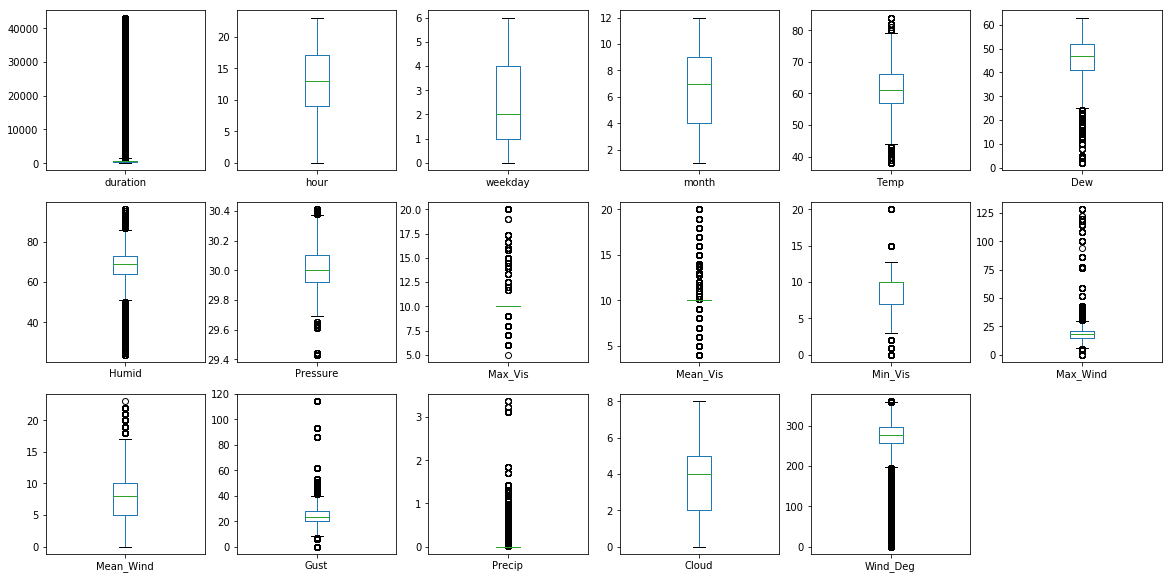

In [285]:
# Show the distribution of data for each feature.
subscriber_cls[trip_num_features_cls].plot(kind='box', subplots=True, layout=(3,6), figsize=(20, 10))
plt.show()

The duration feature has a very skewed data distribution. The logarithm will be applied to it before normalization.

In [286]:
# Apply the logarithm to the duration feature. Then scale all features to the range of (0, 1).
cls_scaler = MinMaxScaler() # Give this a name to use the inverse transform later
cls_scaled = subscriber_cls.copy()
cls_scaled['duration'] = np.log(cls_scaled['duration'])
cls_scaled[trip_num_features_cls] = cls_scaler.fit_transform(cls_scaled[trip_num_features_cls])

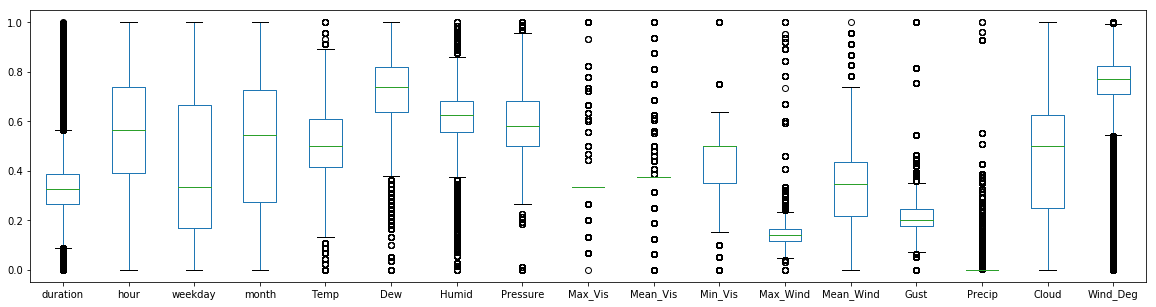

In [287]:
# Display the box-and-whisker plot for the scaled data. Now the data look more reasonable.
cls_scaled[trip_num_features_cls].plot(kind='box', figsize=(20, 5))
plt.show()

# 2.2 Generate training and testing sets

In [288]:
# Generate the feature (from the scaled data) and label columns.
features_cls = cls_scaled.drop('subscription_type', axis = 1)
subType_cls = (cls_scaled.subscription_type == 'Customer').astype('int')

In [289]:
features_cls.head(1) # Show the feature columns

,duration,inter_group,hour,BDay,weekday,month,local_zip,before_Oct2013,Temp,Dew,...,Wind_Deg,Fog,Fog_Rain,Rain,Thunder,station_region_94041,station_region_94063,station_region_94107,station_region_94301,station_region_95113
0,0.007418,0,0.608696,True,0.5,0.636364,True,True,0.652174,0.885246,...,0.794444,0,0,0,0,0,0,1,0,0


In [290]:
# Split the 'features_cls' and 'subType' data into training and testing sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(features_cls, subType_cls, test_size=0.2, random_state=random_state)

# Show the results of the split
print("Training set has {} samples.".format(X_train_cls.shape[0]))
print("Testing set has {} samples.".format(X_test_cls.shape[0]))

Training set has 535022 samples.
Testing set has 133756 samples.


In [291]:
X_train_cls.shape

(535022, 30)

## Set the scoring metric and the cross validation set

In [292]:
# Set the f0.5 as the scorer with more focus on the precision to predict the non-subscriber. The goal of this study is to figure out a special pattern for non-subscriber.
beta = 0.5
f_score = make_scorer(fbeta_score, beta=beta)

# Define a cross validation set with smaller number of split than for the classifier as even the downsampled data is still one order of magnitude than the regression data.
# This will be used for full dataset training as well.
# StratifiedKFold is used instead of the regular KFold to preserve the percentage of samples for each class. This is important for imbalanced datasets.
cv_sets_cls = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# 2.3 Downsample the training set for quick classifier exploration

In [293]:
# Define a function to downsample the data by removing adjacent similar samples.
# The squared sum of element-wise difference between adjacent samples is calculated. Only those data with the squared sum above the threshold will be kept.
# Iterate the process until the size of the data doesn't change more than min_diff from the previous run.
def downsample(data, threshold, min_diff):
    before_size = len(data)
    after_size = 0
    while(before_size - after_size > min_diff):
        before_size = len(data)
        data = data[data.diff().pow(2).sum(axis=1) > threshold]
        after_size = len(data)
    return data

In [294]:
# Divide the X_train_cls data by the subscription type
train_subs = X_train_cls[y_train_cls == 0]
train_cust = X_train_cls[y_train_cls == 1]

In [295]:
# Find the number of unique values in each column
unique_dict = {}
for col, data in X_train_cls.iteritems():
    unique_dict[col] = len(data.unique())

In [296]:
# Display the uniqueness of all columns
unique_dict

{'BDay': 2,
 'Cloud': 10,
 'Dew': 69,
 'Fog': 2,
 'Fog_Rain': 2,
 'Gust': 46,
 'Humid': 84,
 'Max_Vis': 20,
 'Max_Wind': 50,
 'Mean_Vis': 26,
 'Mean_Wind': 25,
 'Min_Vis': 20,
 'Precip': 84,
 'Pressure': 81,
 'Rain': 2,
 'Temp': 48,
 'Thunder': 2,
 'Wind_Deg': 327,
 'before_Oct2013': 2,
 'duration': 13458,
 'hour': 24,
 'inter_group': 2,
 'local_zip': 2,
 'month': 12,
 'station_region_94041': 2,
 'station_region_94063': 2,
 'station_region_94107': 2,
 'station_region_94301': 2,
 'station_region_95113': 2,
 'weekday': 7}

In [297]:
# Sort the column by the order of uniqueness. The less unique values a column has, the earlier the column will get sorted.
# These features will contribute to square sum of difference substantially: even difference from one such feature will contribute 1 to the total.
# Sorting the data with these features will help downsample the data to a small size while maintaining the sample variance necessary for finding good classifiers.
col_sort = sorted(unique_dict, key=unique_dict.get)

subs_sort = train_subs.sort_values(col_sort)
cust_sort = train_cust.sort_values(col_sort)

Set the allowed deviation from each feature to be 0.03. This suggests that within a column, two values will be considered to have similar impact on the prediction of the label if the value difference is less than 3% of the total range. This method is not ideal: if only one feature changes while the others remain the same, the deviation of that particular feature can be up to 0.51 before being considered different. Most likely the duration impact will be weakened as it changes in the smallest time scale (minute). The larger the time scale, the less frequent the feature will change value.

Note that only columns with numeric values are counted. The deviation from features with only 0 and 1 values is just too big to be even considered. This means that all different combinations of these features will be kept.


In [298]:
len(trip_num_features_cls)

17

In [299]:
dev = 0.03
threshold = (len(trip_num_features_cls) * dev) ** 2
print(threshold)

0.2601


In [300]:
%%time
# Don't set the min_diff too small, otherwise the downsample function will take a longer time to converge.
# Downsampling is done for data with different subscription type, respectively.
subs_sort_down = downsample(subs_sort, threshold=threshold, min_diff=10)
cust_sort_down = downsample(cust_sort, threshold=threshold, min_diff=10)

CPU times: user 1.99 s, sys: 424 ms, total: 2.42 s
Wall time: 1.86 s


In [301]:
# Combine the two downsized data to form the full data.
X_train_down = pd.concat([subs_sort_down, cust_sort_down])
y_train_down = y_train_cls.loc[X_train_down.index]

down_sample_size = len(X_train_down)
print('After downsampling, the data size shrinks by {:.1f}% to {}.'.format((1-down_sample_size/len(X_train_cls))*100, down_sample_size))

After downsampling, the data size shrinks by 98.1% to 10354.


# 2.4 Explore proper classifiers for the down-sampled training set

In [302]:
# The original functions comes from: https://www.kaggle.com/currie32/a-model-to-predict-number-of-daily-trips/notebook
# Use all CPUs for the computation.
# The mean is calculated instead of the median to be more comparable with the results from the GridSearchCV
def down_scoring(cls):
    scores = cross_val_score(cls, X_train_down, y_train_down, cv=cv_sets_cls, n_jobs=-1, scoring=f_score)
    return np.mean(scores)

In [303]:
%%time
# Check the performance of all regressors with default setting
# Too slow or gives error: GaussianProcessClassifier, RadiusNeighborsClassifier. 
classifiers = [DummyClassifier,
               AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier,
               LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier,
               GaussianNB,
               KNeighborsClassifier, NearestCentroid,
               MLPClassifier,
               LinearSVC, NuSVC, SVC,
               DecisionTreeClassifier, ExtraTreeClassifier,
               XGBClassifier]

cls_dict = {} # Create a classifier dictionary to record the classifier with its score
for cls in classifiers:
    begTime = time() # Get the beginning time
    
    # All parameters are set by default
    # Unfortunately, not all classifiers have a random_state classifier, so the ranking may change for different runs.
    try:
        cls_function = cls(random_state=random_state)
    except:
        cls_function = cls()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cls_score = down_scoring(cls_function)    
        
    useTime = time() - begTime
    
    cls_dict[cls.__name__] = (cls_score, useTime)
    print('The classifier {} takes {:.2f} seconds and has a F0.5 score of {:.3f}.'.format(cls.__name__, useTime, cls_score))    

The classifier DummyClassifier takes 0.63 seconds and has a F0.5 score of 0.442.
The classifier AdaBoostClassifier takes 1.71 seconds and has a F0.5 score of 0.777.
The classifier BaggingClassifier takes 1.74 seconds and has a F0.5 score of 0.800.
The classifier ExtraTreesClassifier takes 0.86 seconds and has a F0.5 score of 0.710.
The classifier GradientBoostingClassifier takes 2.85 seconds and has a F0.5 score of 0.810.
The classifier RandomForestClassifier takes 0.94 seconds and has a F0.5 score of 0.772.
The classifier LogisticRegression takes 0.93 seconds and has a F0.5 score of 0.772.
The classifier PassiveAggressiveClassifier takes 0.82 seconds and has a F0.5 score of 0.658.
The classifier RidgeClassifier takes 0.73 seconds and has a F0.5 score of 0.769.
The classifier SGDClassifier takes 0.73 seconds and has a F0.5 score of 0.730.
The classifier GaussianNB takes 0.62 seconds and has a F0.5 score of 0.663.
The classifier KNeighborsClassifier takes 1.38 seconds and has a F0.5 sco

In [304]:
df_cls = pd.DataFrame.from_dict(cls_dict, orient='index')
df_cls.columns = ['f_score', 'time_consumption']
df_cls.time_consumption = df_cls.time_consumption / 60 # Change the unit to minute
df_cls_sort = df_cls.sort_values('f_score')

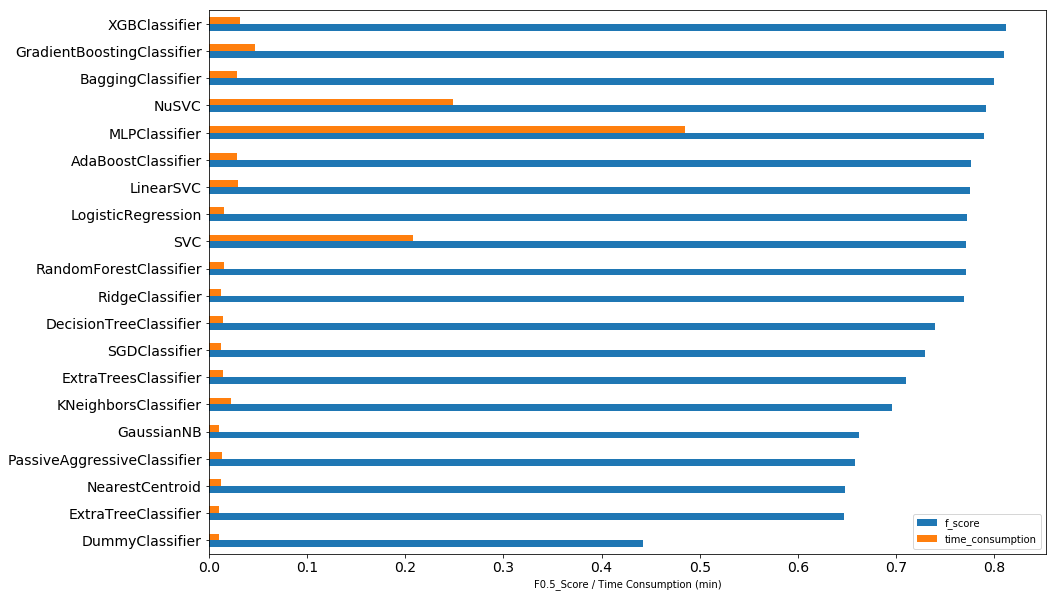

In [306]:
df_cls_sort.plot.barh(figsize=(15, 10), fontsize=14)
plt.xlabel('F0.5_Score / Time Consumption (min)')
plt.show()

It is trickier to pick the right model for a large dataset. Both the performance and the complexity of a model will be considered: a high score is critical and a shorter training time is also important. A balance need to be found between them.

Three classifiers will be picked out. I will follow these strategies:

    1) First, classifiers performing better than the average will be picked up.
    2) Normalize the F0.5 score on the good classifier group.
    3) Create a formula to balance the performance and the time consumption.
    4) Give more emphasis on the performance. Make sure two of the top three classifiers also rank in the top three following the new criterion.



In [307]:
# First select those classifiers that perform at least better than the mean. Then normalize values of the selected classifiers.
df_cls_2 = df_cls_sort.loc[df_cls_sort.f_score > df_cls_sort.f_score.mean(), :]
df_cls_2['f_score_norm'] = minmax_scale(df_cls_2.f_score)

In [308]:
# Give more emphasis on the performane by taking the cubic of each value.
# Bagging Classifier ranks in the top three in both groups.
(df_cls_2.f_score_norm ** 3 / df_cls_2.time_consumption).sort_values(ascending=False)

XGBClassifier                 31.280032
BaggingClassifier             21.780565
GradientBoostingClassifier    19.867172
LogisticRegression             9.082409
RidgeClassifier                8.905936
RandomForestClassifier         8.457756
AdaBoostClassifier             6.578276
LinearSVC                      5.741477
NuSVC                          1.691407
MLPClassifier                  0.816910
SVC                            0.643491
DecisionTreeClassifier         0.126760
SGDClassifier                  0.000000
dtype: float64

Downsampling the training set undoubtfully helps with excluding those classifiers that are too time-consuming. It also gives an idea of the best-performing classifiers. We will check later if a good classifier will do well on both the full dataset and the downsized dataset.

# 2.5 Find the optimal hyperparameters on the downsampled training data

# 2.5.1 For sklearn classifiers

In [309]:
# The XGBClassifier document can be found here: http://xgboost.readthedocs.io/en/latest/python/python_api.html
# Tuning instruction: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
bc_params = {'n_estimators':[10, 30, 50], 'max_samples':[0.4, 0.5, 0.6, 0.7]} # For Bagging Classifier, the number of estimators shouldn't be much larger than the default (10), otherwise the training time can be untolerable.
lr_params = {'penalty': ['l1', 'l2'], 'C': np.linspace(0.1, 1.0, 10)} # For Logistic Classifier
rc_params = {'alpha': np.linspace(0.1, 1.0, 20)} # For Ridge Classifier

In [310]:
# Initiate a dictionary to hold the best classifiers
best_cls = {}

In [311]:
# Randomized search will be utilized to save time as this dataset, though downsized, is still one order of magnitude than the regression set.
classifiers = [BaggingClassifier, LogisticRegression, RidgeClassifier] # Note that the classifier needs to be a function rather than the name itself.
cls_params = [bc_params, lr_params, rc_params]
n_iter_search = 10

for cls, cls_params in zip(classifiers, cls_params):
    begTime = time()
    
    grid_down = RandomizedSearchCV(estimator=cls(random_state=random_state), param_distributions=cls_params, n_iter=n_iter_search, scoring = f_score, cv = cv_sets_cls, n_jobs=-1, verbose=1)
    # The whole downsampled data is considered a "training set" for the full set, so all data will be used to capture the unique patterns.
    grid_down.fit(X_train_down, y_train_down)
    
    useTime = time() - begTime
    
    print('It takes {:.1f} seconds to grid search the classifier {}. The median F0.5 score is {:.3f}.'.format(useTime, cls.__name__, grid_down.best_score_))
    best_cls[cls.__name__] = grid_down.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.7s finished


It takes 20.0 seconds to grid search the classifier BaggingClassifier. The median F0.5 score is 0.817.
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.8s finished


It takes 10.1 seconds to grid search the classifier LogisticRegression. The median F0.5 score is 0.774.
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s


It takes 2.9 seconds to grid search the classifier RidgeClassifier. The median F0.5 score is 0.769.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


# 2.5.2 For XGBClassifier

In on comparison run, the following data were recorded:

    Using the CPU: 330 seconds
    Using 'gpu_hist': 90 seconds
    Using 'gpu_exact': 80 seconds

For small to medium dataset, exact greedy method is faster. For very large-dataset, 'hist' method is supposed to be faster. Using 'auto' actually makes the training slower.

I follow the instructions for the hyper-parameter tuning from these two webpages with a focus on controlling overfitting: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/ http://xgboost.readthedocs.io/en/latest/model.html#

http://xgboost.readthedocs.io/en/latest/python/python_api.html

    eval_metric (str, callable, optional) – If a str, should be a built-in evaluation metric to use. See doc/parameter.md. If callable, a custom evaluation metric. The call signature is func(y_predicted, y_true) where y_true will be a DMatrix object such that you may need to call the get_label method. It must return a str, value pair where the str is a name for the evaluation and value is the value of the evaluation function. This objective is always minimized.



In [312]:
# Define a customized evaluation function for the xgboost cross valiation -- the F0.5 score.
# https://ajourneyintodatascience.quora.com/Custom-evaluation-function-and-early-stopping-for-xgboost-with-k-fold-validation-Python
def xgb_f_score(y_predicted, dtrain):
    y_true = dtrain.get_label() # Use get_label() to obtain the y_true. Label means the label column.
    y_pred = np.round(y_predicted) # The y_predicted is the sigmoid output. Rounding it will produce binary results.
    score = fbeta_score(y_true, y_pred, beta=0.5)

    return 'fbeta', score # Must return ('name', value)

In [313]:
# Don't set the n_jobs to -1 as the GPU will be used instead of the CPU.
# The mean score is calculated to be comparable with the results from the GridSearchCV.
def xgb_scoring(cls, X_train, y_train):
    scores = cross_val_score(cls, X_train, y_train, cv=cv_sets_cls, n_jobs=-1, scoring=f_score)
    return np.mean(scores)

In [314]:
# First find the best number of estimators
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# Use the customized evaluation function xgb_f_score. Remember to set the maximize to True.
# Set the folds to be cv_sets_cls so that the result is reproducible. cv_sets_cls is a stratified K-Fold.
# Note that the scoring is on the whole training dataset.
def modelfit(alg, X_train, y_train, useTrainCV=True, folds=cv_sets_cls, feval=xgb_f_score, stopping=50, verbose_eval=True):
    
    if useTrainCV:
        print('Start the cross validation...')
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values) # Convert the pandas dataframe to the xgboost data format for the cv
        
        # Unfortunately the cross-validation method in xgboost doesn't allow f_score as the metric. AUC should be a similar measure with the f_score.
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds=folds, 
                          feval=feval, maximize=True, early_stopping_rounds=stopping, verbose_eval=verbose_eval) 
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    print('Start the scoring...')
    xgb_f_score = cvresult['test-fbeta-mean'].max()
    
    #Print model report:
    print("\nModel Report")
    print("F0.5 Score of the whole training data: {:.4f}. \n".format(xgb_f_score))
    print(alg)
    
    return xgb_f_score

# Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [315]:
%%time
# Initiate the XGBClassifier. Use 'gpu_exact' as this is a small dataset. Using 'gpu_hist' doesn't use as many GPU memory as the 'gpu_exact'
# Note that the number of estimators is very large. This is the maximal round that the modelfit can try to find the optimal number of estimators..
## init_params = {'tree_method': 'gpu_exact', 'predictor': 'gpu_predictor'}
init_params = {'predictor': 'cpu_predictor'}
xgb_cls_0 = XGBClassifier(learning_rate= 0.1,
                          n_estimators= 1000,
                          max_depth= 5,
                          min_child_weight= 1,
                          gamma= 0,
                          subsample= 0.8,
                          colsample_bytree= 0.8,
                          reg_alpha= 0,
                          reg_lambda= 1,                          
                          scale_pos_weight= 1,
                          objective= 'binary:logistic',
                          random_state=random_state, **init_params)

# Find the best estimator number.
xgb_cls_0_score = modelfit(xgb_cls_0, X_train_down, y_train_down, folds=cv_sets_cls, verbose_eval=False)

Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8198. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=72,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=16, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
CPU times: user 12.8 s, sys: 9.44 ms, total: 12.8 s
Wall time: 12.8 s


# Step 2: Tune max_depth and min_child_weight

In [316]:
%%time
# Note the parameters: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
# Also check here: https://github.com/dmlc/xgboost/issues/2819
# Grid search the 'max_depth' and 'min_child_weight' hyperparameters for the XGBClassifier using GPU to improve the training speed.

xgb_params1={'max_depth': range(3,10,2), 'min_child_weight': range(1,6,2)}
xgb_grid_1 = GridSearchCV(xgb_cls_0, param_grid=xgb_params1, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_1.fit(X_train_down, y_train_down)    
xgb_cls_1 = xgb_grid_1.best_estimator_

xgb_cls_1_score = xgb_grid_1.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_1_score))
print(xgb_cls_1)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   20.3s finished


F0.5 Score of the cross validation: 0.8214. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=72,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=16, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
CPU times: user 1.62 s, sys: 384 ms, total: 2 s
Wall time: 21.8 s


In [317]:
xgb_cls_1_score - xgb_cls_0_score

0.0015333545425492145

# Tune max_depth and min_child_weight in finer step

In [318]:
%%time
xgb_params2 = {'max_depth':[6,7,8], 'min_child_weight':[4,5,6]}
xgb_grid_2 = GridSearchCV(xgb_cls_1, param_grid=xgb_params2, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_2.fit(X_train_down, y_train_down)
xgb_cls_2 = xgb_grid_2.best_estimator_

xgb_cls_2_score = xgb_grid_2.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_2_score))
print(xgb_cls_2)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.1s finished


F0.5 Score of the cross validation: 0.8222. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=6, missing=None, n_estimators=72,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=16, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)
CPU times: user 1.46 s, sys: 361 ms, total: 1.82 s
Wall time: 18.6 s


In [319]:
xgb_cls_2_score - xgb_cls_1_score

0.00085181354468977233

## Re-do the modelfit to find the best number of estimators

In [320]:
# Copy all the parameters for xgb_cls_2 except setting the n_estimators to a large number.
xgb_cls_2_b = XGBClassifier(learning_rate= 0.1,
                            n_estimators= 1000,
                            max_depth= 7,
                            min_child_weight= 6,
                            gamma= 0,
                            subsample= 0.8,
                            colsample_bytree= 0.8,
                            reg_alpha= 0,
                            reg_lambda= 1,
                            scale_pos_weight=1,
                            objective= 'binary:logistic',                            
                            random_state=random_state, **init_params)

xgb_cls_2_b_score = modelfit(xgb_cls_2_b, X_train_down, y_train_down, folds=cv_sets_cls, verbose_eval=False)

Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8250. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=6, missing=None, n_estimators=37,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=16, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


In [321]:
xgb_cls_2_b_score - xgb_cls_2_score

0.0027862319127608393

# Step 3: Tune gamma

In [322]:
%%time
xgb_params3 = {'gamma':[i/10.0 for i in range(0,5)]}
xgb_grid_3 = GridSearchCV(xgb_cls_2_b, param_grid=xgb_params3, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_3.fit(X_train_down, y_train_down)
xgb_cls_3 = xgb_grid_3.best_estimator_

xgb_cls_3_score = xgb_grid_3.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_3_score))
print(xgb_cls_3)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.5s finished


F0.5 Score of the cross validation: 0.8218. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=37, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)
CPU times: user 841 ms, sys: 367 ms, total: 1.21 s
Wall time: 6.71 s


In [323]:
xgb_cls_3_score - xgb_cls_2_b_score

-0.0031599861641866678

# Re-do the modelfit to find the best number of estimators

In [324]:
# Copy all the parameters for xgb_cls_2 except setting the n_estimators to a large number.
xgb_cls_3_b = XGBClassifier(learning_rate= 0.1,
                            n_estimators= 1000,
                            max_depth= 7,
                            min_child_weight= 6,
                            gamma= 0.4,
                            subsample= 0.8,
                            colsample_bytree= 0.8,
                            reg_alpha= 0,
                            reg_lambda= 1,
                            scale_pos_weight=1,
                            objective= 'binary:logistic',                            
                            random_state=random_state, **init_params)

xgb_cls_3_b_score = modelfit(xgb_cls_3_b, X_train_down, y_train_down, folds=cv_sets_cls, verbose_eval=False)

Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8252. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=42, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)


In [325]:
xgb_cls_3_b_score - xgb_cls_3_score

0.0033952861641868282

# Step 4: Tune subsample and colsample_bytree

In [326]:
%%time
xgb_params4 = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
xgb_grid_4 = GridSearchCV(xgb_cls_3_b, param_grid=xgb_params4, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_4.fit(X_train_down, y_train_down)
xgb_cls_4 = xgb_grid_4.best_estimator_

xgb_cls_4_score = xgb_grid_4.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_4_score))
print(xgb_cls_4)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   18.4s finished


F0.5 Score of the cross validation: 0.8250. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=42, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)
CPU times: user 1.35 s, sys: 364 ms, total: 1.71 s
Wall time: 19.5 s


In [327]:
xgb_cls_4_score - xgb_cls_3_b_score

-0.00024867846487330869

# Step 5: Tune regularization parameter

In [328]:
%%time
xgb_params5 = {'reg_alpha':[0.01, 0.1, 1, 10], 'reg_lambda':[0.01, 0.1, 1, 10]}
xgb_grid_5 = GridSearchCV(xgb_cls_4, param_grid=xgb_params5, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_5.fit(X_train_down, y_train_down)
xgb_cls_5 = xgb_grid_5.best_estimator_

xgb_cls_5_score = xgb_grid_5.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_5_score))
print(xgb_cls_5)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   16.9s finished


F0.5 Score of the cross validation: 0.8267. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=42, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)
CPU times: user 1.43 s, sys: 416 ms, total: 1.85 s
Wall time: 18.2 s


In [329]:
xgb_cls_5_score - xgb_cls_4_score

0.0017143200304648998

# Tuning Regularization Parameters in a Smaller Step

In [330]:
%%time
xgb_params6 = {'reg_alpha':[0.5, 1, 2, 3], 'reg_lambda':[0.5, 1, 2, 3]}
xgb_grid_6 = GridSearchCV(xgb_cls_5, param_grid=xgb_params6, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_6.fit(X_train_down, y_train_down)
xgb_cls_6 = xgb_grid_6.best_estimator_

xgb_cls_6_score = xgb_grid_6.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_6_score))
print(xgb_cls_6)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   16.4s finished


F0.5 Score of the cross validation: 0.8252. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=42, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)
CPU times: user 1.48 s, sys: 390 ms, total: 1.87 s
Wall time: 17.7 s


In [331]:
xgb_cls_6_score - xgb_cls_5_score

-0.0015189001275393021

# Re-do the modelfit to find the best number of estimators

In [333]:
xgb_cls_6_b = XGBClassifier(learning_rate= 0.1,
                            n_estimators= 1000,
                            max_depth= 7,
                            min_child_weight= 6,
                            gamma= 0.4,
                            subsample= 0.6,
                            colsample_bytree= 0.6,
                            reg_alpha= 1,
                            reg_lambda= 1,
                            scale_pos_weight=1,
                            objective= 'binary:logistic',                            
                            random_state=random_state, **init_params)

xgb_cls_6_b_score = modelfit(xgb_cls_6_b, X_train_down, y_train_down, folds=cv_sets_cls, verbose_eval=False)

Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8205. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=43, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)


In [334]:
xgb_cls_6_b_score - xgb_cls_6_score

-0.0046657414380524287

# Step 6: Tune scale_pos_weight for balancing the positive and negative weight

In [335]:
%%time
xgb_params7 = {'scale_pos_weight': np.linspace(0.1, 1, 10)}
xgb_grid_7 = GridSearchCV(xgb_cls_6_b, param_grid=xgb_params7, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_7.fit(X_train_down, y_train_down)
xgb_cls_7 = xgb_grid_7.best_estimator_

xgb_cls_7_score = xgb_grid_7.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_7_score))
print(xgb_cls_7)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished


F0.5 Score of the cross validation: 0.8306. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=43, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=1, reg_lambda=1,
       scale_pos_weight=0.59999999999999998, seed=None, silent=True,
       subsample=0.6)
CPU times: user 1.06 s, sys: 370 ms, total: 1.43 s
Wall time: 10.8 s


In [336]:
xgb_cls_7_score - xgb_cls_6_b_score

0.010079031080014178

# Tuning scale_pos_weight in a Smaller Step

In [338]:
%%time
xgb_params8 = {'scale_pos_weight': np.arange(0.51, 0.69, 0.01)}
xgb_grid_8 = GridSearchCV(xgb_cls_7, param_grid=xgb_params8, scoring=f_score, 
                          cv=cv_sets_cls, n_jobs=-1, verbose=1)
xgb_grid_8.fit(X_train_down, y_train_down)
xgb_cls_8 = xgb_grid_8.best_estimator_

xgb_cls_8_score = xgb_grid_8.best_score_
print('F0.5 Score of the cross validation: {:.4f}. \n'.format(xgb_cls_8_score))
print(xgb_cls_8)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   17.8s finished


F0.5 Score of the cross validation: 0.8315. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=43, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=1, reg_lambda=1,
       scale_pos_weight=0.6100000000000001, seed=None, silent=True,
       subsample=0.6)
CPU times: user 1.45 s, sys: 400 ms, total: 1.85 s
Wall time: 18.9 s


In [339]:
xgb_cls_8_score - xgb_cls_7_score

0.00091497192359624169

# Step 7: Optimizing Learning Rate

In [340]:
# Explore different learning rates using the modelfit, in place of the GridSearchCV.
xgb_cls_9 = {}
for lr in [i/10.0 for i in range(1,4)]:
    xgb_cls_temp = XGBClassifier(learning_rate= lr,
                                 n_estimators= 1000,
                                 max_depth= 7,
                                 min_child_weight= 6,
                                 gamma= 0.4,
                                 subsample= 0.6,
                                 colsample_bytree= 0.6,
                                 objective= 'binary:logistic',
                                 reg_alpha= 1,
                                 reg_lambda= 1,
                                 scale_pos_weight= 0.58,
                                 random_state=random_state, **init_params)
    
    xgb_temp_score = modelfit(xgb_cls_temp, X_train_down, y_train_down, folds=cv_sets_cls, verbose_eval=False)    
    xgb_cls_9[lr] = (xgb_cls_temp, xgb_temp_score)

Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8320. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=68, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=1, reg_lambda=1, scale_pos_weight=0.58,
       seed=None, silent=True, subsample=0.6)
Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8321. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.2,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=32, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_al

# Tuning learning curve in a Smaller Step

In [341]:
# Explore different learning rates using the modelfit, in place of the GridSearchCV.
xgb_cls_10 = {}
for lr in [i/100.0 for i in range(12, 30, 2)]:
    xgb_cls_temp = XGBClassifier(learning_rate= lr,
                                 n_estimators= 1000,
                                 max_depth= 7,
                                 min_child_weight= 6,
                                 gamma= 0.4,
                                 subsample= 0.6,
                                 colsample_bytree= 0.6,
                                 objective= 'binary:logistic',
                                 reg_alpha= 1,
                                 reg_lambda= 1,
                                 scale_pos_weight= 0.58,
                                 random_state=random_state, **init_params)
    
    xgb_temp_score = modelfit(xgb_cls_temp, X_train_down, y_train_down, folds=cv_sets_cls, verbose_eval=False)    
    xgb_cls_10[lr] = (xgb_cls_temp, xgb_temp_score)

Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8332. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.12,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=63, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=1, reg_lambda=1, scale_pos_weight=0.58,
       seed=None, silent=True, subsample=0.6)
Start the cross validation...
Start the scoring...

Model Report
F0.5 Score of the whole training data: 0.8315. 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.14,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=68, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_

In [342]:
xgb_cls_10[0.2][1] - xgb_cls_8_score 

0.00056769699638969939

# Step 8: Select the Best Predictor and Explore the Learning Curve

In [343]:
xgb_cls = xgb_cls_10[0.2][0]

In [344]:
# Define a function to calculate the mean and standard deviation of nonzero values in a numpy array.
def nonzero_mean(np_array):
    array_len = len(np_array)
    mean_data_nonzero = np.zeros(array_len)
    std_data_nonzero = np.zeros(array_len)
    
    for i in range(array_len):
        nonzero_array = np_array[i][np_array[i].nonzero()]
        if nonzero_array.any() == True:
            mean_data_nonzero[i] = np.mean(nonzero_array)
            std_data_nonzero[i] = np.std(nonzero_array)
    
    return mean_data_nonzero, std_data_nonzero

In [345]:
def plot_learning_curve(cls, X_train, y_train, train_sizes, scoring, cv=cv_sets_cls, verbose=1):

    sizes, train_scores, test_scores = learning_curve(cls, X_train, y_train, cv=cv, 
                                                      n_jobs=-1, train_sizes=train_sizes, 
                                                      scoring=scoring, verbose=verbose)
    
    # Find the mean and standard deviation for smoothing.
    train_mean, train_std = nonzero_mean(train_scores)
    test_mean, test_std = nonzero_mean(test_scores)
    
    # Plot the learning curve 
    fig, ax = plt.subplots(figsize=(8, 10))
    plt.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')     
    
    plt.xlabel('Number of Training Samples')
    plt.ylabel(str(scoring))
    plt.title('Learning Performance of {}'.format(cls.__class__.__name__))
    
    minorLocator = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocator)
    
    plt.grid(which='both')
    plt.legend(loc='upper left')
    plt.show()
    
    # return train_scores

[learning_curve] Training set sizes: [ 931 1980 3028 4076 5124 6173 7221 8269 9318]


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.9s finished


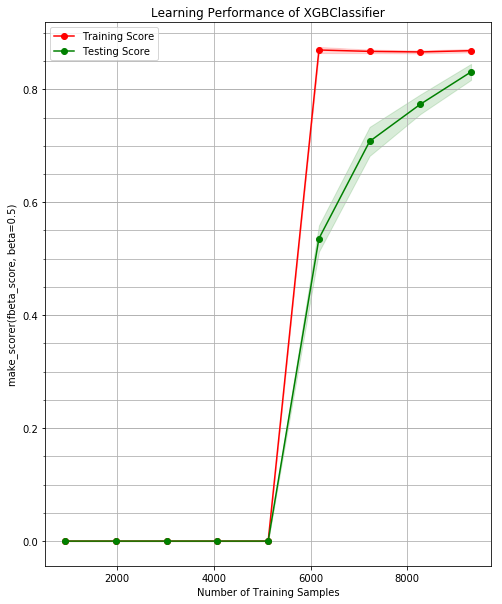

CPU times: user 644 ms, sys: 348 ms, total: 991 ms
Wall time: 3.59 s


In [348]:
%%time
# Generate the training set sizes increasing exponentially
# train_sizes = np.geomspace(0.1, 1.0, num=9)
train_sizes = np.linspace(0.1, 1.0, num=9)

# Suppress the warnings due to an "ill-defined" f score
# https://stackoverflow.com/questions/29086398/sklearn-turning-off-warnings
# https://docs.python.org/2/library/warnings.html#temporarily-suppressing-warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_learning_curve(xgb_cls, X_train_down, y_train_down, train_sizes=train_sizes, 
                        cv=cv_sets_cls, scoring=f_score, verbose=1)

[learning_curve] Training set sizes: [ 931 1980 3028 4076 5124 6173 7221 8269 9318]


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.8s finished


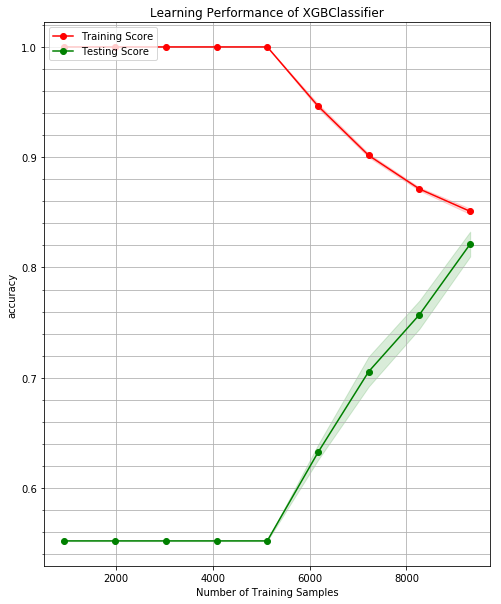

CPU times: user 626 ms, sys: 366 ms, total: 992 ms
Wall time: 3.49 s


In [349]:
%%time
# Explore the accuracy learning curve.
plot_learning_curve(xgb_cls, X_train_down, y_train_down, train_sizes=train_sizes, 
                    cv=cv_sets_cls, scoring='accuracy', verbose=1)

# 2.6 Evaluate the classifiers on the entire datasets

In [350]:
xgb_cls

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.4, learning_rate=0.2,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=32, n_jobs=1, nthread=None,
       objective='binary:logistic', predictor='cpu_predictor',
       random_state=16, reg_alpha=1, reg_lambda=1, scale_pos_weight=0.58,
       seed=None, silent=True, subsample=0.6)

In [351]:
# Change the  use 'gpu_hist' instead of 'gpu_exact'.
## init_params_full = {'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
init_params_full = {'predictor': 'cpu_predictor'}
xgb_cls = XGBClassifier(learning_rate= 0.2,
                        n_estimators= 16,
                        max_depth= 7,
                        min_child_weight= 6,
                        gamma= 0.4,
                        subsample= 0.6,                         
                        colsample_bytree= 0.6,
                        reg_alpha= 1,
                        reg_lambda= 1,
                        objective= 'binary:logistic',
                        scale_pos_weight= 0.58,
                        random_state=random_state, **init_params_full)

best_cls[XGBClassifier.__name__] = xgb_cls

In [352]:
best_cls

{'BaggingClassifier': BaggingClassifier(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=0.7,
          n_estimators=50, n_jobs=1, oob_score=False, random_state=16,
          verbose=0, warm_start=False),
 'LogisticRegression': LogisticRegression(C=0.59999999999999998, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=16,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'RidgeClassifier': RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
         max_iter=None, normalize=False, random_state=16, solver='auto',
         tol=0.001),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6, gamma=0.4, learning_rate=0.2,
        max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
        n_estimators=1

In [353]:
def train_predict(learner, X_train, y_train, X_test, y_test, best=False): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    begTime = time()
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the total training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test), then get predictions on all training samples(X_train) using .predict()
    pred_train_size = int(1 * len(X_train))
    
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:pred_train_size])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on all training samples
    results['acc_train'] = accuracy_score(y_train[:pred_train_size], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F0.5-score on all training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:pred_train_size], predictions_train, beta=0.5)
        
    # Compute F0.5-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    useTime = time() - begTime
    # Success
    if best == True:
        print("Training with the classifier {} takes {:.1f} seconds.".format((learner.__class__.__name__ + '_best'), useTime))
    if best == False:
        print("Training with the classifier {} takes {:.1f} seconds.".format(learner.__class__.__name__, useTime))

    # Return the results
    return results

In [354]:
clf_A = XGBClassifier(random_state=random_state, **init_params_full)
clf_A_best = best_cls['XGBClassifier']

clf_B = BaggingClassifier(random_state=random_state)
clf_B_best = best_cls['BaggingClassifier']

clf_C = LogisticRegression(random_state=random_state)
clf_C_best = best_cls['LogisticRegression']

clf_D = RidgeClassifier(random_state=random_state)
clf_D_best = best_cls['RidgeClassifier']


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:    
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name]['default'] = train_predict(clf, X_train_cls, y_train_cls, X_test_cls, y_test_cls)

    
for clf in [clf_A_best, clf_B_best, clf_C_best, clf_D_best]:    
    clf_name = clf.__class__.__name__
    results[clf_name]['best'] = train_predict(clf, X_train_cls, y_train_cls, X_test_cls, y_test_cls, best=True)        

Training with the classifier XGBClassifier takes 39.1 seconds.
Training with the classifier BaggingClassifier takes 56.2 seconds.
Training with the classifier LogisticRegression takes 5.8 seconds.
Training with the classifier RidgeClassifier takes 1.7 seconds.
Training with the classifier XGBClassifier_best takes 13.9 seconds.
Training with the classifier BaggingClassifier_best takes 211.6 seconds.
Training with the classifier LogisticRegression_best takes 23.7 seconds.
Training with the classifier RidgeClassifier_best takes 1.8 seconds.


# 2.7 Compare the default and optimized (using the downsampled training set) classifiers

In [367]:
# Visualization function borrowed from the 'finding_donors' project.
# Modify the funtion to display the performance of each classifier with its default setting and the optimized hyper-parameters using the downsampled training set.
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (12, 8))

    # Constants
    bar_width = 0.47
    # Check the color code from Google. https://www.google.com/search?q=color+%2300A0A0&oq=color+%2300A0A0&aqs=chrome..69i57.1192j0j7&sourceid=chrome&ie=UTF-8
    # colors = ['#A00000','#08A000','#0092A0', '#8A00A0']
    # colors = ['#E0F794','#F9EB90','#92B9FC', '#C092FC']
    colors = ['#8fb21e','#ffdd00','#79a9fc','#8b6ab7']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i, label in enumerate(['default', 'best']):
                # Creative plot code
                ax[j//3, j%3].bar(k+i*1.05*bar_width, results[learner][label][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xlabel("Classifier('default', 'best')")
                ax[j//3, j%3].set_xlim((-0.5, 4.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F0.5-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F0.5-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F0.5-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F0.5-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Add horizontal lines for the best predictors
    acc_test = []
    acc_train = []
    f_test = []
    f_train = []
    for _, result in results.items():
        for _, values in result.items():
            acc_test.append(values['acc_test'])
            acc_train.append(values['acc_train'])
            f_test.append(values['f_test'])
            f_train.append(values['f_train'])    
    
    ax[0, 1].axhline(y = max(acc_train), xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dotted')
    ax[0, 1].axhline(y = max(acc_test), xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'r', linestyle = 'dotted')
    ax[1, 1].axhline(y = max(acc_test), xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dotted')
    ax[0, 2].axhline(y = max(f_train), xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dotted')
    ax[0, 2].axhline(y = max(f_test), xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'r', linestyle = 'dotted')   
    ax[1, 2].axhline(y = max(f_test), xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dotted')
    
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 4, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Four Supervised Learning Models", fontsize = 30, y = 1.10)
    plt.tight_layout()
    plt.show()

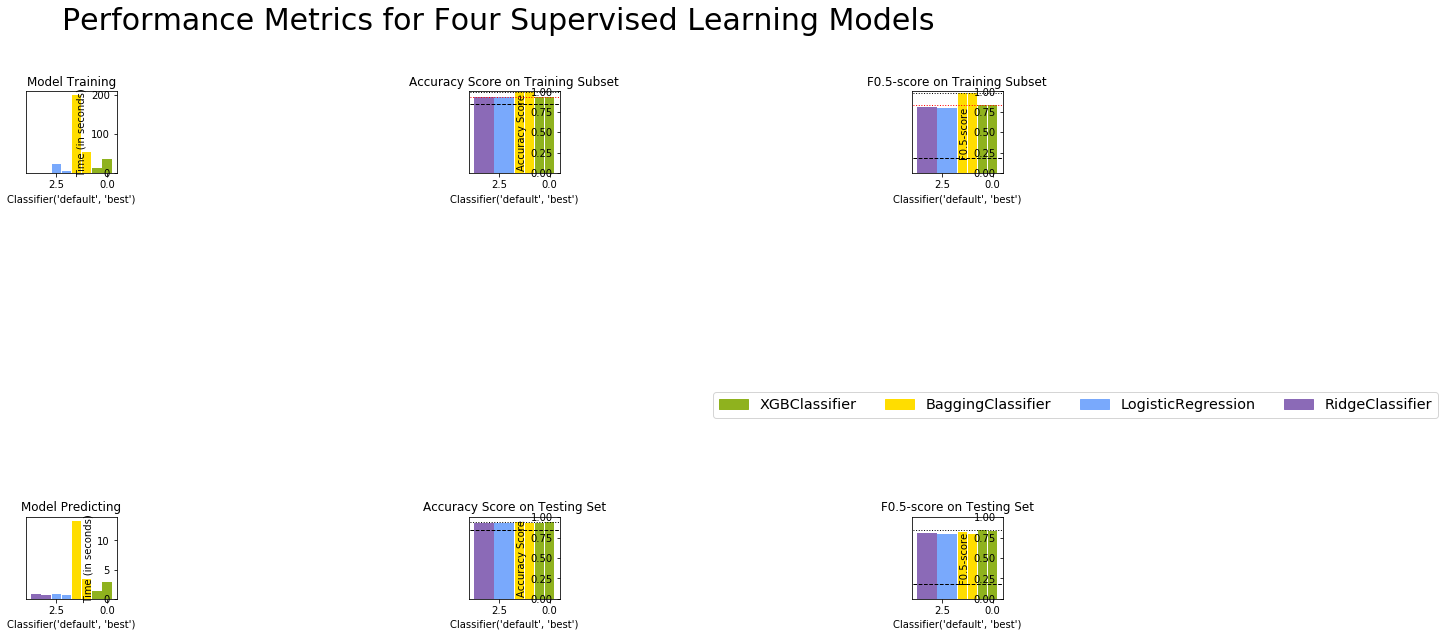

In [368]:
# Calculate the accuracy of a naive predictor that always predicts the subscriber as a benchmark for the accuracy.
# Calculate the f0.5 score of a naive predictor that always predicts the non-subscriber as a benchmark for the f0.5 score.
accuracy = np.sum(subType_cls)/float(subType_cls.count()) # If the classifier predicts all to be non-subscribers.
subscriber_accuracy = 1 - accuracy # If the classifier predicts all to be subscribers.
recall = 1
precision = accuracy

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, subscriber_accuracy, fscore)

The above graph shows:

    The classifier optimization based on the downsampled training set helps improve both the accuracy and f0.5 score on the testing set for the two complex models (bagging and xgboost). The performance on the training set becomes worse, but this is a good sign as that suggests the optimized model tries not to overfit the training set. The performance of the logistic regression and the ridge regression doesn't change significantly before and after the optimzation.

    The red dotted line on the training set plot labels the best score on the testing set. We can see that the Bagging classifier tends to overfit, while the other three seem to perform well, with the logistic regression and the ridge classifier a bit underfitting.

    In terms of the overall performance, the xgboost is the best. The ridge regression ranks the third in F0.5 score, but the training and the predicting are pretty quick. So these two will be selected to be optimized further directly on the full dataset.

    The Bagging classifier takes too much time for the training and the predicting. Not a good classifier. The xgboost classifier is doing very well in time. With the power of the GPU, its training time is even shorter than the logistic regression; its predicting time is very close to both the logistic regression and the ridge classifier.



Below is the XGBClassifier optimized for the entire dataset. Almost all parameters are different than that from the one trained on the downsampled dataset. The performance gets enhanced a lot. 

In [369]:
# For the full dataset, use 'gpu_hist' instead of 'gpu_exact'.
## init_params_full = {'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}
init_params_full = {'predictor': 'cpu_predictor'}
xgb_full = XGBClassifier(learning_rate= 0.05,
                         n_estimators=250,
                         max_depth= 9,
                         min_child_weight= 5,
                         gamma= 0,
                         subsample= 0.9,                         
                         colsample_bytree= 0.6,
                         reg_alpha= 0.5,
                         reg_lambda= 2,
                         objective= 'binary:logistic',
                         scale_pos_weight= 0.52,
                         random_state=random_state, **init_params_full)

In [370]:
np.geomspace(0.01, 1.0, num=9) * len(y_train_cls)

array([   5350.22      ,    9514.18606518,   16918.88118299,
         30086.4980486 ,   53502.2       ,   95141.86065178,
        169188.81182986,  300864.98048599,  535022.        ])

[learning_curve] Training set sizes: [  4815   8562  15226  27077  48151  85627 152269 270778 481519]


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 26.9min finished


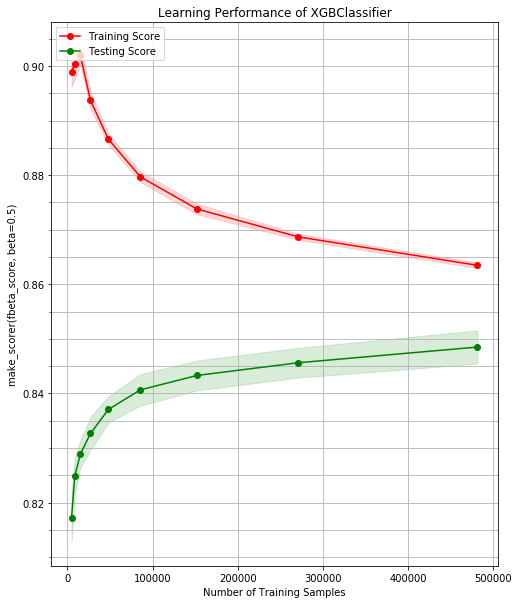

In [372]:
# Generate the training set sizes increasing exponentially. The whole process takes about 27 min.
train_sizes = np.geomspace(0.01, 1.0, num=9)
plot_learning_curve(xgb_full, X_train_cls, y_train_cls, train_sizes=train_sizes, cv=cv_sets_cls, scoring=f_score, verbose=1)


In [373]:
xgb_full

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=9, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=16, reg_alpha=0.5,
       reg_lambda=2, scale_pos_weight=0.52, seed=None, silent=True,
       subsample=0.9)

# 2.9 Prediction on the testing set

In [374]:
rc_full = RidgeClassifier(alpha=0.55000000000000004, class_weight=None, copy_X=True,
                          fit_intercept=True, max_iter=None, normalize=False,
                          random_state=16, solver='auto', tol=0.001)

In [375]:
%%time
# Fit the training set with the best classifiers and predict on the X_test_cls data.
xgb_cls.fit(X_train_cls, y_train_cls)
y_pred_xgb_down = xgb_cls.predict(X_test_cls)
fscore_xgb_down = fbeta_score(y_test_cls, y_pred_xgb_down, beta=0.5)
print('The F0.5 score on the testing set with trained model from the downsampled dataset is {:.4f}.'.format(fscore_xgb_down))

xgb_full.fit(X_train_cls, y_train_cls)
y_pred_xgb_full = xgb_full.predict(X_test_cls)
fscore_xgb_full = fbeta_score(y_test_cls, y_pred_xgb_full, beta=0.5)
print('The F0.5 score on the testing set with the optimized XGBClassifier is {:.4f}.'.format(fscore_xgb_full))

rc_full.fit(X_train_cls, y_train_cls)
y_pred_rc_full = rc_full.predict(X_test_cls)
fscore_rc_full = fbeta_score(y_test_cls, y_pred_rc_full, beta=0.5)
print('The F0.5 score on the testing set with the optimized RidgeClassifier is {:.4f}.'.format(fscore_rc_full))

The F0.5 score on the testing set with trained model from the downsampled dataset is 0.8375.
The F0.5 score on the testing set with the optimized XGBClassifier is 0.8520.
The F0.5 score on the testing set with the optimized RidgeClassifier is 0.8073.
CPU times: user 4min 28s, sys: 812 ms, total: 4min 28s
Wall time: 4min 28s


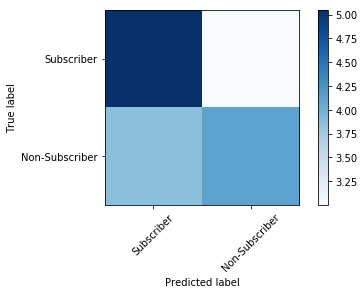

[[112264   1010]
 [  7360  13122]]


In [376]:
# Plot the confusion matrix with the log scale. The two classifiers have similar graphs, so I plot only one.
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
cm = confusion_matrix(y_test_cls, y_pred_xgb_full)

classes = ['Subscriber', 'Non-Subscriber']

cmap = plt.cm.Blues
plt.imshow(np.log10(cm), interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(cm)

In [377]:
# Show the classification report for both classifiers for comparison
print('A classification report for XGBClassifier trained with the downsampled: ')
print(classification_report(y_test_cls, y_pred_xgb_down))
print('\n')

print('A classification report for XGBClassifier: ')
print(classification_report(y_test_cls, y_pred_xgb_full))
print('\n')

print('A classification report for RidgeClassifier: ')
print(classification_report(y_test_cls, y_pred_rc_full))

A classification report for XGBClassifier trained with the downsampled: 
             precision    recall  f1-score   support

          0       0.93      0.99      0.96    113274
          1       0.94      0.59      0.72     20482

avg / total       0.93      0.93      0.92    133756



A classification report for XGBClassifier: 
             precision    recall  f1-score   support

          0       0.94      0.99      0.96    113274
          1       0.93      0.64      0.76     20482

avg / total       0.94      0.94      0.93    133756



A classification report for RidgeClassifier: 
             precision    recall  f1-score   support

          0       0.93      0.98      0.96    113274
          1       0.88      0.61      0.72     20482

avg / total       0.92      0.93      0.92    133756



# 2.10 Explore Feature Importances for Each Classifier

# Plot XGBClassifier Importances

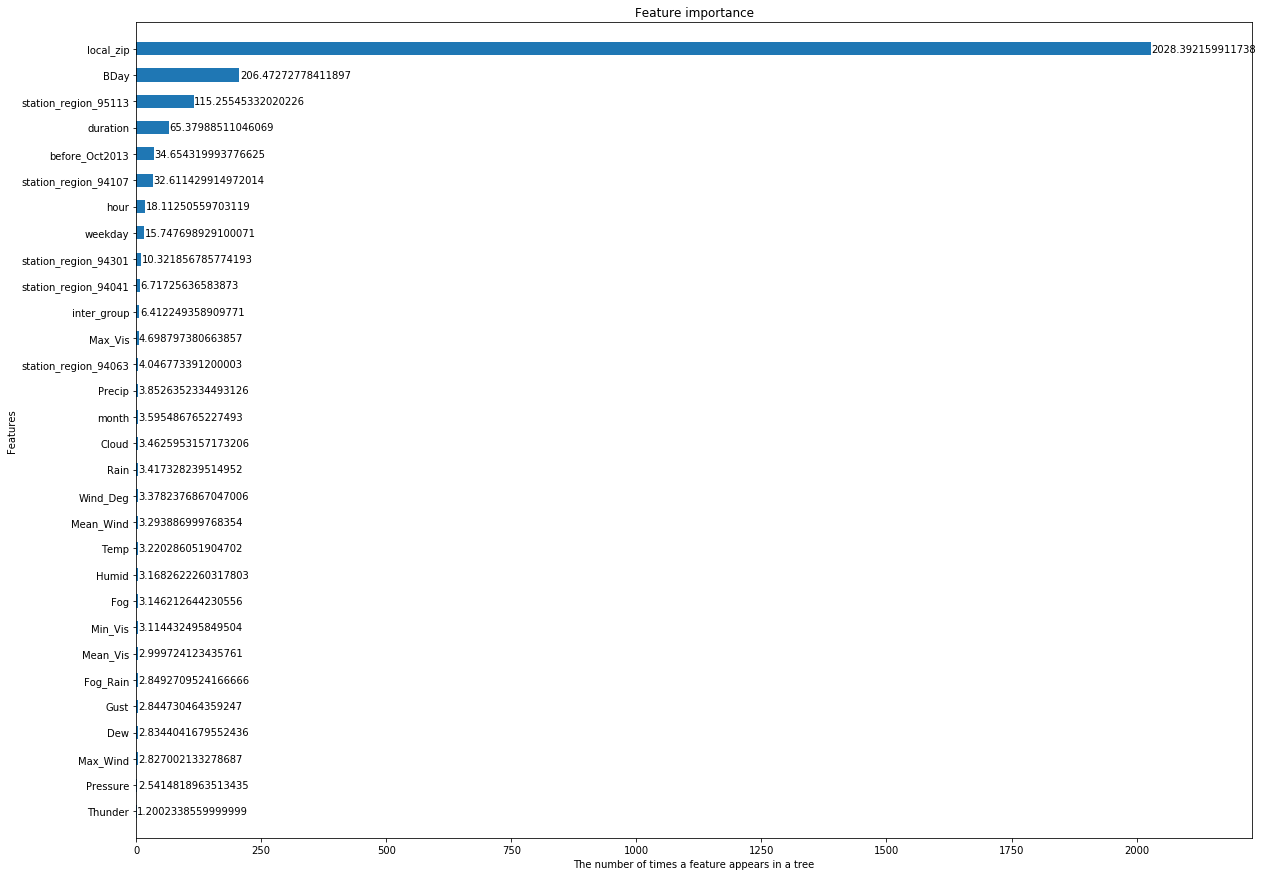

In [378]:
# Plot the importance using xgboost's function. By Gain.
plt.figure(figsize = (20, 15))
ax = plt.subplot()
xgb.plot_importance(xgb_full, ax=ax, importance_type='gain', xlabel='The number of times a feature appears in a tree', height=0.5, grid=False)
xgb_importance_gain = pd.Series(xgb_full.get_booster().get_score(importance_type='gain'))
plt.show()

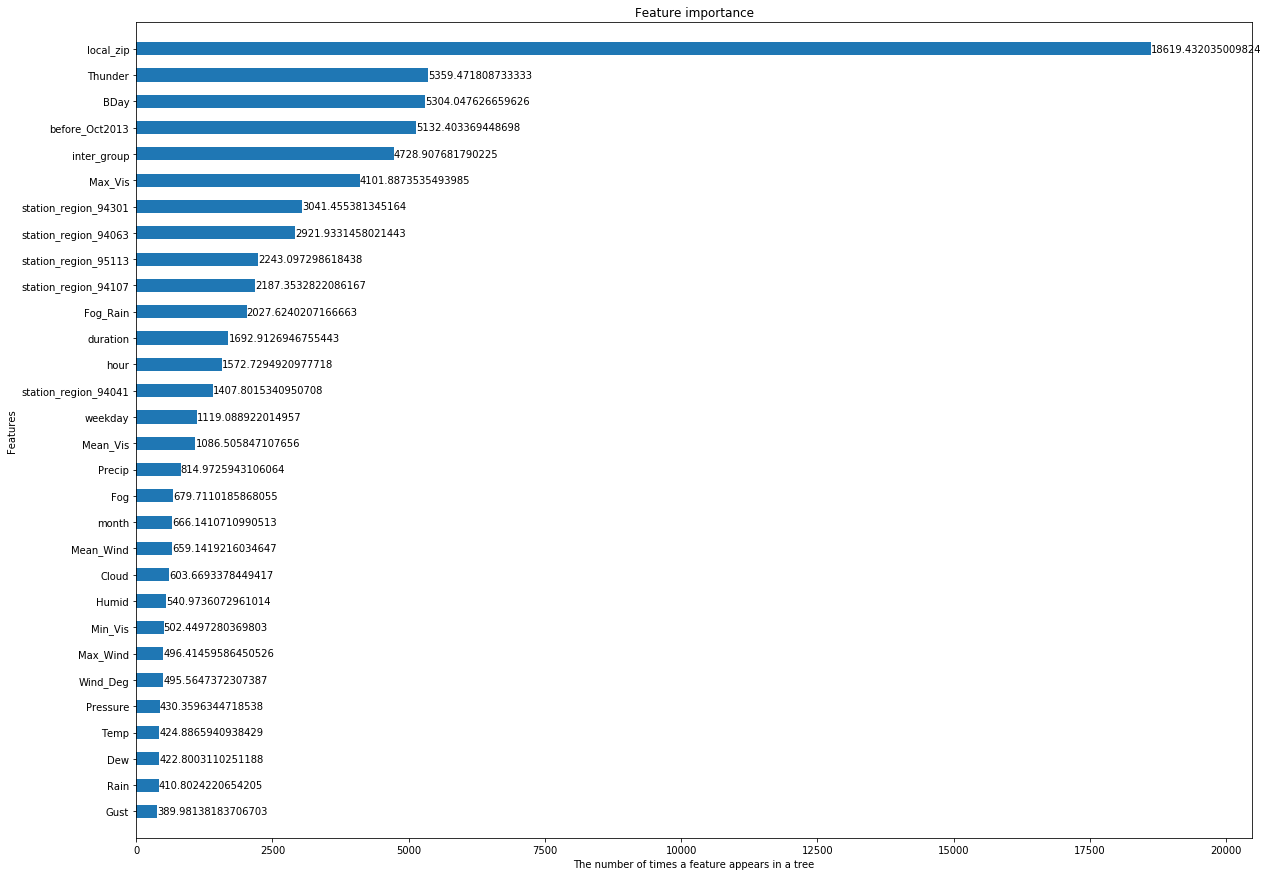

In [379]:
# Plot the importance using xgboost's function. By Cover.
plt.figure(figsize = (20, 15))
ax = plt.subplot()
xgb.plot_importance(xgb_full, ax=ax, importance_type='cover', xlabel='The number of times a feature appears in a tree', height=0.5, grid=False)
xgb_importance_cover = pd.Series(xgb_full.get_booster().get_score(importance_type='cover'))
plt.show()

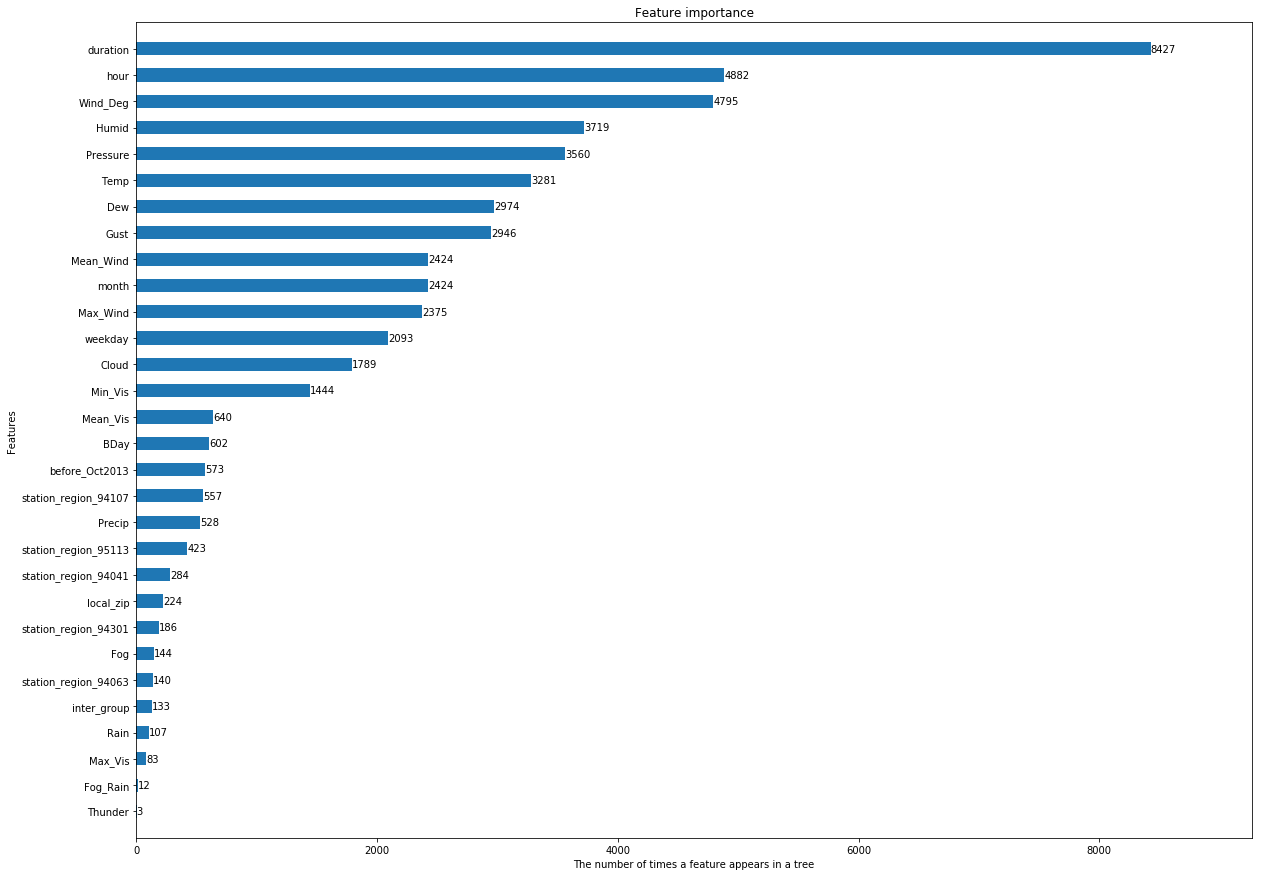

In [380]:
# Plot the importance using xgboost's function. By Weight.
plt.figure(figsize = (20, 15))
ax = plt.subplot()
xgb.plot_importance(xgb_full, ax=ax, importance_type='weight', xlabel='The number of times a feature appears in a tree', height=0.5, grid=False)
xgb_importance_weight = pd.Series(xgb_full.get_booster().get_score(importance_type='weight'))
plt.show()

In [381]:
# Concatenate all the importance series together to form a dataframe
xgb_importance_df = pd.concat([xgb_importance_weight, xgb_importance_gain, xgb_importance_cover], axis=1)
xgb_importance_df.columns = ['Weight', 'Gain', 'Cover']

In [382]:
# Change the gain and cover scales to logarithm to minimize the data skew.
xgb_importance_df['LogGain'] = np.log10(xgb_importance_df.Gain)
xgb_importance_df['LogCover'] = np.log(xgb_importance_df.Cover)

In [383]:
# Normalize the three importances to 
xgb_importance_scaled = pd.DataFrame(MinMaxScaler().fit_transform(xgb_importance_df[['Weight', 'LogGain', 'LogCover']]))
xgb_importance_scaled.index = xgb_importance_df.index
xgb_importance_scaled.columns = ['Weight', 'LogGain', 'LogCover']

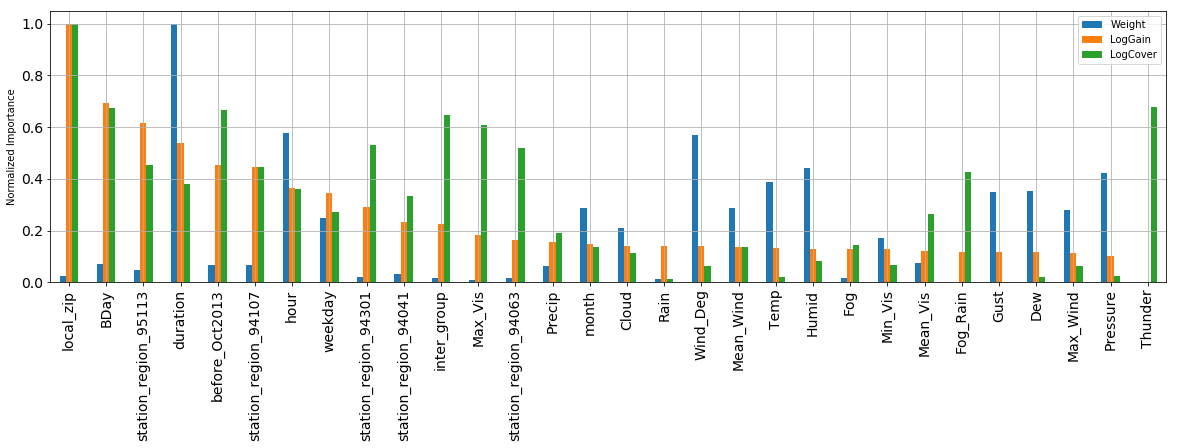

In [384]:
xgb_importance_scaled.sort_values('LogGain', ascending=False).plot.bar(figsize=(20, 5), grid=True, fontsize=14, )
plt.ylabel('Normalized Importance')
plt.show()

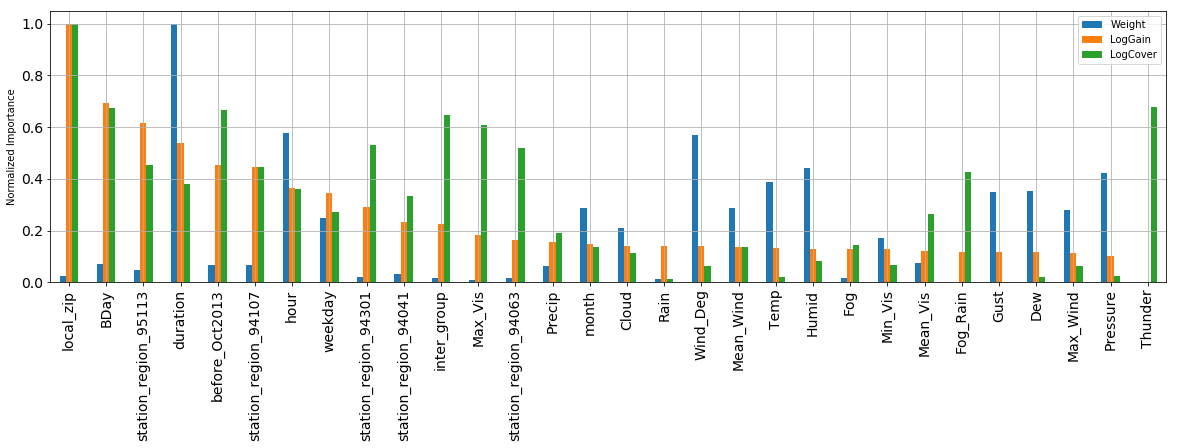

In [385]:
xgb_importance_scaled.sort_values('LogGain', ascending=False).plot.bar(figsize=(20, 5), grid=True, fontsize=14, )
plt.ylabel('Normalized Importance')
plt.show()

In [386]:
# Plot a decision tree from the xgboost following the instruction below:
# https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/
# A pdf file will be opened to see the details. 
# The xgboost plot function for python cannot specify the maximum depth to plot.

tree_plot = xgb.to_graphviz(xgb_full, num_trees=16, rankdir='LR')
tree_plot.view()

'Digraph.gv.pdf'

In [387]:
def dot_to_df(tree_body):
    '''Extract the nodes information from a DOT file. The function returns a pandas series with two columns: 
       left nodes and right nodes'''
    
    edge_list = []
    for line in tree_body:
        try:
            edge_left, edge_right = line.split('->')[0:2]
        except:
            continue
            
        node_left = int(edge_left)
        node_right = int(edge_right.split()[0])
        
        edge_list.append((node_left, node_right))
        
    edge_df = pd.DataFrame(edge_list)
    edge_df.columns = ['left_node', 'right_node']
    
    return edge_df

In [388]:
def nodes_depth(tree_body, depth = 3):
    '''This function collects the node indices up to the designated depths.'''
    # Convert the DOT body code to a pandas DataFrame with the edge (node pair)
    edge_df = dot_to_df(tree_body)
       
    d_nodes = [[0]]
    for d in range(0, depth):
        next_node = edge_df.loc[edge_df.left_node.isin(d_nodes[d]), 'right_node'].tolist()
        d_nodes.append(next_node)
        
    return [node_point for d_node in d_nodes for node_point in d_node]

In [389]:
def change_depth(tree_body, depth = 3):
    '''This function changes the depth of a decision tree to display via graphviz.
       It returns a new DOT code with the designated depth for a decision tree.'''
    
    nodes_deep = nodes_depth(tree_body, depth = depth)
    nodes_deeper = nodes_depth(tree_body, depth = depth + 1)
    nodes_diff = list(set(nodes_deeper)^set(nodes_deep))

    keep_line_idx = []
    for idx, line in enumerate(tree_body):
        item_list = line.split()
        left_node = int(item_list[0])

        if left_node in nodes_deep:
            keep_line_idx.append(idx)
        elif (left_node in nodes_diff) and (item_list[1] != '->'):
            keep_line_idx.append(idx)
    
    new_lines = [tree_body[i] for i in keep_line_idx]
    new_string = '\n'.join(new_lines)
    
    new_dot = '\n'.join(['digraph {', '\tgraph [rankdir=LR]', new_string, '}'])
    
    return new_dot

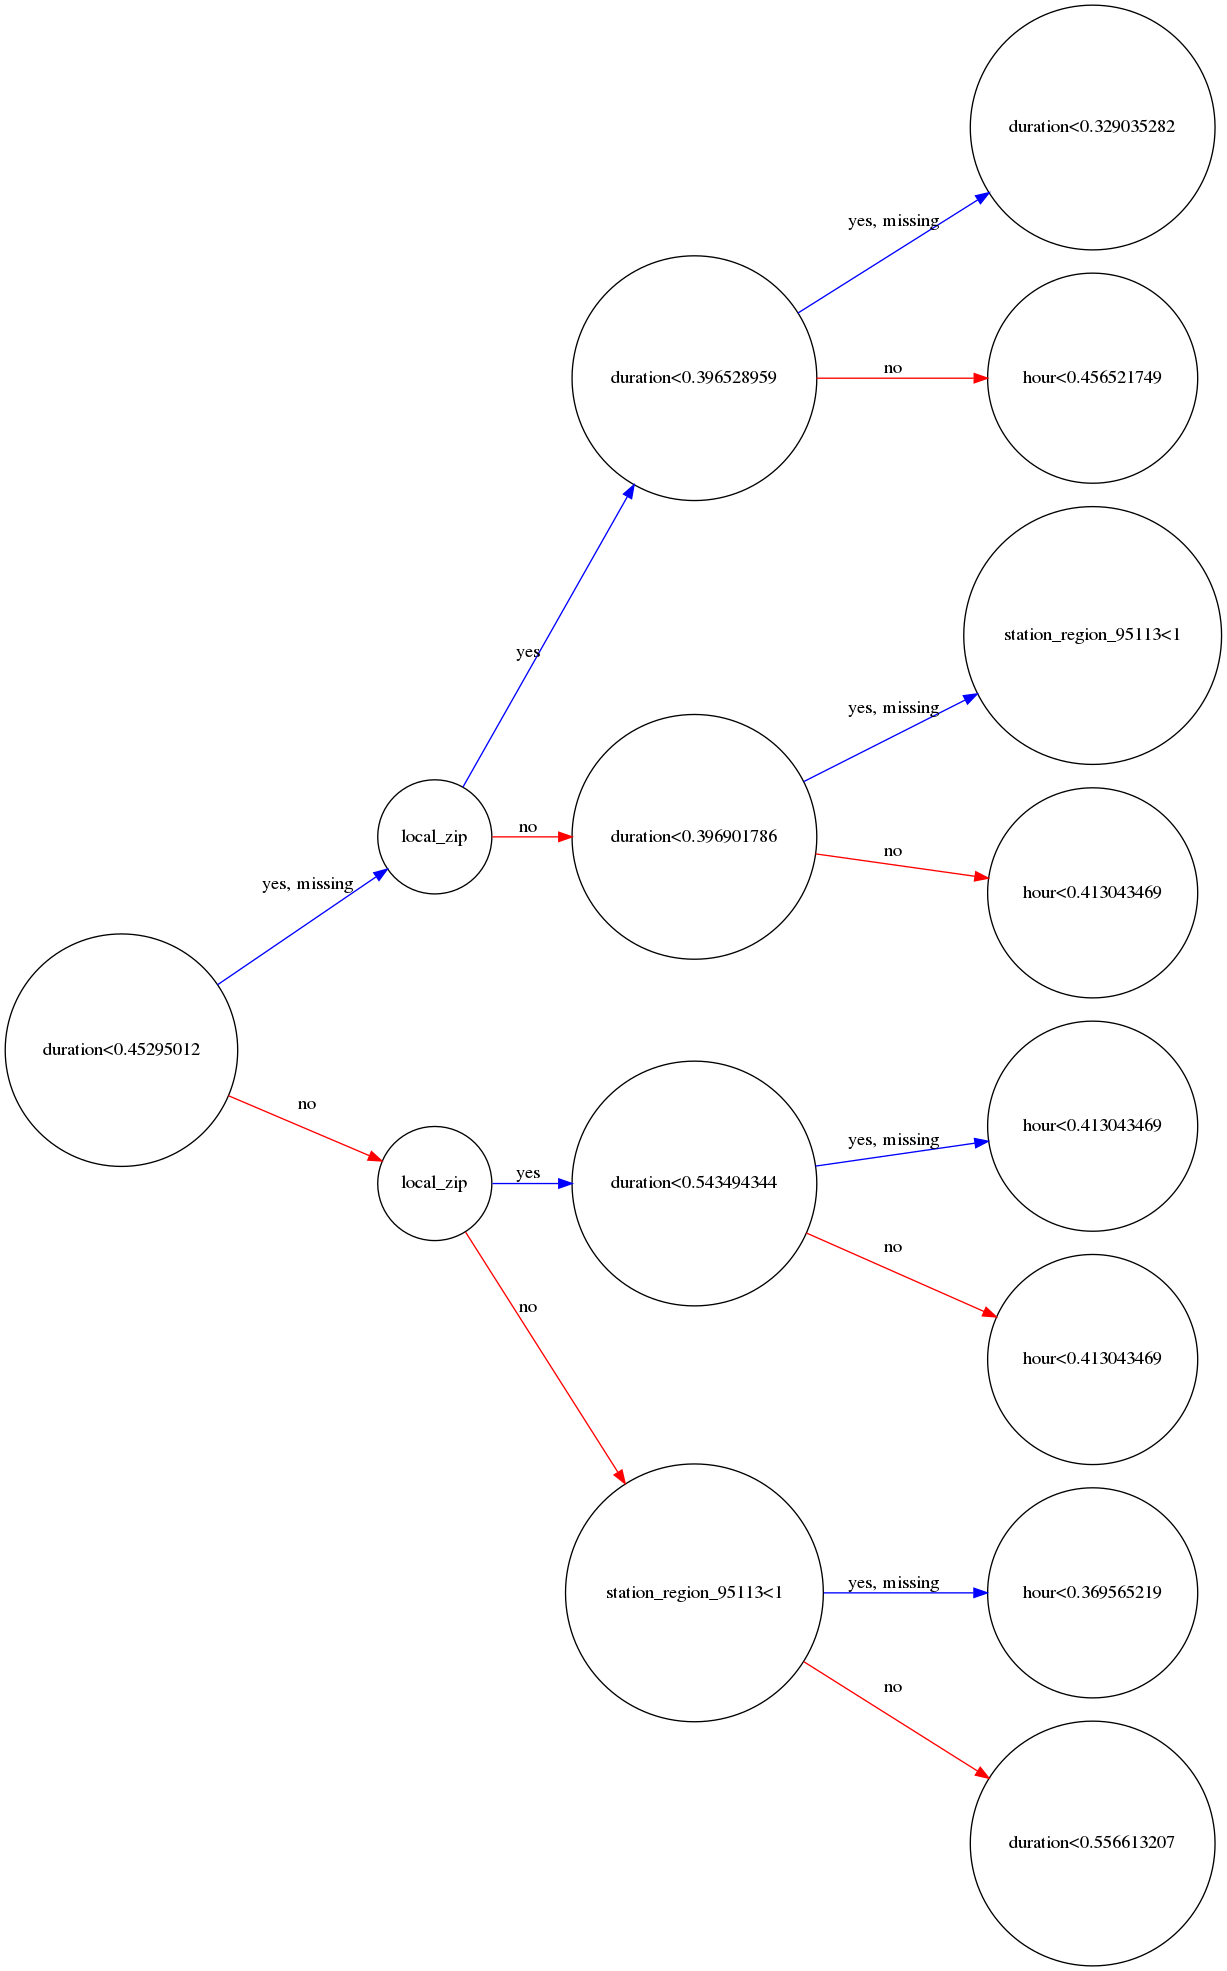

In [390]:
# Create new DOT source code
new_dot_code = change_depth(tree_plot.body, depth = 2)

# Convert the DOT source code to a graph
graph = pydotplus.graph_from_dot_data(new_dot_code)
graph.write_png('xgb_tree_16.png')
Image(graph.create_png(), width=800)